In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 73.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [3]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Mounted at /content/drive


In [4]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [5]:
suf = '_v3'

data_save_dir = 'data'+suf

suf += '_no_rnn'

In [6]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [7]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [8]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/I-ADR/I-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/I-ADR/I-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/I-ADR/I-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [9]:
len(docs)

1186

In [10]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/I-ADR/I-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/I-ADR/I-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/I-ADR/I-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [11]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'I-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'I-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'I-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'B-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [12]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [13]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
stacked_embeddings = StackedEmbeddings([
    WordEmbeddings('glove',
                   force_cpu=False,
                #    embedding_length=1024,
                  #  fine_tune=True,
                   ),
    # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
    #                                    subtoken_pooling="first",
    #                                    is_document_embedding=True,
    #                                    fine_tune=True,
    #                                    use_context=True,
    #                                    max_seq_length=1024,
    #                                    ),
    FlairEmbeddings('news-forward',
                    # fine_tune=True
                    ),
    FlairEmbeddings('news-backward',
                    # fine_tune=True
                    ),
])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md

# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        embeddings=stacked_embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        # use_crf=False,
                        use_rnn=False,
                        # reproject_embeddings=False,
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 06:31:48,992 Filtering empty sentences
2023-04-21 06:31:49,044 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 06:31:49,046 Computing label dictionary. Progress:


948it [00:00, 6694.00it/s]

2023-04-21 06:31:49,195 Dictionary created for label 'ner' with 12 values: O (seen 79057 times), I-ADR (seen 7953 times), B-ADR (seen 4712 times), B-Drug (seen 1396 times), I-Finding (seen 349 times), B-Finding (seen 309 times), B-Disease (seen 231 times), B-Symptom (seen 222 times), I-Symptom (seen 218 times), I-Disease (seen 169 times), I-Drug (seen 161 times)
False


2023-04-21 06:31:50,201 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpipnmabm9


100%|██████████| 153M/153M [00:13<00:00, 12.1MB/s]

2023-04-21 06:32:04,051 copying /tmp/tmpipnmabm9 to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2023-04-21 06:32:04,170 removing temp file /tmp/tmpipnmabm9
2023-04-21 06:32:04,849 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpzgid3gn8


100%|██████████| 20.5M/20.5M [00:02<00:00, 7.25MB/s]

2023-04-21 06:32:08,464 copying /tmp/tmpzgid3gn8 to cache at /root/.flair/embeddings/glove.gensim
2023-04-21 06:32:08,482 removing temp file /tmp/tmpzgid3gn8


2023-04-21 06:32:19,351 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmp7igsemf4


100%|██████████| 69.7M/69.7M [00:06<00:00, 10.8MB/s]

2023-04-21 06:32:27,119 copying /tmp/tmp7igsemf4 to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2023-04-21 06:32:27,174 removing temp file /tmp/tmp7igsemf4
2023-04-21 06:32:32,026 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmpjz05w1rd


100%|██████████| 69.7M/69.7M [00:06<00:00, 10.9MB/s]

2023-04-21 06:32:39,364 copying /tmp/tmpjz05w1rd to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2023-04-21 06:32:39,419 removing temp file /tmp/tmpjz05w1rd
2023-04-21 06:32:39,647 SequenceTagger predicts: Dictionary with 12 tags: <unk>, O, I-ADR, B-ADR, B-Drug, I-Finding, B-Finding, B-Disease, B-Symptom, I-Symptom, I-Disease, I-Drug
True
False


In [14]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [15]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 12,
              eval_batch_size = 12,
              patience=1,
              anneal_factor = 0.5,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=1e-1,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 06:32:39,836 tensorboard logging path is runs/tb_logs_v3_no_rnn
2023-04-21 06:32:39,847 ----------------------------------------------------------------------------------------------------
2023-04-21 06:32:39,849 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (linear): Linear(in_features=4196, out_features=14, bias=Tr

100%|██████████| 79/79 [00:19<00:00,  4.04it/s]

2023-04-21 06:33:31,658 Evaluating as a multi-label problem: True


2023-04-21 06:33:33,479 TRAIN : loss 236.70489501953125 - f1-score (weighted avg)  0.4232


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

2023-04-21 06:33:37,720 Evaluating as a multi-label problem: False
2023-04-21 06:33:37,788 DEV : loss 255.78189086914062 - f1-score (weighted avg)  0.4131
2023-04-21 06:33:37,797 BAD EPOCHS (no improvement): 0
2023-04-21 06:33:37,802 saving best model


2023-04-21 06:33:39,537 ----------------------------------------------------------------------------------------------------
2023-04-21 06:33:40,899 epoch 2 - iter 7/79 - loss 303.24261400 - time (sec): 1.36 - samples/sec: 5725.22 - lr: 0.100000
2023-04-21 06:33:42,224 epoch 2 - iter 14/79 - loss 310.39342349 - time (sec): 2.68 - samples/sec: 5826.56 - lr: 0.100000
2023-04-21 06:33:43,888 epoch 2 - iter 21/79 - loss 274.60554707 - time (sec): 4.35 - samples/sec: 5722.80 - lr: 0.100000
2023-04-21 06:33:45,850 epoch 2 - iter 28/79 - loss 264.48554462 - time (sec): 6.31 - samples/sec: 5424.00 - lr: 0.100000
2023-04-21 06:33:47,615 epoch 2 - iter 35/79 - loss 267.04690186 - time (sec): 8.08 - samples/sec: 5330.14 - lr: 0.100000
2023-04-21 06:33:49,038 epoch 2 - iter 42/79 - loss 262.99147871 - time (sec): 9.50 - samples/sec: 5395.85 - lr: 0.100000
2023-04-21 06:33:50,609 epoch 2 - iter 49/79 - loss 282.37626750 - time (sec): 11.07 - samples/sec: 5425.66 - lr: 0.100000
2023-04-21 06:33:52,0

100%|██████████| 79/79 [00:20<00:00,  3.81it/s]

2023-04-21 06:34:17,924 Evaluating as a multi-label problem: True


2023-04-21 06:34:19,760 TRAIN : loss 208.71144104003906 - f1-score (weighted avg)  0.5187


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 06:34:22,400 Evaluating as a multi-label problem: False
2023-04-21 06:34:22,471 DEV : loss 244.9864959716797 - f1-score (weighted avg)  0.4696
2023-04-21 06:34:22,481 BAD EPOCHS (no improvement): 0
2023-04-21 06:34:22,485 saving best model


2023-04-21 06:34:24,342 ----------------------------------------------------------------------------------------------------
2023-04-21 06:34:25,763 epoch 3 - iter 7/79 - loss 304.59512761 - time (sec): 1.42 - samples/sec: 5771.40 - lr: 0.100000
2023-04-21 06:34:27,184 epoch 3 - iter 14/79 - loss 307.04084430 - time (sec): 2.84 - samples/sec: 5779.00 - lr: 0.100000
2023-04-21 06:34:28,864 epoch 3 - iter 21/79 - loss 347.06972216 - time (sec): 4.52 - samples/sec: 5708.69 - lr: 0.100000
2023-04-21 06:34:30,309 epoch 3 - iter 28/79 - loss 366.31622920 - time (sec): 5.97 - samples/sec: 5773.55 - lr: 0.100000
2023-04-21 06:34:31,711 epoch 3 - iter 35/79 - loss 369.08494961 - time (sec): 7.37 - samples/sec: 5697.06 - lr: 0.100000
2023-04-21 06:34:33,190 epoch 3 - iter 42/79 - loss 350.70793493 - time (sec): 8.85 - samples/sec: 5639.33 - lr: 0.100000
2023-04-21 06:34:34,779 epoch 3 - iter 49/79 - loss 348.96003005 - time (sec): 10.44 - samples/sec: 5612.52 - lr: 0.100000
2023-04-21 06:34:37,1

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 06:35:02,270 Evaluating as a multi-label problem: True


2023-04-21 06:35:05,328 TRAIN : loss 300.0597229003906 - f1-score (weighted avg)  0.4161


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

2023-04-21 06:35:07,983 Evaluating as a multi-label problem: False
2023-04-21 06:35:08,049 DEV : loss 326.432373046875 - f1-score (weighted avg)  0.4051
2023-04-21 06:35:08,058 BAD EPOCHS (no improvement): 1
2023-04-21 06:35:08,062 ----------------------------------------------------------------------------------------------------


2023-04-21 06:35:09,502 epoch 4 - iter 7/79 - loss 359.44078633 - time (sec): 1.44 - samples/sec: 5817.41 - lr: 0.100000
2023-04-21 06:35:10,777 epoch 4 - iter 14/79 - loss 351.44171779 - time (sec): 2.71 - samples/sec: 5765.75 - lr: 0.100000
2023-04-21 06:35:12,427 epoch 4 - iter 21/79 - loss 345.81723694 - time (sec): 4.36 - samples/sec: 5512.33 - lr: 0.100000
2023-04-21 06:35:14,262 epoch 4 - iter 28/79 - loss 330.57252634 - time (sec): 6.20 - samples/sec: 5222.41 - lr: 0.100000
2023-04-21 06:35:15,670 epoch 4 - iter 35/79 - loss 318.73231448 - time (sec): 7.61 - samples/sec: 5348.38 - lr: 0.100000
2023-04-21 06:35:17,503 epoch 4 - iter 42/79 - loss 318.40868053 - time (sec): 9.44 - samples/sec: 5344.48 - lr: 0.100000
2023-04-21 06:35:19,329 epoch 4 - iter 49/79 - loss 328.27191527 - time (sec): 11.27 - samples/sec: 5296.83 - lr: 0.100000
2023-04-21 06:35:20,633 epoch 4 - iter 56/79 - loss 335.90444641 - time (sec): 12.57 - samples/sec: 5352.63 - lr: 0.100000
2023-04-21 06:35:22,083

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 06:35:45,461 Evaluating as a multi-label problem: True


2023-04-21 06:35:47,324 TRAIN : loss 242.12222290039062 - f1-score (weighted avg)  0.5504


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 06:35:49,965 Evaluating as a multi-label problem: False
2023-04-21 06:35:50,036 DEV : loss 283.011474609375 - f1-score (weighted avg)  0.5248
2023-04-21 06:35:50,045 Epoch     4: reducing learning rate of group 0 to 5.0000e-02.
2023-04-21 06:35:50,047 BAD EPOCHS (no improvement): 2
2023-04-21 06:35:50,051 ----------------------------------------------------------------------------------------------------


2023-04-21 06:35:51,544 epoch 5 - iter 7/79 - loss 296.38494600 - time (sec): 1.49 - samples/sec: 6084.20 - lr: 0.050000
2023-04-21 06:35:52,972 epoch 5 - iter 14/79 - loss 316.42315114 - time (sec): 2.92 - samples/sec: 6033.52 - lr: 0.050000
2023-04-21 06:35:54,679 epoch 5 - iter 21/79 - loss 295.36118740 - time (sec): 4.63 - samples/sec: 5744.35 - lr: 0.050000
2023-04-21 06:35:55,850 epoch 5 - iter 28/79 - loss 279.01524745 - time (sec): 5.80 - samples/sec: 5775.20 - lr: 0.050000
2023-04-21 06:35:57,089 epoch 5 - iter 35/79 - loss 279.58838298 - time (sec): 7.04 - samples/sec: 5830.11 - lr: 0.050000
2023-04-21 06:35:58,956 epoch 5 - iter 42/79 - loss 281.99546911 - time (sec): 8.90 - samples/sec: 5676.29 - lr: 0.050000
2023-04-21 06:36:00,354 epoch 5 - iter 49/79 - loss 273.81297306 - time (sec): 10.30 - samples/sec: 5681.27 - lr: 0.050000
2023-04-21 06:36:01,836 epoch 5 - iter 56/79 - loss 262.91928723 - time (sec): 11.78 - samples/sec: 5648.01 - lr: 0.050000
2023-04-21 06:36:03,441

100%|██████████| 79/79 [00:20<00:00,  3.76it/s]

2023-04-21 06:36:28,137 Evaluating as a multi-label problem: True


2023-04-21 06:36:29,996 TRAIN : loss 121.9336166381836 - f1-score (weighted avg)  0.6343


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

2023-04-21 06:36:32,650 Evaluating as a multi-label problem: False
2023-04-21 06:36:32,718 DEV : loss 156.13169860839844 - f1-score (weighted avg)  0.59
2023-04-21 06:36:32,727 BAD EPOCHS (no improvement): 0
2023-04-21 06:36:32,731 saving best model


2023-04-21 06:36:34,537 ----------------------------------------------------------------------------------------------------
2023-04-21 06:36:36,220 epoch 6 - iter 7/79 - loss 207.21423064 - time (sec): 1.68 - samples/sec: 5402.14 - lr: 0.050000
2023-04-21 06:36:38,122 epoch 6 - iter 14/79 - loss 211.56909429 - time (sec): 3.58 - samples/sec: 5025.90 - lr: 0.050000
2023-04-21 06:36:39,792 epoch 6 - iter 21/79 - loss 205.22755592 - time (sec): 5.25 - samples/sec: 5072.28 - lr: 0.050000
2023-04-21 06:36:41,097 epoch 6 - iter 28/79 - loss 196.47011839 - time (sec): 6.56 - samples/sec: 5217.14 - lr: 0.050000
2023-04-21 06:36:42,656 epoch 6 - iter 35/79 - loss 187.40916714 - time (sec): 8.12 - samples/sec: 5216.10 - lr: 0.050000
2023-04-21 06:36:44,260 epoch 6 - iter 42/79 - loss 180.28271539 - time (sec): 9.72 - samples/sec: 5271.47 - lr: 0.050000
2023-04-21 06:36:45,826 epoch 6 - iter 49/79 - loss 180.81304730 - time (sec): 11.29 - samples/sec: 5342.09 - lr: 0.050000
2023-04-21 06:36:47,7

100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


2023-04-21 06:37:13,979 Evaluating as a multi-label problem: True
2023-04-21 06:37:15,831 TRAIN : loss 133.89158630371094 - f1-score (weighted avg)  0.5815


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 06:37:18,467 Evaluating as a multi-label problem: False
2023-04-21 06:37:18,540 DEV : loss 179.7421112060547 - f1-score (weighted avg)  0.5399
2023-04-21 06:37:18,549 BAD EPOCHS (no improvement): 1
2023-04-21 06:37:18,554 ----------------------------------------------------------------------------------------------------


2023-04-21 06:37:20,254 epoch 7 - iter 7/79 - loss 165.37485750 - time (sec): 1.70 - samples/sec: 4647.54 - lr: 0.050000
2023-04-21 06:37:21,878 epoch 7 - iter 14/79 - loss 180.51238263 - time (sec): 3.32 - samples/sec: 4839.47 - lr: 0.050000
2023-04-21 06:37:23,721 epoch 7 - iter 21/79 - loss 169.97570554 - time (sec): 5.17 - samples/sec: 4663.77 - lr: 0.050000
2023-04-21 06:37:25,062 epoch 7 - iter 28/79 - loss 173.27126418 - time (sec): 6.51 - samples/sec: 4971.37 - lr: 0.050000
2023-04-21 06:37:26,797 epoch 7 - iter 35/79 - loss 175.75955186 - time (sec): 8.24 - samples/sec: 5050.57 - lr: 0.050000
2023-04-21 06:37:28,414 epoch 7 - iter 42/79 - loss 177.47675342 - time (sec): 9.86 - samples/sec: 5075.98 - lr: 0.050000
2023-04-21 06:37:29,717 epoch 7 - iter 49/79 - loss 173.38062644 - time (sec): 11.16 - samples/sec: 5174.96 - lr: 0.050000
2023-04-21 06:37:31,110 epoch 7 - iter 56/79 - loss 169.05936383 - time (sec): 12.56 - samples/sec: 5301.61 - lr: 0.050000
2023-04-21 06:37:32,602

100%|██████████| 79/79 [00:19<00:00,  3.97it/s]

2023-04-21 06:37:56,148 Evaluating as a multi-label problem: True


2023-04-21 06:37:58,008 TRAIN : loss 100.53085327148438 - f1-score (weighted avg)  0.5856


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


2023-04-21 06:38:01,716 Evaluating as a multi-label problem: False
2023-04-21 06:38:01,784 DEV : loss 138.7762908935547 - f1-score (weighted avg)  0.5235
2023-04-21 06:38:01,794 BAD EPOCHS (no improvement): 0
2023-04-21 06:38:01,808 saving best model
2023-04-21 06:38:03,606 ----------------------------------------------------------------------------------------------------
2023-04-21 06:38:04,889 epoch 8 - iter 7/79 - loss 157.08637153 - time (sec): 1.28 - samples/sec: 6297.56 - lr: 0.050000
2023-04-21 06:38:06,642 epoch 8 - iter 14/79 - loss 139.73436908 - time (sec): 3.03 - samples/sec: 5220.31 - lr: 0.050000
2023-04-21 06:38:07,961 epoch 8 - iter 21/79 - loss 140.19959230 - time (sec): 4.35 - samples/sec: 5382.06 - lr: 0.050000
2023-04-21 06:38:09,066 epoch 8 - iter 28/79 - loss 136.14190453 - time (sec): 5.46 - samples/sec: 5585.49 - lr: 0.050000
2023-04-21 06:38:10,575 epoch 8 - iter 35/79 - loss 142.22748716 - time (sec): 6.97 - samples/sec: 5644.75 - lr: 0.050000
2023-04-21 06:3

100%|██████████| 79/79 [00:19<00:00,  3.97it/s]

2023-04-21 06:38:41,519 Evaluating as a multi-label problem: True


2023-04-21 06:38:43,371 TRAIN : loss 114.70535278320312 - f1-score (weighted avg)  0.5819


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 06:38:45,993 Evaluating as a multi-label problem: False
2023-04-21 06:38:46,062 DEV : loss 146.93936157226562 - f1-score (weighted avg)  0.5325
2023-04-21 06:38:46,072 BAD EPOCHS (no improvement): 1
2023-04-21 06:38:46,076 ----------------------------------------------------------------------------------------------------


2023-04-21 06:38:47,675 epoch 9 - iter 7/79 - loss 146.26805539 - time (sec): 1.60 - samples/sec: 5244.68 - lr: 0.050000
2023-04-21 06:38:49,588 epoch 9 - iter 14/79 - loss 153.90570924 - time (sec): 3.51 - samples/sec: 4923.05 - lr: 0.050000
2023-04-21 06:38:51,073 epoch 9 - iter 21/79 - loss 159.61415244 - time (sec): 4.99 - samples/sec: 5289.99 - lr: 0.050000
2023-04-21 06:38:52,626 epoch 9 - iter 28/79 - loss 159.18489901 - time (sec): 6.55 - samples/sec: 5262.15 - lr: 0.050000
2023-04-21 06:38:54,033 epoch 9 - iter 35/79 - loss 152.72928097 - time (sec): 7.96 - samples/sec: 5452.58 - lr: 0.050000
2023-04-21 06:38:55,593 epoch 9 - iter 42/79 - loss 152.70903066 - time (sec): 9.52 - samples/sec: 5375.44 - lr: 0.050000
2023-04-21 06:38:56,896 epoch 9 - iter 49/79 - loss 150.40058803 - time (sec): 10.82 - samples/sec: 5478.60 - lr: 0.050000
2023-04-21 06:38:58,529 epoch 9 - iter 56/79 - loss 147.62389813 - time (sec): 12.45 - samples/sec: 5466.70 - lr: 0.050000
2023-04-21 06:39:00,191

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


2023-04-21 06:39:24,752 Evaluating as a multi-label problem: True
2023-04-21 06:39:26,614 TRAIN : loss 95.2791748046875 - f1-score (weighted avg)  0.6251


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 06:39:29,261 Evaluating as a multi-label problem: False
2023-04-21 06:39:29,330 DEV : loss 130.91543579101562 - f1-score (weighted avg)  0.5701
2023-04-21 06:39:29,340 BAD EPOCHS (no improvement): 0
2023-04-21 06:39:29,344 saving best model


2023-04-21 06:39:31,167 ----------------------------------------------------------------------------------------------------
2023-04-21 06:39:32,669 epoch 10 - iter 7/79 - loss 136.33745089 - time (sec): 1.50 - samples/sec: 4414.71 - lr: 0.050000
2023-04-21 06:39:34,267 epoch 10 - iter 14/79 - loss 141.29779341 - time (sec): 3.10 - samples/sec: 5047.92 - lr: 0.050000
2023-04-21 06:39:35,699 epoch 10 - iter 21/79 - loss 136.49931283 - time (sec): 4.53 - samples/sec: 5140.75 - lr: 0.050000
2023-04-21 06:39:37,235 epoch 10 - iter 28/79 - loss 138.38733751 - time (sec): 6.07 - samples/sec: 5263.23 - lr: 0.050000
2023-04-21 06:39:38,625 epoch 10 - iter 35/79 - loss 133.73815292 - time (sec): 7.46 - samples/sec: 5426.12 - lr: 0.050000
2023-04-21 06:39:40,281 epoch 10 - iter 42/79 - loss 132.98645363 - time (sec): 9.11 - samples/sec: 5327.09 - lr: 0.050000
2023-04-21 06:39:41,569 epoch 10 - iter 49/79 - loss 134.68271751 - time (sec): 10.40 - samples/sec: 5356.03 - lr: 0.050000
2023-04-21 06:

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

2023-04-21 06:40:08,998 Evaluating as a multi-label problem: True


2023-04-21 06:40:12,151 TRAIN : loss 97.79492950439453 - f1-score (weighted avg)  0.6066


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

2023-04-21 06:40:14,847 Evaluating as a multi-label problem: False
2023-04-21 06:40:14,928 DEV : loss 130.17807006835938 - f1-score (weighted avg)  0.567
2023-04-21 06:40:14,938 BAD EPOCHS (no improvement): 0
2023-04-21 06:40:14,942 saving best model


2023-04-21 06:40:16,750 ----------------------------------------------------------------------------------------------------
2023-04-21 06:40:18,351 epoch 11 - iter 7/79 - loss 127.09513490 - time (sec): 1.59 - samples/sec: 5813.82 - lr: 0.050000
2023-04-21 06:40:19,800 epoch 11 - iter 14/79 - loss 144.16351441 - time (sec): 3.04 - samples/sec: 5929.60 - lr: 0.050000
2023-04-21 06:40:21,506 epoch 11 - iter 21/79 - loss 147.87917919 - time (sec): 4.74 - samples/sec: 5613.29 - lr: 0.050000
2023-04-21 06:40:22,927 epoch 11 - iter 28/79 - loss 151.13773172 - time (sec): 6.16 - samples/sec: 5558.19 - lr: 0.050000
2023-04-21 06:40:24,971 epoch 11 - iter 35/79 - loss 151.59039568 - time (sec): 8.21 - samples/sec: 5296.39 - lr: 0.050000
2023-04-21 06:40:26,414 epoch 11 - iter 42/79 - loss 147.80156927 - time (sec): 9.65 - samples/sec: 5335.64 - lr: 0.050000
2023-04-21 06:40:28,254 epoch 11 - iter 49/79 - loss 144.51569084 - time (sec): 11.49 - samples/sec: 5143.26 - lr: 0.050000
2023-04-21 06:

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]

2023-04-21 06:40:54,411 Evaluating as a multi-label problem: True


2023-04-21 06:40:56,283 TRAIN : loss 162.58175659179688 - f1-score (weighted avg)  0.366


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 06:40:58,899 Evaluating as a multi-label problem: False
2023-04-21 06:40:58,967 DEV : loss 192.02427673339844 - f1-score (weighted avg)  0.3408
2023-04-21 06:40:58,976 BAD EPOCHS (no improvement): 1
2023-04-21 06:40:58,981 ----------------------------------------------------------------------------------------------------


2023-04-21 06:41:00,197 epoch 12 - iter 7/79 - loss 163.77234144 - time (sec): 1.21 - samples/sec: 6060.54 - lr: 0.050000
2023-04-21 06:41:01,854 epoch 12 - iter 14/79 - loss 167.52078775 - time (sec): 2.87 - samples/sec: 5728.53 - lr: 0.050000
2023-04-21 06:41:03,377 epoch 12 - iter 21/79 - loss 157.76067637 - time (sec): 4.39 - samples/sec: 5723.46 - lr: 0.050000
2023-04-21 06:41:04,900 epoch 12 - iter 28/79 - loss 151.12595051 - time (sec): 5.92 - samples/sec: 5778.16 - lr: 0.050000
2023-04-21 06:41:06,664 epoch 12 - iter 35/79 - loss 143.78717889 - time (sec): 7.68 - samples/sec: 5600.09 - lr: 0.050000
2023-04-21 06:41:08,265 epoch 12 - iter 42/79 - loss 140.63599271 - time (sec): 9.28 - samples/sec: 5557.68 - lr: 0.050000
2023-04-21 06:41:09,656 epoch 12 - iter 49/79 - loss 139.03840793 - time (sec): 10.67 - samples/sec: 5545.40 - lr: 0.050000
2023-04-21 06:41:11,379 epoch 12 - iter 56/79 - loss 134.64188437 - time (sec): 12.40 - samples/sec: 5505.71 - lr: 0.050000
2023-04-21 06:4

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


2023-04-21 06:41:37,411 Evaluating as a multi-label problem: True
2023-04-21 06:41:39,280 TRAIN : loss 139.54920959472656 - f1-score (weighted avg)  0.5858


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 06:41:41,890 Evaluating as a multi-label problem: False
2023-04-21 06:41:41,971 DEV : loss 169.09567260742188 - f1-score (weighted avg)  0.5411
2023-04-21 06:41:41,980 Epoch    12: reducing learning rate of group 0 to 2.5000e-02.
2023-04-21 06:41:41,983 BAD EPOCHS (no improvement): 2
2023-04-21 06:41:41,989 ----------------------------------------------------------------------------------------------------


2023-04-21 06:41:43,562 epoch 13 - iter 7/79 - loss 155.06961692 - time (sec): 1.57 - samples/sec: 5433.68 - lr: 0.025000
2023-04-21 06:41:45,086 epoch 13 - iter 14/79 - loss 134.65693647 - time (sec): 3.10 - samples/sec: 5456.20 - lr: 0.025000
2023-04-21 06:41:46,735 epoch 13 - iter 21/79 - loss 127.13225712 - time (sec): 4.74 - samples/sec: 5224.29 - lr: 0.025000
2023-04-21 06:41:48,081 epoch 13 - iter 28/79 - loss 122.43331579 - time (sec): 6.09 - samples/sec: 5381.42 - lr: 0.025000
2023-04-21 06:41:49,880 epoch 13 - iter 35/79 - loss 119.57003550 - time (sec): 7.89 - samples/sec: 5265.80 - lr: 0.025000
2023-04-21 06:41:51,278 epoch 13 - iter 42/79 - loss 117.22705048 - time (sec): 9.29 - samples/sec: 5312.91 - lr: 0.025000
2023-04-21 06:41:53,144 epoch 13 - iter 49/79 - loss 113.66254052 - time (sec): 11.15 - samples/sec: 5283.18 - lr: 0.025000
2023-04-21 06:41:54,669 epoch 13 - iter 56/79 - loss 111.99253542 - time (sec): 12.68 - samples/sec: 5371.77 - lr: 0.025000
2023-04-21 06:4

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 06:42:19,226 Evaluating as a multi-label problem: True


2023-04-21 06:42:21,090 TRAIN : loss 49.67378616333008 - f1-score (weighted avg)  0.6512


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

2023-04-21 06:42:24,780 Evaluating as a multi-label problem: False
2023-04-21 06:42:24,848 DEV : loss 78.19248962402344 - f1-score (weighted avg)  0.5923
2023-04-21 06:42:24,858 BAD EPOCHS (no improvement): 0
2023-04-21 06:42:24,862 saving best model


2023-04-21 06:42:26,656 ----------------------------------------------------------------------------------------------------
2023-04-21 06:42:28,084 epoch 14 - iter 7/79 - loss 77.62202883 - time (sec): 1.42 - samples/sec: 5405.87 - lr: 0.025000
2023-04-21 06:42:29,974 epoch 14 - iter 14/79 - loss 75.15438810 - time (sec): 3.31 - samples/sec: 5342.34 - lr: 0.025000
2023-04-21 06:42:31,465 epoch 14 - iter 21/79 - loss 78.44908671 - time (sec): 4.81 - samples/sec: 5411.84 - lr: 0.025000
2023-04-21 06:42:33,320 epoch 14 - iter 28/79 - loss 79.21194852 - time (sec): 6.66 - samples/sec: 5200.03 - lr: 0.025000
2023-04-21 06:42:34,784 epoch 14 - iter 35/79 - loss 80.10900162 - time (sec): 8.12 - samples/sec: 5253.98 - lr: 0.025000
2023-04-21 06:42:36,440 epoch 14 - iter 42/79 - loss 79.01343121 - time (sec): 9.78 - samples/sec: 5225.13 - lr: 0.025000
2023-04-21 06:42:38,212 epoch 14 - iter 49/79 - loss 78.34150806 - time (sec): 11.55 - samples/sec: 5243.77 - lr: 0.025000
2023-04-21 06:42:39,5

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 06:43:03,894 Evaluating as a multi-label problem: True


2023-04-21 06:43:05,751 TRAIN : loss 40.339927673339844 - f1-score (weighted avg)  0.6443


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 06:43:08,365 Evaluating as a multi-label problem: False
2023-04-21 06:43:08,434 DEV : loss 69.9004898071289 - f1-score (weighted avg)  0.5688
2023-04-21 06:43:08,443 BAD EPOCHS (no improvement): 0
2023-04-21 06:43:08,447 saving best model


2023-04-21 06:43:10,268 ----------------------------------------------------------------------------------------------------
2023-04-21 06:43:12,058 epoch 15 - iter 7/79 - loss 76.61069828 - time (sec): 1.79 - samples/sec: 4744.82 - lr: 0.025000
2023-04-21 06:43:13,428 epoch 15 - iter 14/79 - loss 69.27278871 - time (sec): 3.16 - samples/sec: 5213.58 - lr: 0.025000
2023-04-21 06:43:15,349 epoch 15 - iter 21/79 - loss 66.94508150 - time (sec): 5.08 - samples/sec: 5061.92 - lr: 0.025000
2023-04-21 06:43:16,690 epoch 15 - iter 28/79 - loss 68.23056290 - time (sec): 6.42 - samples/sec: 5299.99 - lr: 0.025000
2023-04-21 06:43:18,542 epoch 15 - iter 35/79 - loss 69.65606813 - time (sec): 8.27 - samples/sec: 5297.41 - lr: 0.025000
2023-04-21 06:43:19,869 epoch 15 - iter 42/79 - loss 68.54123939 - time (sec): 9.60 - samples/sec: 5415.29 - lr: 0.025000
2023-04-21 06:43:21,204 epoch 15 - iter 49/79 - loss 67.45860971 - time (sec): 10.93 - samples/sec: 5501.81 - lr: 0.025000
2023-04-21 06:43:22,7

100%|██████████| 79/79 [00:20<00:00,  3.77it/s]

2023-04-21 06:43:48,777 Evaluating as a multi-label problem: True


2023-04-21 06:43:50,642 TRAIN : loss 40.103843688964844 - f1-score (weighted avg)  0.6499


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

2023-04-21 06:43:53,270 Evaluating as a multi-label problem: False
2023-04-21 06:43:53,337 DEV : loss 67.31417083740234 - f1-score (weighted avg)  0.5766
2023-04-21 06:43:53,346 BAD EPOCHS (no improvement): 0
2023-04-21 06:43:53,350 saving best model


2023-04-21 06:43:55,148 ----------------------------------------------------------------------------------------------------
2023-04-21 06:43:56,710 epoch 16 - iter 7/79 - loss 68.18433198 - time (sec): 1.56 - samples/sec: 6150.23 - lr: 0.025000
2023-04-21 06:43:58,650 epoch 16 - iter 14/79 - loss 62.84701579 - time (sec): 3.50 - samples/sec: 5537.91 - lr: 0.025000
2023-04-21 06:44:00,107 epoch 16 - iter 21/79 - loss 61.08086152 - time (sec): 4.96 - samples/sec: 5554.43 - lr: 0.025000
2023-04-21 06:44:01,719 epoch 16 - iter 28/79 - loss 64.33764560 - time (sec): 6.57 - samples/sec: 5476.62 - lr: 0.025000
2023-04-21 06:44:03,182 epoch 16 - iter 35/79 - loss 64.26133381 - time (sec): 8.03 - samples/sec: 5456.13 - lr: 0.025000
2023-04-21 06:44:04,610 epoch 16 - iter 42/79 - loss 65.55356392 - time (sec): 9.46 - samples/sec: 5528.61 - lr: 0.025000
2023-04-21 06:44:06,037 epoch 16 - iter 49/79 - loss 65.53758025 - time (sec): 10.89 - samples/sec: 5551.23 - lr: 0.025000
2023-04-21 06:44:07,5

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]

2023-04-21 06:44:32,568 Evaluating as a multi-label problem: True


2023-04-21 06:44:35,705 TRAIN : loss 41.92377471923828 - f1-score (weighted avg)  0.6559


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

2023-04-21 06:44:38,426 Evaluating as a multi-label problem: False
2023-04-21 06:44:38,497 DEV : loss 67.08356475830078 - f1-score (weighted avg)  0.5861
2023-04-21 06:44:38,506 BAD EPOCHS (no improvement): 0
2023-04-21 06:44:38,510 saving best model


2023-04-21 06:44:40,331 ----------------------------------------------------------------------------------------------------
2023-04-21 06:44:41,819 epoch 17 - iter 7/79 - loss 57.08360468 - time (sec): 1.49 - samples/sec: 4857.12 - lr: 0.025000
2023-04-21 06:44:43,293 epoch 17 - iter 14/79 - loss 61.17942813 - time (sec): 2.96 - samples/sec: 5465.18 - lr: 0.025000
2023-04-21 06:44:44,645 epoch 17 - iter 21/79 - loss 62.48087920 - time (sec): 4.31 - samples/sec: 5616.98 - lr: 0.025000
2023-04-21 06:44:46,315 epoch 17 - iter 28/79 - loss 63.48429100 - time (sec): 5.98 - samples/sec: 5628.11 - lr: 0.025000
2023-04-21 06:44:47,543 epoch 17 - iter 35/79 - loss 62.58743151 - time (sec): 7.21 - samples/sec: 5670.75 - lr: 0.025000
2023-04-21 06:44:49,482 epoch 17 - iter 42/79 - loss 63.18109506 - time (sec): 9.15 - samples/sec: 5436.20 - lr: 0.025000
2023-04-21 06:44:51,436 epoch 17 - iter 49/79 - loss 62.00906453 - time (sec): 11.10 - samples/sec: 5347.19 - lr: 0.025000
2023-04-21 06:44:52,8

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 06:45:18,342 Evaluating as a multi-label problem: True


2023-04-21 06:45:20,214 TRAIN : loss 42.31814956665039 - f1-score (weighted avg)  0.6239


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

2023-04-21 06:45:22,869 Evaluating as a multi-label problem: False
2023-04-21 06:45:22,940 DEV : loss 65.89649963378906 - f1-score (weighted avg)  0.5638
2023-04-21 06:45:22,949 BAD EPOCHS (no improvement): 0
2023-04-21 06:45:22,954 saving best model


2023-04-21 06:45:24,757 ----------------------------------------------------------------------------------------------------
2023-04-21 06:45:26,296 epoch 18 - iter 7/79 - loss 59.42494885 - time (sec): 1.54 - samples/sec: 6041.19 - lr: 0.025000
2023-04-21 06:45:28,119 epoch 18 - iter 14/79 - loss 55.64778260 - time (sec): 3.36 - samples/sec: 5317.92 - lr: 0.025000
2023-04-21 06:45:29,503 epoch 18 - iter 21/79 - loss 56.03182809 - time (sec): 4.74 - samples/sec: 5366.58 - lr: 0.025000
2023-04-21 06:45:30,684 epoch 18 - iter 28/79 - loss 56.13376698 - time (sec): 5.93 - samples/sec: 5529.78 - lr: 0.025000
2023-04-21 06:45:32,418 epoch 18 - iter 35/79 - loss 57.63992944 - time (sec): 7.66 - samples/sec: 5449.34 - lr: 0.025000
2023-04-21 06:45:34,688 epoch 18 - iter 42/79 - loss 59.82883565 - time (sec): 9.93 - samples/sec: 5123.93 - lr: 0.025000
2023-04-21 06:45:35,903 epoch 18 - iter 49/79 - loss 59.96450633 - time (sec): 11.14 - samples/sec: 5265.75 - lr: 0.025000
2023-04-21 06:45:37,2

100%|██████████| 79/79 [00:21<00:00,  3.76it/s]

2023-04-21 06:46:03,599 Evaluating as a multi-label problem: True


2023-04-21 06:46:05,470 TRAIN : loss 44.99423599243164 - f1-score (weighted avg)  0.6339


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 06:46:08,112 Evaluating as a multi-label problem: False
2023-04-21 06:46:08,184 DEV : loss 71.40547943115234 - f1-score (weighted avg)  0.5973
2023-04-21 06:46:08,194 BAD EPOCHS (no improvement): 1
2023-04-21 06:46:08,199 ----------------------------------------------------------------------------------------------------


2023-04-21 06:46:10,045 epoch 19 - iter 7/79 - loss 68.63494687 - time (sec): 1.84 - samples/sec: 4796.83 - lr: 0.025000
2023-04-21 06:46:11,466 epoch 19 - iter 14/79 - loss 67.26337282 - time (sec): 3.27 - samples/sec: 4912.08 - lr: 0.025000
2023-04-21 06:46:12,946 epoch 19 - iter 21/79 - loss 60.85070738 - time (sec): 4.75 - samples/sec: 5317.32 - lr: 0.025000
2023-04-21 06:46:14,629 epoch 19 - iter 28/79 - loss 60.53135844 - time (sec): 6.43 - samples/sec: 5334.45 - lr: 0.025000
2023-04-21 06:46:16,731 epoch 19 - iter 35/79 - loss 61.24370848 - time (sec): 8.53 - samples/sec: 5116.65 - lr: 0.025000
2023-04-21 06:46:18,024 epoch 19 - iter 42/79 - loss 63.13729960 - time (sec): 9.82 - samples/sec: 5219.38 - lr: 0.025000
2023-04-21 06:46:19,599 epoch 19 - iter 49/79 - loss 61.38913968 - time (sec): 11.40 - samples/sec: 5271.59 - lr: 0.025000
2023-04-21 06:46:21,147 epoch 19 - iter 56/79 - loss 61.61574799 - time (sec): 12.95 - samples/sec: 5328.54 - lr: 0.025000
2023-04-21 06:46:22,340

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]

2023-04-21 06:46:45,515 Evaluating as a multi-label problem: True


2023-04-21 06:46:48,627 TRAIN : loss 36.03307342529297 - f1-score (weighted avg)  0.6632


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 06:46:51,232 Evaluating as a multi-label problem: False
2023-04-21 06:46:51,303 DEV : loss 56.88645935058594 - f1-score (weighted avg)  0.6092
2023-04-21 06:46:51,312 BAD EPOCHS (no improvement): 0
2023-04-21 06:46:51,316 saving best model


2023-04-21 06:46:53,123 ----------------------------------------------------------------------------------------------------
2023-04-21 06:46:54,608 epoch 20 - iter 7/79 - loss 61.49593556 - time (sec): 1.47 - samples/sec: 5794.11 - lr: 0.025000
2023-04-21 06:46:55,923 epoch 20 - iter 14/79 - loss 65.11323975 - time (sec): 2.79 - samples/sec: 5811.76 - lr: 0.025000
2023-04-21 06:46:57,868 epoch 20 - iter 21/79 - loss 62.78262293 - time (sec): 4.73 - samples/sec: 5244.25 - lr: 0.025000
2023-04-21 06:46:59,180 epoch 20 - iter 28/79 - loss 65.45529963 - time (sec): 6.04 - samples/sec: 5575.48 - lr: 0.025000
2023-04-21 06:47:00,477 epoch 20 - iter 35/79 - loss 64.91743181 - time (sec): 7.34 - samples/sec: 5550.19 - lr: 0.025000
2023-04-21 06:47:02,049 epoch 20 - iter 42/79 - loss 63.39378520 - time (sec): 8.91 - samples/sec: 5480.03 - lr: 0.025000
2023-04-21 06:47:03,755 epoch 20 - iter 49/79 - loss 63.07119747 - time (sec): 10.62 - samples/sec: 5443.49 - lr: 0.025000
2023-04-21 06:47:05,1

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 06:47:30,753 Evaluating as a multi-label problem: True


2023-04-21 06:47:32,623 TRAIN : loss 34.6785774230957 - f1-score (weighted avg)  0.6455


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

2023-04-21 06:47:35,233 Evaluating as a multi-label problem: False
2023-04-21 06:47:35,304 DEV : loss 57.63330841064453 - f1-score (weighted avg)  0.5749
2023-04-21 06:47:35,313 BAD EPOCHS (no improvement): 1
2023-04-21 06:47:35,317 ----------------------------------------------------------------------------------------------------


2023-04-21 06:47:36,979 epoch 21 - iter 7/79 - loss 48.20893895 - time (sec): 1.66 - samples/sec: 4764.47 - lr: 0.025000
2023-04-21 06:47:38,375 epoch 21 - iter 14/79 - loss 48.54718220 - time (sec): 3.06 - samples/sec: 5108.07 - lr: 0.025000
2023-04-21 06:47:39,782 epoch 21 - iter 21/79 - loss 49.89205829 - time (sec): 4.46 - samples/sec: 5353.46 - lr: 0.025000
2023-04-21 06:47:41,157 epoch 21 - iter 28/79 - loss 53.09684298 - time (sec): 5.84 - samples/sec: 5431.84 - lr: 0.025000
2023-04-21 06:47:42,651 epoch 21 - iter 35/79 - loss 53.82092958 - time (sec): 7.33 - samples/sec: 5490.52 - lr: 0.025000
2023-04-21 06:47:44,384 epoch 21 - iter 42/79 - loss 54.95361268 - time (sec): 9.07 - samples/sec: 5385.85 - lr: 0.025000
2023-04-21 06:47:45,727 epoch 21 - iter 49/79 - loss 53.67870615 - time (sec): 10.41 - samples/sec: 5450.06 - lr: 0.025000
2023-04-21 06:47:47,294 epoch 21 - iter 56/79 - loss 53.37688931 - time (sec): 11.98 - samples/sec: 5497.18 - lr: 0.025000
2023-04-21 06:47:49,111

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 06:48:13,861 Evaluating as a multi-label problem: True


2023-04-21 06:48:15,731 TRAIN : loss 30.17097282409668 - f1-score (weighted avg)  0.666


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 06:48:18,377 Evaluating as a multi-label problem: False
2023-04-21 06:48:18,448 DEV : loss 51.88227081298828 - f1-score (weighted avg)  0.5938
2023-04-21 06:48:18,458 BAD EPOCHS (no improvement): 0
2023-04-21 06:48:18,461 saving best model


2023-04-21 06:48:20,268 ----------------------------------------------------------------------------------------------------
2023-04-21 06:48:21,933 epoch 22 - iter 7/79 - loss 49.46799261 - time (sec): 1.66 - samples/sec: 5532.77 - lr: 0.025000
2023-04-21 06:48:23,438 epoch 22 - iter 14/79 - loss 46.76388068 - time (sec): 3.17 - samples/sec: 5875.92 - lr: 0.025000
2023-04-21 06:48:24,820 epoch 22 - iter 21/79 - loss 49.02435287 - time (sec): 4.55 - samples/sec: 5935.47 - lr: 0.025000
2023-04-21 06:48:26,284 epoch 22 - iter 28/79 - loss 51.77787032 - time (sec): 6.01 - samples/sec: 5939.83 - lr: 0.025000
2023-04-21 06:48:27,786 epoch 22 - iter 35/79 - loss 54.53577360 - time (sec): 7.52 - samples/sec: 5848.79 - lr: 0.025000
2023-04-21 06:48:29,563 epoch 22 - iter 42/79 - loss 54.97850656 - time (sec): 9.29 - samples/sec: 5770.15 - lr: 0.025000
2023-04-21 06:48:30,978 epoch 22 - iter 49/79 - loss 55.49688345 - time (sec): 10.71 - samples/sec: 5764.54 - lr: 0.025000
2023-04-21 06:48:32,6

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]

2023-04-21 06:48:58,000 Evaluating as a multi-label problem: True


2023-04-21 06:49:01,139 TRAIN : loss 38.224796295166016 - f1-score (weighted avg)  0.6004


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

2023-04-21 06:49:03,768 Evaluating as a multi-label problem: False
2023-04-21 06:49:03,834 DEV : loss 58.237457275390625 - f1-score (weighted avg)  0.5531
2023-04-21 06:49:03,844 BAD EPOCHS (no improvement): 1
2023-04-21 06:49:03,848 ----------------------------------------------------------------------------------------------------


2023-04-21 06:49:05,756 epoch 23 - iter 7/79 - loss 42.58585482 - time (sec): 1.91 - samples/sec: 5103.89 - lr: 0.025000
2023-04-21 06:49:07,320 epoch 23 - iter 14/79 - loss 48.92224431 - time (sec): 3.47 - samples/sec: 5181.23 - lr: 0.025000
2023-04-21 06:49:09,062 epoch 23 - iter 21/79 - loss 49.65889956 - time (sec): 5.21 - samples/sec: 5194.83 - lr: 0.025000
2023-04-21 06:49:10,479 epoch 23 - iter 28/79 - loss 49.33917659 - time (sec): 6.63 - samples/sec: 5207.72 - lr: 0.025000
2023-04-21 06:49:11,907 epoch 23 - iter 35/79 - loss 51.44558332 - time (sec): 8.06 - samples/sec: 5230.61 - lr: 0.025000
2023-04-21 06:49:13,392 epoch 23 - iter 42/79 - loss 52.50852831 - time (sec): 9.54 - samples/sec: 5275.73 - lr: 0.025000
2023-04-21 06:49:14,848 epoch 23 - iter 49/79 - loss 53.20067046 - time (sec): 11.00 - samples/sec: 5332.90 - lr: 0.025000
2023-04-21 06:49:16,271 epoch 23 - iter 56/79 - loss 53.70586492 - time (sec): 12.42 - samples/sec: 5431.35 - lr: 0.025000
2023-04-21 06:49:18,106

100%|██████████| 79/79 [00:19<00:00,  3.96it/s]

2023-04-21 06:49:41,641 Evaluating as a multi-label problem: True


2023-04-21 06:49:43,505 TRAIN : loss 35.555423736572266 - f1-score (weighted avg)  0.6249


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

2023-04-21 06:49:46,152 Evaluating as a multi-label problem: False
2023-04-21 06:49:46,224 DEV : loss 59.5703125 - f1-score (weighted avg)  0.5635
2023-04-21 06:49:46,234 Epoch    23: reducing learning rate of group 0 to 1.2500e-02.
2023-04-21 06:49:46,236 BAD EPOCHS (no improvement): 2
2023-04-21 06:49:46,240 ----------------------------------------------------------------------------------------------------


2023-04-21 06:49:47,700 epoch 24 - iter 7/79 - loss 57.79343653 - time (sec): 1.46 - samples/sec: 5536.34 - lr: 0.012500
2023-04-21 06:49:48,992 epoch 24 - iter 14/79 - loss 53.55583607 - time (sec): 2.75 - samples/sec: 5868.76 - lr: 0.012500
2023-04-21 06:49:50,395 epoch 24 - iter 21/79 - loss 50.81742919 - time (sec): 4.15 - samples/sec: 5755.58 - lr: 0.012500
2023-04-21 06:49:52,012 epoch 24 - iter 28/79 - loss 48.25730835 - time (sec): 5.77 - samples/sec: 5801.00 - lr: 0.012500
2023-04-21 06:49:53,816 epoch 24 - iter 35/79 - loss 47.79696165 - time (sec): 7.57 - samples/sec: 5546.55 - lr: 0.012500
2023-04-21 06:49:55,301 epoch 24 - iter 42/79 - loss 47.59464564 - time (sec): 9.06 - samples/sec: 5588.21 - lr: 0.012500
2023-04-21 06:49:56,641 epoch 24 - iter 49/79 - loss 46.81638436 - time (sec): 10.40 - samples/sec: 5611.92 - lr: 0.012500
2023-04-21 06:49:58,530 epoch 24 - iter 56/79 - loss 45.46189384 - time (sec): 12.29 - samples/sec: 5482.66 - lr: 0.012500
2023-04-21 06:50:00,085

100%|██████████| 79/79 [00:20<00:00,  3.81it/s]

2023-04-21 06:50:24,323 Evaluating as a multi-label problem: True


2023-04-21 06:50:26,196 TRAIN : loss 22.481565475463867 - f1-score (weighted avg)  0.6701


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 06:50:28,840 Evaluating as a multi-label problem: False
2023-04-21 06:50:28,909 DEV : loss 43.040889739990234 - f1-score (weighted avg)  0.5969
2023-04-21 06:50:28,918 BAD EPOCHS (no improvement): 0
2023-04-21 06:50:28,922 saving best model


2023-04-21 06:50:30,739 ----------------------------------------------------------------------------------------------------
2023-04-21 06:50:32,578 epoch 25 - iter 7/79 - loss 34.58250313 - time (sec): 1.84 - samples/sec: 4781.17 - lr: 0.012500
2023-04-21 06:50:34,038 epoch 25 - iter 14/79 - loss 31.61565259 - time (sec): 3.30 - samples/sec: 5256.26 - lr: 0.012500
2023-04-21 06:50:35,823 epoch 25 - iter 21/79 - loss 32.91574903 - time (sec): 5.08 - samples/sec: 5057.41 - lr: 0.012500
2023-04-21 06:50:37,627 epoch 25 - iter 28/79 - loss 34.69085326 - time (sec): 6.89 - samples/sec: 5048.03 - lr: 0.012500
2023-04-21 06:50:39,145 epoch 25 - iter 35/79 - loss 33.81651997 - time (sec): 8.40 - samples/sec: 5097.16 - lr: 0.012500
2023-04-21 06:50:40,596 epoch 25 - iter 42/79 - loss 34.22783231 - time (sec): 9.86 - samples/sec: 5235.86 - lr: 0.012500
2023-04-21 06:50:42,169 epoch 25 - iter 49/79 - loss 34.67154235 - time (sec): 11.43 - samples/sec: 5199.58 - lr: 0.012500
2023-04-21 06:50:43,5

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 06:51:08,256 Evaluating as a multi-label problem: True


2023-04-21 06:51:11,372 TRAIN : loss 17.974634170532227 - f1-score (weighted avg)  0.6916


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 06:51:13,992 Evaluating as a multi-label problem: False
2023-04-21 06:51:14,061 DEV : loss 36.89798355102539 - f1-score (weighted avg)  0.6162
2023-04-21 06:51:14,070 BAD EPOCHS (no improvement): 0
2023-04-21 06:51:14,075 saving best model


2023-04-21 06:51:15,881 ----------------------------------------------------------------------------------------------------
2023-04-21 06:51:17,302 epoch 26 - iter 7/79 - loss 39.54255453 - time (sec): 1.42 - samples/sec: 5591.88 - lr: 0.012500
2023-04-21 06:51:18,636 epoch 26 - iter 14/79 - loss 37.09545426 - time (sec): 2.75 - samples/sec: 5702.69 - lr: 0.012500
2023-04-21 06:51:20,832 epoch 26 - iter 21/79 - loss 35.78351289 - time (sec): 4.95 - samples/sec: 5252.33 - lr: 0.012500
2023-04-21 06:51:22,243 epoch 26 - iter 28/79 - loss 36.20817262 - time (sec): 6.36 - samples/sec: 5421.57 - lr: 0.012500
2023-04-21 06:51:23,983 epoch 26 - iter 35/79 - loss 34.14788446 - time (sec): 8.10 - samples/sec: 5382.35 - lr: 0.012500
2023-04-21 06:51:25,378 epoch 26 - iter 42/79 - loss 33.97687369 - time (sec): 9.49 - samples/sec: 5325.35 - lr: 0.012500
2023-04-21 06:51:26,704 epoch 26 - iter 49/79 - loss 33.22450824 - time (sec): 10.82 - samples/sec: 5386.46 - lr: 0.012500
2023-04-21 06:51:28,4

100%|██████████| 79/79 [00:19<00:00,  3.95it/s]

2023-04-21 06:51:53,549 Evaluating as a multi-label problem: True


2023-04-21 06:51:55,410 TRAIN : loss 17.124711990356445 - f1-score (weighted avg)  0.6963


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

2023-04-21 06:51:58,045 Evaluating as a multi-label problem: False
2023-04-21 06:51:58,116 DEV : loss 34.308101654052734 - f1-score (weighted avg)  0.6147
2023-04-21 06:51:58,125 BAD EPOCHS (no improvement): 0
2023-04-21 06:51:58,130 saving best model


2023-04-21 06:51:59,928 ----------------------------------------------------------------------------------------------------
2023-04-21 06:52:01,714 epoch 27 - iter 7/79 - loss 31.75514299 - time (sec): 1.77 - samples/sec: 5305.33 - lr: 0.012500
2023-04-21 06:52:03,045 epoch 27 - iter 14/79 - loss 30.91740319 - time (sec): 3.10 - samples/sec: 5542.13 - lr: 0.012500
2023-04-21 06:52:05,119 epoch 27 - iter 21/79 - loss 31.38483284 - time (sec): 5.18 - samples/sec: 5107.16 - lr: 0.012500
2023-04-21 06:52:06,965 epoch 27 - iter 28/79 - loss 29.96153688 - time (sec): 7.02 - samples/sec: 5179.27 - lr: 0.012500
2023-04-21 06:52:08,379 epoch 27 - iter 35/79 - loss 29.81360155 - time (sec): 8.44 - samples/sec: 5238.55 - lr: 0.012500
2023-04-21 06:52:09,785 epoch 27 - iter 42/79 - loss 29.81031546 - time (sec): 9.84 - samples/sec: 5368.46 - lr: 0.012500
2023-04-21 06:52:11,265 epoch 27 - iter 49/79 - loss 29.35116756 - time (sec): 11.32 - samples/sec: 5413.84 - lr: 0.012500
2023-04-21 06:52:12,7

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 06:52:38,739 Evaluating as a multi-label problem: True


2023-04-21 06:52:40,592 TRAIN : loss 15.424275398254395 - f1-score (weighted avg)  0.6841


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

2023-04-21 06:52:43,240 Evaluating as a multi-label problem: False
2023-04-21 06:52:43,308 DEV : loss 32.67240905761719 - f1-score (weighted avg)  0.606
2023-04-21 06:52:43,318 BAD EPOCHS (no improvement): 0
2023-04-21 06:52:43,322 saving best model


2023-04-21 06:52:45,137 ----------------------------------------------------------------------------------------------------
2023-04-21 06:52:46,622 epoch 28 - iter 7/79 - loss 24.05570934 - time (sec): 1.48 - samples/sec: 5848.59 - lr: 0.012500
2023-04-21 06:52:48,007 epoch 28 - iter 14/79 - loss 26.17853521 - time (sec): 2.87 - samples/sec: 5675.17 - lr: 0.012500
2023-04-21 06:52:49,715 epoch 28 - iter 21/79 - loss 24.79806501 - time (sec): 4.58 - samples/sec: 5466.59 - lr: 0.012500
2023-04-21 06:52:51,053 epoch 28 - iter 28/79 - loss 26.11110404 - time (sec): 5.91 - samples/sec: 5645.40 - lr: 0.012500
2023-04-21 06:52:52,508 epoch 28 - iter 35/79 - loss 26.76886259 - time (sec): 7.37 - samples/sec: 5642.45 - lr: 0.012500
2023-04-21 06:52:54,551 epoch 28 - iter 42/79 - loss 27.29856444 - time (sec): 9.41 - samples/sec: 5375.16 - lr: 0.012500
2023-04-21 06:52:56,168 epoch 28 - iter 49/79 - loss 27.23718851 - time (sec): 11.03 - samples/sec: 5279.93 - lr: 0.012500
2023-04-21 06:52:58,0

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 06:53:22,925 Evaluating as a multi-label problem: True


2023-04-21 06:53:26,032 TRAIN : loss 18.10240936279297 - f1-score (weighted avg)  0.6206


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

2023-04-21 06:53:28,693 Evaluating as a multi-label problem: False
2023-04-21 06:53:28,760 DEV : loss 33.716026306152344 - f1-score (weighted avg)  0.5525
2023-04-21 06:53:28,769 BAD EPOCHS (no improvement): 1
2023-04-21 06:53:28,773 ----------------------------------------------------------------------------------------------------


2023-04-21 06:53:30,218 epoch 29 - iter 7/79 - loss 24.67532667 - time (sec): 1.44 - samples/sec: 6202.06 - lr: 0.012500
2023-04-21 06:53:32,479 epoch 29 - iter 14/79 - loss 24.06495297 - time (sec): 3.70 - samples/sec: 5309.57 - lr: 0.012500
2023-04-21 06:53:33,704 epoch 29 - iter 21/79 - loss 24.58435852 - time (sec): 4.93 - samples/sec: 5424.09 - lr: 0.012500
2023-04-21 06:53:35,078 epoch 29 - iter 28/79 - loss 24.21757237 - time (sec): 6.30 - samples/sec: 5556.92 - lr: 0.012500
2023-04-21 06:53:36,547 epoch 29 - iter 35/79 - loss 24.29370003 - time (sec): 7.77 - samples/sec: 5648.20 - lr: 0.012500
2023-04-21 06:53:37,983 epoch 29 - iter 42/79 - loss 24.35185975 - time (sec): 9.21 - samples/sec: 5696.68 - lr: 0.012500
2023-04-21 06:53:39,147 epoch 29 - iter 49/79 - loss 24.83045881 - time (sec): 10.37 - samples/sec: 5672.48 - lr: 0.012500
2023-04-21 06:53:40,815 epoch 29 - iter 56/79 - loss 25.91674388 - time (sec): 12.04 - samples/sec: 5534.88 - lr: 0.012500
2023-04-21 06:53:42,496

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

2023-04-21 06:54:05,836 Evaluating as a multi-label problem: True


2023-04-21 06:54:07,709 TRAIN : loss 14.101890563964844 - f1-score (weighted avg)  0.6766


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

2023-04-21 06:54:10,337 Evaluating as a multi-label problem: False
2023-04-21 06:54:10,405 DEV : loss 30.880666732788086 - f1-score (weighted avg)  0.5883
2023-04-21 06:54:10,414 BAD EPOCHS (no improvement): 0
2023-04-21 06:54:10,419 saving best model


2023-04-21 06:54:12,237 ----------------------------------------------------------------------------------------------------
2023-04-21 06:54:13,682 epoch 30 - iter 7/79 - loss 28.21654210 - time (sec): 1.44 - samples/sec: 5421.04 - lr: 0.012500
2023-04-21 06:54:15,164 epoch 30 - iter 14/79 - loss 25.90272868 - time (sec): 2.93 - samples/sec: 5511.06 - lr: 0.012500
2023-04-21 06:54:16,535 epoch 30 - iter 21/79 - loss 26.66202748 - time (sec): 4.30 - samples/sec: 5466.81 - lr: 0.012500
2023-04-21 06:54:17,970 epoch 30 - iter 28/79 - loss 26.66924986 - time (sec): 5.73 - samples/sec: 5458.63 - lr: 0.012500
2023-04-21 06:54:20,320 epoch 30 - iter 35/79 - loss 26.92648329 - time (sec): 8.08 - samples/sec: 5121.29 - lr: 0.012500
2023-04-21 06:54:21,767 epoch 30 - iter 42/79 - loss 27.15989474 - time (sec): 9.53 - samples/sec: 5162.11 - lr: 0.012500
2023-04-21 06:54:23,193 epoch 30 - iter 49/79 - loss 26.99959297 - time (sec): 10.95 - samples/sec: 5228.20 - lr: 0.012500
2023-04-21 06:54:25,0

100%|██████████| 79/79 [00:20<00:00,  3.77it/s]

2023-04-21 06:54:51,548 Evaluating as a multi-label problem: True


2023-04-21 06:54:53,416 TRAIN : loss 12.906679153442383 - f1-score (weighted avg)  0.6905


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 06:54:56,053 Evaluating as a multi-label problem: False
2023-04-21 06:54:56,125 DEV : loss 26.801801681518555 - f1-score (weighted avg)  0.6181
2023-04-21 06:54:56,135 BAD EPOCHS (no improvement): 0
2023-04-21 06:54:56,138 saving best model


2023-04-21 06:54:57,966 ----------------------------------------------------------------------------------------------------
2023-04-21 06:54:59,264 epoch 31 - iter 7/79 - loss 21.18926975 - time (sec): 1.30 - samples/sec: 6211.14 - lr: 0.012500
2023-04-21 06:55:00,853 epoch 31 - iter 14/79 - loss 21.68398142 - time (sec): 2.89 - samples/sec: 5269.25 - lr: 0.012500
2023-04-21 06:55:02,667 epoch 31 - iter 21/79 - loss 24.24931132 - time (sec): 4.70 - samples/sec: 5310.80 - lr: 0.012500
2023-04-21 06:55:04,062 epoch 31 - iter 28/79 - loss 24.47058309 - time (sec): 6.09 - samples/sec: 5390.33 - lr: 0.012500
2023-04-21 06:55:05,584 epoch 31 - iter 35/79 - loss 25.31439167 - time (sec): 7.62 - samples/sec: 5479.22 - lr: 0.012500
2023-04-21 06:55:07,181 epoch 31 - iter 42/79 - loss 25.36020869 - time (sec): 9.21 - samples/sec: 5362.19 - lr: 0.012500
2023-04-21 06:55:08,662 epoch 31 - iter 49/79 - loss 26.08289611 - time (sec): 10.69 - samples/sec: 5382.50 - lr: 0.012500
2023-04-21 06:55:10,3

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 06:55:35,480 Evaluating as a multi-label problem: True


2023-04-21 06:55:38,570 TRAIN : loss 13.199604988098145 - f1-score (weighted avg)  0.6808


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

2023-04-21 06:55:41,165 Evaluating as a multi-label problem: False
2023-04-21 06:55:41,234 DEV : loss 27.633787155151367 - f1-score (weighted avg)  0.6222
2023-04-21 06:55:41,243 BAD EPOCHS (no improvement): 1
2023-04-21 06:55:41,247 ----------------------------------------------------------------------------------------------------


2023-04-21 06:55:42,644 epoch 32 - iter 7/79 - loss 25.97228440 - time (sec): 1.40 - samples/sec: 6081.61 - lr: 0.012500
2023-04-21 06:55:44,264 epoch 32 - iter 14/79 - loss 27.22583660 - time (sec): 3.02 - samples/sec: 5410.38 - lr: 0.012500
2023-04-21 06:55:45,907 epoch 32 - iter 21/79 - loss 27.38725163 - time (sec): 4.66 - samples/sec: 5229.22 - lr: 0.012500
2023-04-21 06:55:47,630 epoch 32 - iter 28/79 - loss 27.89771239 - time (sec): 6.38 - samples/sec: 5024.53 - lr: 0.012500
2023-04-21 06:55:49,168 epoch 32 - iter 35/79 - loss 27.12845116 - time (sec): 7.92 - samples/sec: 5099.83 - lr: 0.012500
2023-04-21 06:55:50,512 epoch 32 - iter 42/79 - loss 27.39957856 - time (sec): 9.26 - samples/sec: 5148.58 - lr: 0.012500
2023-04-21 06:55:52,505 epoch 32 - iter 49/79 - loss 26.52505406 - time (sec): 11.26 - samples/sec: 5135.97 - lr: 0.012500
2023-04-21 06:55:53,945 epoch 32 - iter 56/79 - loss 26.30199925 - time (sec): 12.70 - samples/sec: 5239.64 - lr: 0.012500
2023-04-21 06:55:55,689

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]

2023-04-21 06:56:18,713 Evaluating as a multi-label problem: True


2023-04-21 06:56:20,587 TRAIN : loss 12.740036964416504 - f1-score (weighted avg)  0.6694


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 06:56:23,202 Evaluating as a multi-label problem: False
2023-04-21 06:56:23,273 DEV : loss 26.220823287963867 - f1-score (weighted avg)  0.6015
2023-04-21 06:56:23,283 BAD EPOCHS (no improvement): 0
2023-04-21 06:56:23,287 saving best model


2023-04-21 06:56:25,080 ----------------------------------------------------------------------------------------------------
2023-04-21 06:56:26,577 epoch 33 - iter 7/79 - loss 22.67553748 - time (sec): 1.49 - samples/sec: 5759.27 - lr: 0.012500
2023-04-21 06:56:27,819 epoch 33 - iter 14/79 - loss 23.78504823 - time (sec): 2.74 - samples/sec: 5986.84 - lr: 0.012500
2023-04-21 06:56:29,304 epoch 33 - iter 21/79 - loss 24.24930904 - time (sec): 4.22 - samples/sec: 5763.18 - lr: 0.012500
2023-04-21 06:56:30,842 epoch 33 - iter 28/79 - loss 24.31828540 - time (sec): 5.76 - samples/sec: 5780.44 - lr: 0.012500
2023-04-21 06:56:32,545 epoch 33 - iter 35/79 - loss 24.05699307 - time (sec): 7.46 - samples/sec: 5576.89 - lr: 0.012500
2023-04-21 06:56:33,929 epoch 33 - iter 42/79 - loss 25.08148369 - time (sec): 8.85 - samples/sec: 5659.39 - lr: 0.012500
2023-04-21 06:56:35,587 epoch 33 - iter 49/79 - loss 25.52215595 - time (sec): 10.50 - samples/sec: 5480.62 - lr: 0.012500
2023-04-21 06:56:37,2

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


2023-04-21 06:57:04,021 Evaluating as a multi-label problem: True
2023-04-21 06:57:05,867 TRAIN : loss 17.969812393188477 - f1-score (weighted avg)  0.5967


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 06:57:08,480 Evaluating as a multi-label problem: False
2023-04-21 06:57:08,548 DEV : loss 32.883583068847656 - f1-score (weighted avg)  0.5377
2023-04-21 06:57:08,558 BAD EPOCHS (no improvement): 1
2023-04-21 06:57:08,562 ----------------------------------------------------------------------------------------------------


2023-04-21 06:57:10,021 epoch 34 - iter 7/79 - loss 25.92403186 - time (sec): 1.46 - samples/sec: 5489.56 - lr: 0.012500
2023-04-21 06:57:11,563 epoch 34 - iter 14/79 - loss 22.95447838 - time (sec): 3.00 - samples/sec: 5534.33 - lr: 0.012500
2023-04-21 06:57:13,374 epoch 34 - iter 21/79 - loss 23.76451448 - time (sec): 4.81 - samples/sec: 5182.44 - lr: 0.012500
2023-04-21 06:57:14,730 epoch 34 - iter 28/79 - loss 23.44848796 - time (sec): 6.17 - samples/sec: 5292.18 - lr: 0.012500
2023-04-21 06:57:16,098 epoch 34 - iter 35/79 - loss 23.80918482 - time (sec): 7.53 - samples/sec: 5332.01 - lr: 0.012500
2023-04-21 06:57:17,726 epoch 34 - iter 42/79 - loss 23.97039460 - time (sec): 9.16 - samples/sec: 5229.97 - lr: 0.012500
2023-04-21 06:57:19,436 epoch 34 - iter 49/79 - loss 24.75026461 - time (sec): 10.87 - samples/sec: 5257.19 - lr: 0.012500
2023-04-21 06:57:21,347 epoch 34 - iter 56/79 - loss 24.93695845 - time (sec): 12.78 - samples/sec: 5154.66 - lr: 0.012500
2023-04-21 06:57:22,883

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 06:57:46,271 Evaluating as a multi-label problem: True


2023-04-21 06:57:49,426 TRAIN : loss 12.8441801071167 - f1-score (weighted avg)  0.677


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 06:57:52,073 Evaluating as a multi-label problem: False
2023-04-21 06:57:52,141 DEV : loss 26.01877784729004 - f1-score (weighted avg)  0.6132
2023-04-21 06:57:52,151 BAD EPOCHS (no improvement): 0
2023-04-21 06:57:52,155 saving best model


2023-04-21 06:57:53,984 ----------------------------------------------------------------------------------------------------
2023-04-21 06:57:55,380 epoch 35 - iter 7/79 - loss 20.92731342 - time (sec): 1.39 - samples/sec: 6176.01 - lr: 0.012500
2023-04-21 06:57:56,961 epoch 35 - iter 14/79 - loss 19.58503990 - time (sec): 2.97 - samples/sec: 5394.26 - lr: 0.012500
2023-04-21 06:57:58,744 epoch 35 - iter 21/79 - loss 22.29514720 - time (sec): 4.76 - samples/sec: 5090.81 - lr: 0.012500
2023-04-21 06:58:00,284 epoch 35 - iter 28/79 - loss 22.44674074 - time (sec): 6.30 - samples/sec: 5141.43 - lr: 0.012500
2023-04-21 06:58:02,034 epoch 35 - iter 35/79 - loss 23.60488910 - time (sec): 8.05 - samples/sec: 5120.80 - lr: 0.012500
2023-04-21 06:58:03,680 epoch 35 - iter 42/79 - loss 25.43304613 - time (sec): 9.69 - samples/sec: 5042.69 - lr: 0.012500
2023-04-21 06:58:05,156 epoch 35 - iter 49/79 - loss 25.50114200 - time (sec): 11.17 - samples/sec: 5056.67 - lr: 0.012500
2023-04-21 06:58:06,6

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 06:58:32,096 Evaluating as a multi-label problem: True


2023-04-21 06:58:33,957 TRAIN : loss 12.360252380371094 - f1-score (weighted avg)  0.6906


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

2023-04-21 06:58:36,540 Evaluating as a multi-label problem: False
2023-04-21 06:58:36,607 DEV : loss 25.833757400512695 - f1-score (weighted avg)  0.611
2023-04-21 06:58:36,616 BAD EPOCHS (no improvement): 0
2023-04-21 06:58:36,620 saving best model


2023-04-21 06:58:38,415 ----------------------------------------------------------------------------------------------------
2023-04-21 06:58:39,911 epoch 36 - iter 7/79 - loss 22.08451991 - time (sec): 1.49 - samples/sec: 5314.83 - lr: 0.012500
2023-04-21 06:58:41,464 epoch 36 - iter 14/79 - loss 21.86960088 - time (sec): 3.05 - samples/sec: 5501.36 - lr: 0.012500
2023-04-21 06:58:42,840 epoch 36 - iter 21/79 - loss 22.29664039 - time (sec): 4.42 - samples/sec: 5707.42 - lr: 0.012500
2023-04-21 06:58:44,199 epoch 36 - iter 28/79 - loss 23.43832515 - time (sec): 5.78 - samples/sec: 5830.38 - lr: 0.012500
2023-04-21 06:58:46,071 epoch 36 - iter 35/79 - loss 24.08324175 - time (sec): 7.65 - samples/sec: 5439.28 - lr: 0.012500
2023-04-21 06:58:47,544 epoch 36 - iter 42/79 - loss 24.19276519 - time (sec): 9.13 - samples/sec: 5610.81 - lr: 0.012500
2023-04-21 06:58:49,114 epoch 36 - iter 49/79 - loss 24.07281008 - time (sec): 10.70 - samples/sec: 5609.89 - lr: 0.012500
2023-04-21 06:58:50,9

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


2023-04-21 06:59:17,485 Evaluating as a multi-label problem: True
2023-04-21 06:59:19,347 TRAIN : loss 12.768494606018066 - f1-score (weighted avg)  0.6951


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 06:59:21,970 Evaluating as a multi-label problem: False
2023-04-21 06:59:22,041 DEV : loss 26.304500579833984 - f1-score (weighted avg)  0.6144
2023-04-21 06:59:22,050 BAD EPOCHS (no improvement): 1
2023-04-21 06:59:22,054 ----------------------------------------------------------------------------------------------------


2023-04-21 06:59:23,919 epoch 37 - iter 7/79 - loss 21.74540412 - time (sec): 1.86 - samples/sec: 5079.56 - lr: 0.012500
2023-04-21 06:59:25,268 epoch 37 - iter 14/79 - loss 24.52146689 - time (sec): 3.21 - samples/sec: 5252.01 - lr: 0.012500
2023-04-21 06:59:26,917 epoch 37 - iter 21/79 - loss 24.23742230 - time (sec): 4.86 - samples/sec: 5493.19 - lr: 0.012500
2023-04-21 06:59:28,248 epoch 37 - iter 28/79 - loss 24.73400277 - time (sec): 6.19 - samples/sec: 5592.68 - lr: 0.012500
2023-04-21 06:59:29,683 epoch 37 - iter 35/79 - loss 24.60431259 - time (sec): 7.63 - samples/sec: 5465.64 - lr: 0.012500
2023-04-21 06:59:31,585 epoch 37 - iter 42/79 - loss 25.22405529 - time (sec): 9.53 - samples/sec: 5361.34 - lr: 0.012500
2023-04-21 06:59:32,943 epoch 37 - iter 49/79 - loss 26.05411787 - time (sec): 10.89 - samples/sec: 5427.13 - lr: 0.012500
2023-04-21 06:59:34,639 epoch 37 - iter 56/79 - loss 25.51337128 - time (sec): 12.58 - samples/sec: 5408.79 - lr: 0.012500
2023-04-21 06:59:36,025

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 06:59:59,566 Evaluating as a multi-label problem: True


2023-04-21 07:00:02,731 TRAIN : loss 17.212154388427734 - f1-score (weighted avg)  0.6248


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 07:00:05,344 Evaluating as a multi-label problem: False
2023-04-21 07:00:05,414 DEV : loss 30.084726333618164 - f1-score (weighted avg)  0.5754
2023-04-21 07:00:05,423 Epoch    37: reducing learning rate of group 0 to 6.2500e-03.
2023-04-21 07:00:05,425 BAD EPOCHS (no improvement): 2
2023-04-21 07:00:05,428 ----------------------------------------------------------------------------------------------------


2023-04-21 07:00:06,894 epoch 38 - iter 7/79 - loss 31.40363269 - time (sec): 1.46 - samples/sec: 5414.37 - lr: 0.006250
2023-04-21 07:00:08,235 epoch 38 - iter 14/79 - loss 26.74872240 - time (sec): 2.81 - samples/sec: 5650.33 - lr: 0.006250
2023-04-21 07:00:09,705 epoch 38 - iter 21/79 - loss 24.27135678 - time (sec): 4.28 - samples/sec: 5584.88 - lr: 0.006250
2023-04-21 07:00:11,101 epoch 38 - iter 28/79 - loss 22.93437008 - time (sec): 5.67 - samples/sec: 5706.93 - lr: 0.006250
2023-04-21 07:00:12,418 epoch 38 - iter 35/79 - loss 22.28312950 - time (sec): 6.99 - samples/sec: 5788.56 - lr: 0.006250
2023-04-21 07:00:14,054 epoch 38 - iter 42/79 - loss 21.47475501 - time (sec): 8.62 - samples/sec: 5661.75 - lr: 0.006250
2023-04-21 07:00:16,381 epoch 38 - iter 49/79 - loss 20.36853121 - time (sec): 10.95 - samples/sec: 5357.61 - lr: 0.006250
2023-04-21 07:00:17,912 epoch 38 - iter 56/79 - loss 20.21380703 - time (sec): 12.48 - samples/sec: 5416.62 - lr: 0.006250
2023-04-21 07:00:19,616

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:00:42,919 Evaluating as a multi-label problem: True


2023-04-21 07:00:44,786 TRAIN : loss 8.414944648742676 - f1-score (weighted avg)  0.7195


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 07:00:47,425 Evaluating as a multi-label problem: False
2023-04-21 07:00:47,493 DEV : loss 21.10654640197754 - f1-score (weighted avg)  0.6253
2023-04-21 07:00:47,503 BAD EPOCHS (no improvement): 0
2023-04-21 07:00:47,507 saving best model


2023-04-21 07:00:49,304 ----------------------------------------------------------------------------------------------------
2023-04-21 07:00:50,932 epoch 39 - iter 7/79 - loss 17.59725329 - time (sec): 1.62 - samples/sec: 4540.39 - lr: 0.006250
2023-04-21 07:00:52,725 epoch 39 - iter 14/79 - loss 16.59409724 - time (sec): 3.42 - samples/sec: 4712.33 - lr: 0.006250
2023-04-21 07:00:54,396 epoch 39 - iter 21/79 - loss 16.82213422 - time (sec): 5.09 - samples/sec: 4965.37 - lr: 0.006250
2023-04-21 07:00:55,832 epoch 39 - iter 28/79 - loss 17.22859146 - time (sec): 6.53 - samples/sec: 5067.83 - lr: 0.006250
2023-04-21 07:00:57,641 epoch 39 - iter 35/79 - loss 16.74602739 - time (sec): 8.33 - samples/sec: 5162.95 - lr: 0.006250
2023-04-21 07:00:58,846 epoch 39 - iter 42/79 - loss 16.08211206 - time (sec): 9.54 - samples/sec: 5264.99 - lr: 0.006250
2023-04-21 07:01:00,224 epoch 39 - iter 49/79 - loss 15.55263927 - time (sec): 10.92 - samples/sec: 5368.84 - lr: 0.006250
2023-04-21 07:01:01,4

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


2023-04-21 07:01:27,833 Evaluating as a multi-label problem: True
2023-04-21 07:01:29,684 TRAIN : loss 7.786107063293457 - f1-score (weighted avg)  0.7204


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:01:32,287 Evaluating as a multi-label problem: False
2023-04-21 07:01:32,355 DEV : loss 19.196908950805664 - f1-score (weighted avg)  0.6499
2023-04-21 07:01:32,364 BAD EPOCHS (no improvement): 0
2023-04-21 07:01:32,369 saving best model


2023-04-21 07:01:34,179 ----------------------------------------------------------------------------------------------------
2023-04-21 07:01:35,488 epoch 40 - iter 7/79 - loss 19.68626271 - time (sec): 1.31 - samples/sec: 5642.61 - lr: 0.006250
2023-04-21 07:01:37,253 epoch 40 - iter 14/79 - loss 18.62957819 - time (sec): 3.07 - samples/sec: 5039.76 - lr: 0.006250
2023-04-21 07:01:38,976 epoch 40 - iter 21/79 - loss 17.51520284 - time (sec): 4.79 - samples/sec: 5001.99 - lr: 0.006250
2023-04-21 07:01:40,352 epoch 40 - iter 28/79 - loss 16.40487554 - time (sec): 6.17 - samples/sec: 5334.91 - lr: 0.006250
2023-04-21 07:01:42,299 epoch 40 - iter 35/79 - loss 16.08644168 - time (sec): 8.12 - samples/sec: 5171.16 - lr: 0.006250
2023-04-21 07:01:43,873 epoch 40 - iter 42/79 - loss 15.68486603 - time (sec): 9.69 - samples/sec: 5192.95 - lr: 0.006250
2023-04-21 07:01:45,309 epoch 40 - iter 49/79 - loss 15.91095736 - time (sec): 11.13 - samples/sec: 5281.72 - lr: 0.006250
2023-04-21 07:01:46,9

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:02:11,800 Evaluating as a multi-label problem: True


2023-04-21 07:02:14,958 TRAIN : loss 7.730550765991211 - f1-score (weighted avg)  0.7259


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 07:02:17,574 Evaluating as a multi-label problem: False
2023-04-21 07:02:17,642 DEV : loss 19.527034759521484 - f1-score (weighted avg)  0.6384
2023-04-21 07:02:17,652 BAD EPOCHS (no improvement): 1
2023-04-21 07:02:17,656 ----------------------------------------------------------------------------------------------------


2023-04-21 07:02:19,570 epoch 41 - iter 7/79 - loss 14.04570133 - time (sec): 1.91 - samples/sec: 5247.33 - lr: 0.006250
2023-04-21 07:02:21,635 epoch 41 - iter 14/79 - loss 14.00942812 - time (sec): 3.98 - samples/sec: 4820.82 - lr: 0.006250
2023-04-21 07:02:22,841 epoch 41 - iter 21/79 - loss 14.03300666 - time (sec): 5.18 - samples/sec: 5086.09 - lr: 0.006250
2023-04-21 07:02:24,273 epoch 41 - iter 28/79 - loss 14.71717188 - time (sec): 6.62 - samples/sec: 5291.84 - lr: 0.006250
2023-04-21 07:02:25,534 epoch 41 - iter 35/79 - loss 14.57295053 - time (sec): 7.88 - samples/sec: 5349.76 - lr: 0.006250
2023-04-21 07:02:27,124 epoch 41 - iter 42/79 - loss 14.19598567 - time (sec): 9.47 - samples/sec: 5296.09 - lr: 0.006250
2023-04-21 07:02:28,701 epoch 41 - iter 49/79 - loss 14.03600781 - time (sec): 11.04 - samples/sec: 5362.77 - lr: 0.006250
2023-04-21 07:02:29,982 epoch 41 - iter 56/79 - loss 14.10095031 - time (sec): 12.32 - samples/sec: 5452.58 - lr: 0.006250
2023-04-21 07:02:31,412

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 07:02:54,820 Evaluating as a multi-label problem: True


2023-04-21 07:02:56,688 TRAIN : loss 6.371293544769287 - f1-score (weighted avg)  0.7236


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

2023-04-21 07:02:59,357 Evaluating as a multi-label problem: False
2023-04-21 07:02:59,426 DEV : loss 16.760025024414062 - f1-score (weighted avg)  0.6381
2023-04-21 07:02:59,435 BAD EPOCHS (no improvement): 0
2023-04-21 07:02:59,439 saving best model


2023-04-21 07:03:01,253 ----------------------------------------------------------------------------------------------------
2023-04-21 07:03:02,894 epoch 42 - iter 7/79 - loss 12.95135345 - time (sec): 1.64 - samples/sec: 5020.51 - lr: 0.006250
2023-04-21 07:03:04,639 epoch 42 - iter 14/79 - loss 12.44265120 - time (sec): 3.38 - samples/sec: 5199.45 - lr: 0.006250
2023-04-21 07:03:06,106 epoch 42 - iter 21/79 - loss 13.14365235 - time (sec): 4.85 - samples/sec: 5462.53 - lr: 0.006250
2023-04-21 07:03:07,539 epoch 42 - iter 28/79 - loss 13.31017665 - time (sec): 6.28 - samples/sec: 5437.04 - lr: 0.006250
2023-04-21 07:03:08,802 epoch 42 - iter 35/79 - loss 13.66864320 - time (sec): 7.55 - samples/sec: 5536.38 - lr: 0.006250
2023-04-21 07:03:10,397 epoch 42 - iter 42/79 - loss 13.50262780 - time (sec): 9.14 - samples/sec: 5424.44 - lr: 0.006250
2023-04-21 07:03:11,967 epoch 42 - iter 49/79 - loss 14.25282983 - time (sec): 10.71 - samples/sec: 5527.97 - lr: 0.006250
2023-04-21 07:03:13,2

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


2023-04-21 07:03:39,934 Evaluating as a multi-label problem: True
2023-04-21 07:03:41,824 TRAIN : loss 7.082573890686035 - f1-score (weighted avg)  0.717


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 07:03:44,444 Evaluating as a multi-label problem: False
2023-04-21 07:03:44,512 DEV : loss 17.25944709777832 - f1-score (weighted avg)  0.6436
2023-04-21 07:03:44,521 BAD EPOCHS (no improvement): 1
2023-04-21 07:03:44,525 ----------------------------------------------------------------------------------------------------


2023-04-21 07:03:46,281 epoch 43 - iter 7/79 - loss 14.06099727 - time (sec): 1.75 - samples/sec: 5215.80 - lr: 0.006250
2023-04-21 07:03:47,889 epoch 43 - iter 14/79 - loss 14.81845404 - time (sec): 3.36 - samples/sec: 5344.51 - lr: 0.006250
2023-04-21 07:03:49,508 epoch 43 - iter 21/79 - loss 14.63273020 - time (sec): 4.98 - samples/sec: 5526.97 - lr: 0.006250
2023-04-21 07:03:51,113 epoch 43 - iter 28/79 - loss 14.47579520 - time (sec): 6.59 - samples/sec: 5525.31 - lr: 0.006250
2023-04-21 07:03:52,461 epoch 43 - iter 35/79 - loss 14.37416886 - time (sec): 7.93 - samples/sec: 5563.33 - lr: 0.006250
2023-04-21 07:03:54,003 epoch 43 - iter 42/79 - loss 14.26867650 - time (sec): 9.48 - samples/sec: 5464.59 - lr: 0.006250
2023-04-21 07:03:55,268 epoch 43 - iter 49/79 - loss 14.13684445 - time (sec): 10.74 - samples/sec: 5453.69 - lr: 0.006250
2023-04-21 07:03:57,148 epoch 43 - iter 56/79 - loss 14.27804509 - time (sec): 12.62 - samples/sec: 5353.78 - lr: 0.006250
2023-04-21 07:03:58,777

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]

2023-04-21 07:04:21,614 Evaluating as a multi-label problem: True


2023-04-21 07:04:23,489 TRAIN : loss 8.492111206054688 - f1-score (weighted avg)  0.6808


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


2023-04-21 07:04:27,216 Evaluating as a multi-label problem: False
2023-04-21 07:04:27,287 DEV : loss 19.06441879272461 - f1-score (weighted avg)  0.6207
2023-04-21 07:04:27,296 Epoch    43: reducing learning rate of group 0 to 3.1250e-03.
2023-04-21 07:04:27,298 BAD EPOCHS (no improvement): 2
2023-04-21 07:04:27,301 ----------------------------------------------------------------------------------------------------
2023-04-21 07:04:28,705 epoch 44 - iter 7/79 - loss 13.03947250 - time (sec): 1.40 - samples/sec: 5966.04 - lr: 0.003125
2023-04-21 07:04:30,334 epoch 44 - iter 14/79 - loss 12.70251180 - time (sec): 3.03 - samples/sec: 5590.91 - lr: 0.003125
2023-04-21 07:04:31,840 epoch 44 - iter 21/79 - loss 11.93334890 - time (sec): 4.54 - samples/sec: 5605.32 - lr: 0.003125
2023-04-21 07:04:33,366 epoch 44 - iter 28/79 - loss 12.04878121 - time (sec): 6.06 - samples/sec: 5534.44 - lr: 0.003125
2023-04-21 07:04:34,812 epoch 44 - iter 35/79 - loss 12.11366603 - time (sec): 7.51 - samples

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 07:05:04,844 Evaluating as a multi-label problem: True


2023-04-21 07:05:06,705 TRAIN : loss 5.497291088104248 - f1-score (weighted avg)  0.7441


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

2023-04-21 07:05:09,309 Evaluating as a multi-label problem: False
2023-04-21 07:05:09,377 DEV : loss 15.64533805847168 - f1-score (weighted avg)  0.6584
2023-04-21 07:05:09,388 BAD EPOCHS (no improvement): 0
2023-04-21 07:05:09,395 saving best model


2023-04-21 07:05:11,210 ----------------------------------------------------------------------------------------------------
2023-04-21 07:05:12,675 epoch 45 - iter 7/79 - loss 10.55539723 - time (sec): 1.46 - samples/sec: 5878.81 - lr: 0.003125
2023-04-21 07:05:14,308 epoch 45 - iter 14/79 - loss 10.70148515 - time (sec): 3.10 - samples/sec: 5710.62 - lr: 0.003125
2023-04-21 07:05:15,723 epoch 45 - iter 21/79 - loss 10.59184110 - time (sec): 4.51 - samples/sec: 5825.72 - lr: 0.003125
2023-04-21 07:05:17,333 epoch 45 - iter 28/79 - loss 10.10425495 - time (sec): 6.12 - samples/sec: 5706.38 - lr: 0.003125
2023-04-21 07:05:18,817 epoch 45 - iter 35/79 - loss 10.07871211 - time (sec): 7.60 - samples/sec: 5722.15 - lr: 0.003125
2023-04-21 07:05:20,791 epoch 45 - iter 42/79 - loss 10.16307792 - time (sec): 9.58 - samples/sec: 5404.10 - lr: 0.003125
2023-04-21 07:05:22,439 epoch 45 - iter 49/79 - loss 10.10056511 - time (sec): 11.23 - samples/sec: 5325.82 - lr: 0.003125
2023-04-21 07:05:24,1

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


2023-04-21 07:05:50,359 Evaluating as a multi-label problem: True
2023-04-21 07:05:52,223 TRAIN : loss 5.130480766296387 - f1-score (weighted avg)  0.724


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 07:05:54,864 Evaluating as a multi-label problem: False
2023-04-21 07:05:54,932 DEV : loss 15.040587425231934 - f1-score (weighted avg)  0.6385
2023-04-21 07:05:54,941 BAD EPOCHS (no improvement): 0
2023-04-21 07:05:54,945 saving best model


2023-04-21 07:05:56,764 ----------------------------------------------------------------------------------------------------
2023-04-21 07:05:58,355 epoch 46 - iter 7/79 - loss 10.91783072 - time (sec): 1.59 - samples/sec: 4937.63 - lr: 0.003125
2023-04-21 07:05:59,749 epoch 46 - iter 14/79 - loss 9.45313906 - time (sec): 2.98 - samples/sec: 5592.22 - lr: 0.003125
2023-04-21 07:06:01,300 epoch 46 - iter 21/79 - loss 9.83478517 - time (sec): 4.53 - samples/sec: 5514.97 - lr: 0.003125
2023-04-21 07:06:03,020 epoch 46 - iter 28/79 - loss 10.34321044 - time (sec): 6.25 - samples/sec: 5409.91 - lr: 0.003125
2023-04-21 07:06:04,531 epoch 46 - iter 35/79 - loss 10.10263850 - time (sec): 7.76 - samples/sec: 5452.63 - lr: 0.003125
2023-04-21 07:06:06,579 epoch 46 - iter 42/79 - loss 10.30600524 - time (sec): 9.81 - samples/sec: 5212.73 - lr: 0.003125
2023-04-21 07:06:07,901 epoch 46 - iter 49/79 - loss 10.43125452 - time (sec): 11.13 - samples/sec: 5341.05 - lr: 0.003125
2023-04-21 07:06:09,335

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:06:34,369 Evaluating as a multi-label problem: True


2023-04-21 07:06:37,509 TRAIN : loss 4.453370571136475 - f1-score (weighted avg)  0.7354


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

2023-04-21 07:06:40,155 Evaluating as a multi-label problem: False
2023-04-21 07:06:40,224 DEV : loss 13.691507339477539 - f1-score (weighted avg)  0.6468
2023-04-21 07:06:40,234 BAD EPOCHS (no improvement): 0
2023-04-21 07:06:40,239 saving best model


2023-04-21 07:06:42,080 ----------------------------------------------------------------------------------------------------
2023-04-21 07:06:43,517 epoch 47 - iter 7/79 - loss 9.87223718 - time (sec): 1.44 - samples/sec: 5501.19 - lr: 0.003125
2023-04-21 07:06:45,137 epoch 47 - iter 14/79 - loss 10.35277166 - time (sec): 3.06 - samples/sec: 5274.48 - lr: 0.003125
2023-04-21 07:06:46,810 epoch 47 - iter 21/79 - loss 9.75836836 - time (sec): 4.73 - samples/sec: 5258.83 - lr: 0.003125
2023-04-21 07:06:48,280 epoch 47 - iter 28/79 - loss 9.57394353 - time (sec): 6.20 - samples/sec: 5507.26 - lr: 0.003125
2023-04-21 07:06:49,696 epoch 47 - iter 35/79 - loss 9.48817851 - time (sec): 7.61 - samples/sec: 5483.26 - lr: 0.003125
2023-04-21 07:06:51,327 epoch 47 - iter 42/79 - loss 9.25347160 - time (sec): 9.24 - samples/sec: 5431.30 - lr: 0.003125
2023-04-21 07:06:52,604 epoch 47 - iter 49/79 - loss 9.48398964 - time (sec): 10.52 - samples/sec: 5522.36 - lr: 0.003125
2023-04-21 07:06:54,714 epo

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:07:19,926 Evaluating as a multi-label problem: True


2023-04-21 07:07:21,803 TRAIN : loss 4.167174339294434 - f1-score (weighted avg)  0.7285


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 07:07:24,429 Evaluating as a multi-label problem: False
2023-04-21 07:07:24,500 DEV : loss 12.852426528930664 - f1-score (weighted avg)  0.6377
2023-04-21 07:07:24,510 BAD EPOCHS (no improvement): 0
2023-04-21 07:07:24,514 saving best model


2023-04-21 07:07:26,316 ----------------------------------------------------------------------------------------------------
2023-04-21 07:07:27,737 epoch 48 - iter 7/79 - loss 8.64021885 - time (sec): 1.41 - samples/sec: 5577.66 - lr: 0.003125
2023-04-21 07:07:29,278 epoch 48 - iter 14/79 - loss 10.11088951 - time (sec): 2.95 - samples/sec: 5389.67 - lr: 0.003125
2023-04-21 07:07:31,035 epoch 48 - iter 21/79 - loss 9.41309316 - time (sec): 4.71 - samples/sec: 5406.04 - lr: 0.003125
2023-04-21 07:07:32,495 epoch 48 - iter 28/79 - loss 9.61934720 - time (sec): 6.17 - samples/sec: 5399.92 - lr: 0.003125
2023-04-21 07:07:34,257 epoch 48 - iter 35/79 - loss 9.44768388 - time (sec): 7.93 - samples/sec: 5272.28 - lr: 0.003125
2023-04-21 07:07:36,430 epoch 48 - iter 42/79 - loss 9.34887600 - time (sec): 10.10 - samples/sec: 5079.18 - lr: 0.003125
2023-04-21 07:07:38,227 epoch 48 - iter 49/79 - loss 9.14330884 - time (sec): 11.90 - samples/sec: 5115.57 - lr: 0.003125
2023-04-21 07:07:39,570 ep

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


2023-04-21 07:08:05,339 Evaluating as a multi-label problem: True
2023-04-21 07:08:07,214 TRAIN : loss 4.225277423858643 - f1-score (weighted avg)  0.7367


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:08:09,815 Evaluating as a multi-label problem: False
2023-04-21 07:08:09,883 DEV : loss 12.958596229553223 - f1-score (weighted avg)  0.6465
2023-04-21 07:08:09,892 BAD EPOCHS (no improvement): 1
2023-04-21 07:08:09,896 ----------------------------------------------------------------------------------------------------


2023-04-21 07:08:11,648 epoch 49 - iter 7/79 - loss 8.80491649 - time (sec): 1.75 - samples/sec: 5165.87 - lr: 0.003125
2023-04-21 07:08:13,165 epoch 49 - iter 14/79 - loss 8.64476966 - time (sec): 3.27 - samples/sec: 5461.68 - lr: 0.003125
2023-04-21 07:08:14,602 epoch 49 - iter 21/79 - loss 8.33718366 - time (sec): 4.70 - samples/sec: 5325.62 - lr: 0.003125
2023-04-21 07:08:16,548 epoch 49 - iter 28/79 - loss 8.70546681 - time (sec): 6.65 - samples/sec: 5080.47 - lr: 0.003125
2023-04-21 07:08:17,900 epoch 49 - iter 35/79 - loss 8.99249395 - time (sec): 8.00 - samples/sec: 5167.13 - lr: 0.003125
2023-04-21 07:08:19,681 epoch 49 - iter 42/79 - loss 9.13569630 - time (sec): 9.78 - samples/sec: 5155.42 - lr: 0.003125
2023-04-21 07:08:21,183 epoch 49 - iter 49/79 - loss 9.36147522 - time (sec): 11.28 - samples/sec: 5196.95 - lr: 0.003125
2023-04-21 07:08:23,021 epoch 49 - iter 56/79 - loss 9.21463654 - time (sec): 13.12 - samples/sec: 5158.64 - lr: 0.003125
2023-04-21 07:08:24,416 epoch 4

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 07:08:47,820 Evaluating as a multi-label problem: True


2023-04-21 07:08:49,681 TRAIN : loss 4.484241962432861 - f1-score (weighted avg)  0.7121


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

2023-04-21 07:08:53,364 Evaluating as a multi-label problem: False
2023-04-21 07:08:53,434 DEV : loss 13.325900077819824 - f1-score (weighted avg)  0.627
2023-04-21 07:08:53,444 Epoch    49: reducing learning rate of group 0 to 1.5625e-03.
2023-04-21 07:08:53,446 BAD EPOCHS (no improvement): 2
2023-04-21 07:08:53,452 ----------------------------------------------------------------------------------------------------


2023-04-21 07:08:54,876 epoch 50 - iter 7/79 - loss 8.97568813 - time (sec): 1.42 - samples/sec: 5794.27 - lr: 0.001563
2023-04-21 07:08:56,372 epoch 50 - iter 14/79 - loss 8.21419159 - time (sec): 2.92 - samples/sec: 5589.62 - lr: 0.001563
2023-04-21 07:08:57,655 epoch 50 - iter 21/79 - loss 7.92894251 - time (sec): 4.20 - samples/sec: 5834.40 - lr: 0.001563
2023-04-21 07:08:59,404 epoch 50 - iter 28/79 - loss 8.08633131 - time (sec): 5.95 - samples/sec: 5694.16 - lr: 0.001563
2023-04-21 07:09:01,278 epoch 50 - iter 35/79 - loss 7.92176671 - time (sec): 7.82 - samples/sec: 5476.99 - lr: 0.001563
2023-04-21 07:09:02,697 epoch 50 - iter 42/79 - loss 7.70548469 - time (sec): 9.24 - samples/sec: 5520.95 - lr: 0.001563
2023-04-21 07:09:04,393 epoch 50 - iter 49/79 - loss 7.97059408 - time (sec): 10.94 - samples/sec: 5516.20 - lr: 0.001563
2023-04-21 07:09:05,879 epoch 50 - iter 56/79 - loss 8.02605951 - time (sec): 12.43 - samples/sec: 5566.85 - lr: 0.001563
2023-04-21 07:09:07,176 epoch 5

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

2023-04-21 07:09:30,455 Evaluating as a multi-label problem: True


2023-04-21 07:09:32,313 TRAIN : loss 3.5171525478363037 - f1-score (weighted avg)  0.7564


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

2023-04-21 07:09:34,905 Evaluating as a multi-label problem: False
2023-04-21 07:09:34,974 DEV : loss 11.884212493896484 - f1-score (weighted avg)  0.6531
2023-04-21 07:09:34,983 BAD EPOCHS (no improvement): 0
2023-04-21 07:09:34,987 saving best model


2023-04-21 07:09:36,798 ----------------------------------------------------------------------------------------------------
2023-04-21 07:09:38,217 epoch 51 - iter 7/79 - loss 7.77710325 - time (sec): 1.42 - samples/sec: 5538.00 - lr: 0.001563
2023-04-21 07:09:39,636 epoch 51 - iter 14/79 - loss 7.79055375 - time (sec): 2.83 - samples/sec: 5414.48 - lr: 0.001563
2023-04-21 07:09:41,037 epoch 51 - iter 21/79 - loss 7.71027880 - time (sec): 4.24 - samples/sec: 5700.50 - lr: 0.001563
2023-04-21 07:09:42,474 epoch 51 - iter 28/79 - loss 8.12652335 - time (sec): 5.67 - samples/sec: 5705.52 - lr: 0.001563
2023-04-21 07:09:44,126 epoch 51 - iter 35/79 - loss 7.91496516 - time (sec): 7.33 - samples/sec: 5602.29 - lr: 0.001563
2023-04-21 07:09:45,732 epoch 51 - iter 42/79 - loss 7.95213031 - time (sec): 8.93 - samples/sec: 5451.95 - lr: 0.001563
2023-04-21 07:09:47,544 epoch 51 - iter 49/79 - loss 7.71321914 - time (sec): 10.74 - samples/sec: 5316.55 - lr: 0.001563
2023-04-21 07:09:48,845 epoc

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 07:10:15,674 Evaluating as a multi-label problem: True


2023-04-21 07:10:17,539 TRAIN : loss 3.631633758544922 - f1-score (weighted avg)  0.723


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:10:20,140 Evaluating as a multi-label problem: False
2023-04-21 07:10:20,209 DEV : loss 11.930930137634277 - f1-score (weighted avg)  0.63
2023-04-21 07:10:20,218 BAD EPOCHS (no improvement): 1
2023-04-21 07:10:20,222 ----------------------------------------------------------------------------------------------------


2023-04-21 07:10:22,014 epoch 52 - iter 7/79 - loss 9.36325789 - time (sec): 1.79 - samples/sec: 5416.14 - lr: 0.001563
2023-04-21 07:10:23,386 epoch 52 - iter 14/79 - loss 8.13674658 - time (sec): 3.16 - samples/sec: 5771.53 - lr: 0.001563
2023-04-21 07:10:24,770 epoch 52 - iter 21/79 - loss 7.69677493 - time (sec): 4.55 - samples/sec: 5783.24 - lr: 0.001563
2023-04-21 07:10:26,326 epoch 52 - iter 28/79 - loss 7.60892626 - time (sec): 6.10 - samples/sec: 5579.88 - lr: 0.001563
2023-04-21 07:10:28,162 epoch 52 - iter 35/79 - loss 7.72869159 - time (sec): 7.94 - samples/sec: 5507.13 - lr: 0.001563
2023-04-21 07:10:29,822 epoch 52 - iter 42/79 - loss 7.60363819 - time (sec): 9.60 - samples/sec: 5392.24 - lr: 0.001563
2023-04-21 07:10:31,289 epoch 52 - iter 49/79 - loss 7.48469657 - time (sec): 11.07 - samples/sec: 5401.00 - lr: 0.001563
2023-04-21 07:10:32,645 epoch 52 - iter 56/79 - loss 7.48167944 - time (sec): 12.42 - samples/sec: 5431.78 - lr: 0.001563
2023-04-21 07:10:34,119 epoch 5

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 07:10:57,371 Evaluating as a multi-label problem: True


2023-04-21 07:11:00,489 TRAIN : loss 3.2318875789642334 - f1-score (weighted avg)  0.7477


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

2023-04-21 07:11:03,088 Evaluating as a multi-label problem: False
2023-04-21 07:11:03,155 DEV : loss 11.631178855895996 - f1-score (weighted avg)  0.6559
2023-04-21 07:11:03,164 BAD EPOCHS (no improvement): 0
2023-04-21 07:11:03,169 saving best model


2023-04-21 07:11:04,998 ----------------------------------------------------------------------------------------------------
2023-04-21 07:11:06,671 epoch 53 - iter 7/79 - loss 7.74675193 - time (sec): 1.67 - samples/sec: 5897.95 - lr: 0.001563
2023-04-21 07:11:08,233 epoch 53 - iter 14/79 - loss 7.65307873 - time (sec): 3.23 - samples/sec: 5703.22 - lr: 0.001563
2023-04-21 07:11:09,746 epoch 53 - iter 21/79 - loss 7.36411987 - time (sec): 4.75 - samples/sec: 5796.78 - lr: 0.001563
2023-04-21 07:11:11,048 epoch 53 - iter 28/79 - loss 7.51660713 - time (sec): 6.05 - samples/sec: 5889.93 - lr: 0.001563
2023-04-21 07:11:12,858 epoch 53 - iter 35/79 - loss 7.61051018 - time (sec): 7.86 - samples/sec: 5701.57 - lr: 0.001563
2023-04-21 07:11:14,146 epoch 53 - iter 42/79 - loss 7.72960181 - time (sec): 9.15 - samples/sec: 5706.08 - lr: 0.001563
2023-04-21 07:11:15,535 epoch 53 - iter 49/79 - loss 7.61737984 - time (sec): 10.53 - samples/sec: 5644.85 - lr: 0.001563
2023-04-21 07:11:17,410 epoc

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 07:11:42,543 Evaluating as a multi-label problem: True


2023-04-21 07:11:44,404 TRAIN : loss 3.8926491737365723 - f1-score (weighted avg)  0.7091


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:11:47,009 Evaluating as a multi-label problem: False
2023-04-21 07:11:47,079 DEV : loss 11.920929908752441 - f1-score (weighted avg)  0.6281
2023-04-21 07:11:47,088 BAD EPOCHS (no improvement): 1
2023-04-21 07:11:47,092 ----------------------------------------------------------------------------------------------------


2023-04-21 07:11:48,308 epoch 54 - iter 7/79 - loss 6.33966973 - time (sec): 1.21 - samples/sec: 6415.77 - lr: 0.001563
2023-04-21 07:11:49,776 epoch 54 - iter 14/79 - loss 6.52818129 - time (sec): 2.68 - samples/sec: 6146.82 - lr: 0.001563
2023-04-21 07:11:51,167 epoch 54 - iter 21/79 - loss 6.55608988 - time (sec): 4.07 - samples/sec: 5950.33 - lr: 0.001563
2023-04-21 07:11:52,912 epoch 54 - iter 28/79 - loss 6.75399607 - time (sec): 5.82 - samples/sec: 5658.63 - lr: 0.001563
2023-04-21 07:11:54,447 epoch 54 - iter 35/79 - loss 6.91413669 - time (sec): 7.35 - samples/sec: 5685.56 - lr: 0.001563
2023-04-21 07:11:55,834 epoch 54 - iter 42/79 - loss 7.10937311 - time (sec): 8.74 - samples/sec: 5684.39 - lr: 0.001563
2023-04-21 07:11:57,151 epoch 54 - iter 49/79 - loss 7.20237033 - time (sec): 10.06 - samples/sec: 5712.75 - lr: 0.001563
2023-04-21 07:11:58,746 epoch 54 - iter 56/79 - loss 7.16833154 - time (sec): 11.65 - samples/sec: 5595.00 - lr: 0.001563
2023-04-21 07:12:00,210 epoch 5

100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


2023-04-21 07:12:25,124 Evaluating as a multi-label problem: True
2023-04-21 07:12:27,003 TRAIN : loss 3.3866379261016846 - f1-score (weighted avg)  0.7292


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 07:12:29,640 Evaluating as a multi-label problem: False
2023-04-21 07:12:29,708 DEV : loss 11.359491348266602 - f1-score (weighted avg)  0.6402
2023-04-21 07:12:29,717 BAD EPOCHS (no improvement): 0
2023-04-21 07:12:29,722 saving best model


2023-04-21 07:12:31,541 ----------------------------------------------------------------------------------------------------
2023-04-21 07:12:33,316 epoch 55 - iter 7/79 - loss 8.02281930 - time (sec): 1.77 - samples/sec: 5783.18 - lr: 0.001563
2023-04-21 07:12:34,920 epoch 55 - iter 14/79 - loss 7.51445009 - time (sec): 3.38 - samples/sec: 5482.27 - lr: 0.001563
2023-04-21 07:12:36,621 epoch 55 - iter 21/79 - loss 7.11611898 - time (sec): 5.08 - samples/sec: 5362.39 - lr: 0.001563
2023-04-21 07:12:38,059 epoch 55 - iter 28/79 - loss 7.06004464 - time (sec): 6.52 - samples/sec: 5501.02 - lr: 0.001563
2023-04-21 07:12:39,692 epoch 55 - iter 35/79 - loss 6.95740335 - time (sec): 8.15 - samples/sec: 5440.48 - lr: 0.001563
2023-04-21 07:12:41,671 epoch 55 - iter 42/79 - loss 7.17269213 - time (sec): 10.13 - samples/sec: 5243.36 - lr: 0.001563
2023-04-21 07:12:43,115 epoch 55 - iter 49/79 - loss 7.12680066 - time (sec): 11.57 - samples/sec: 5234.13 - lr: 0.001563
2023-04-21 07:12:44,561 epo

100%|██████████| 79/79 [00:19<00:00,  3.97it/s]

2023-04-21 07:13:09,151 Evaluating as a multi-label problem: True


2023-04-21 07:13:12,298 TRAIN : loss 3.2192234992980957 - f1-score (weighted avg)  0.7422


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

2023-04-21 07:13:14,946 Evaluating as a multi-label problem: False
2023-04-21 07:13:15,016 DEV : loss 11.055005073547363 - f1-score (weighted avg)  0.6519
2023-04-21 07:13:15,025 BAD EPOCHS (no improvement): 0
2023-04-21 07:13:15,029 saving best model


2023-04-21 07:13:16,841 ----------------------------------------------------------------------------------------------------
2023-04-21 07:13:18,513 epoch 56 - iter 7/79 - loss 8.13216168 - time (sec): 1.67 - samples/sec: 5284.70 - lr: 0.001563
2023-04-21 07:13:19,787 epoch 56 - iter 14/79 - loss 7.55076293 - time (sec): 2.94 - samples/sec: 5432.30 - lr: 0.001563
2023-04-21 07:13:21,253 epoch 56 - iter 21/79 - loss 7.40593550 - time (sec): 4.41 - samples/sec: 5588.49 - lr: 0.001563
2023-04-21 07:13:23,284 epoch 56 - iter 28/79 - loss 7.29114044 - time (sec): 6.44 - samples/sec: 5243.63 - lr: 0.001563
2023-04-21 07:13:24,810 epoch 56 - iter 35/79 - loss 7.21185553 - time (sec): 7.97 - samples/sec: 5285.71 - lr: 0.001563
2023-04-21 07:13:26,479 epoch 56 - iter 42/79 - loss 7.08762800 - time (sec): 9.64 - samples/sec: 5331.00 - lr: 0.001563
2023-04-21 07:13:27,922 epoch 56 - iter 49/79 - loss 6.93413084 - time (sec): 11.08 - samples/sec: 5324.70 - lr: 0.001563
2023-04-21 07:13:29,877 epoc

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 07:13:54,480 Evaluating as a multi-label problem: True


2023-04-21 07:13:56,343 TRAIN : loss 3.2885525226593018 - f1-score (weighted avg)  0.7462


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 07:13:58,976 Evaluating as a multi-label problem: False
2023-04-21 07:13:59,044 DEV : loss 11.302940368652344 - f1-score (weighted avg)  0.6527
2023-04-21 07:13:59,054 BAD EPOCHS (no improvement): 1
2023-04-21 07:13:59,058 ----------------------------------------------------------------------------------------------------


2023-04-21 07:14:00,144 epoch 57 - iter 7/79 - loss 6.67207991 - time (sec): 1.08 - samples/sec: 6399.21 - lr: 0.001563
2023-04-21 07:14:01,651 epoch 57 - iter 14/79 - loss 6.94890533 - time (sec): 2.59 - samples/sec: 5627.74 - lr: 0.001563
2023-04-21 07:14:03,294 epoch 57 - iter 21/79 - loss 6.79554004 - time (sec): 4.23 - samples/sec: 5461.77 - lr: 0.001563
2023-04-21 07:14:04,754 epoch 57 - iter 28/79 - loss 6.96737776 - time (sec): 5.69 - samples/sec: 5495.05 - lr: 0.001563
2023-04-21 07:14:06,219 epoch 57 - iter 35/79 - loss 6.79368547 - time (sec): 7.16 - samples/sec: 5506.27 - lr: 0.001563
2023-04-21 07:14:07,643 epoch 57 - iter 42/79 - loss 6.66209131 - time (sec): 8.58 - samples/sec: 5530.53 - lr: 0.001563
2023-04-21 07:14:09,239 epoch 57 - iter 49/79 - loss 6.66049749 - time (sec): 10.18 - samples/sec: 5482.08 - lr: 0.001563
2023-04-21 07:14:10,612 epoch 57 - iter 56/79 - loss 6.62170055 - time (sec): 11.55 - samples/sec: 5568.70 - lr: 0.001563
2023-04-21 07:14:12,192 epoch 5

100%|██████████| 79/79 [00:20<00:00,  3.77it/s]

2023-04-21 07:14:37,614 Evaluating as a multi-label problem: True


2023-04-21 07:14:39,477 TRAIN : loss 3.2620038986206055 - f1-score (weighted avg)  0.7426


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 07:14:42,091 Evaluating as a multi-label problem: False
2023-04-21 07:14:42,160 DEV : loss 11.03012752532959 - f1-score (weighted avg)  0.6544
2023-04-21 07:14:42,169 BAD EPOCHS (no improvement): 0
2023-04-21 07:14:42,173 saving best model


2023-04-21 07:14:43,980 ----------------------------------------------------------------------------------------------------
2023-04-21 07:14:45,761 epoch 58 - iter 7/79 - loss 5.66733323 - time (sec): 1.77 - samples/sec: 4793.82 - lr: 0.001563
2023-04-21 07:14:47,068 epoch 58 - iter 14/79 - loss 5.98417469 - time (sec): 3.07 - samples/sec: 5000.37 - lr: 0.001563
2023-04-21 07:14:48,901 epoch 58 - iter 21/79 - loss 6.29250742 - time (sec): 4.91 - samples/sec: 5014.54 - lr: 0.001563
2023-04-21 07:14:50,625 epoch 58 - iter 28/79 - loss 6.26185168 - time (sec): 6.63 - samples/sec: 5047.99 - lr: 0.001563
2023-04-21 07:14:52,053 epoch 58 - iter 35/79 - loss 6.32731176 - time (sec): 8.06 - samples/sec: 5140.54 - lr: 0.001563
2023-04-21 07:14:53,723 epoch 58 - iter 42/79 - loss 6.18789868 - time (sec): 9.73 - samples/sec: 5156.43 - lr: 0.001563
2023-04-21 07:14:55,200 epoch 58 - iter 49/79 - loss 6.17969544 - time (sec): 11.21 - samples/sec: 5183.27 - lr: 0.001563
2023-04-21 07:14:56,765 epoc

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 07:15:21,470 Evaluating as a multi-label problem: True


2023-04-21 07:15:24,579 TRAIN : loss 3.0220017433166504 - f1-score (weighted avg)  0.7407


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:15:27,184 Evaluating as a multi-label problem: False
2023-04-21 07:15:27,251 DEV : loss 10.702069282531738 - f1-score (weighted avg)  0.6529
2023-04-21 07:15:27,260 BAD EPOCHS (no improvement): 0
2023-04-21 07:15:27,264 saving best model


2023-04-21 07:15:29,072 ----------------------------------------------------------------------------------------------------
2023-04-21 07:15:30,449 epoch 59 - iter 7/79 - loss 6.31645016 - time (sec): 1.37 - samples/sec: 5307.14 - lr: 0.001563
2023-04-21 07:15:32,640 epoch 59 - iter 14/79 - loss 6.99717870 - time (sec): 3.57 - samples/sec: 4672.77 - lr: 0.001563
2023-04-21 07:15:34,121 epoch 59 - iter 21/79 - loss 6.50641135 - time (sec): 5.05 - samples/sec: 4943.31 - lr: 0.001563
2023-04-21 07:15:35,501 epoch 59 - iter 28/79 - loss 6.49425098 - time (sec): 6.43 - samples/sec: 5078.19 - lr: 0.001563
2023-04-21 07:15:37,007 epoch 59 - iter 35/79 - loss 6.82346131 - time (sec): 7.93 - samples/sec: 5213.07 - lr: 0.001563
2023-04-21 07:15:38,798 epoch 59 - iter 42/79 - loss 6.70165580 - time (sec): 9.72 - samples/sec: 5268.91 - lr: 0.001563
2023-04-21 07:15:40,475 epoch 59 - iter 49/79 - loss 6.82550114 - time (sec): 11.40 - samples/sec: 5231.45 - lr: 0.001563
2023-04-21 07:15:42,124 epoc

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 07:16:06,921 Evaluating as a multi-label problem: True


2023-04-21 07:16:08,782 TRAIN : loss 3.071920156478882 - f1-score (weighted avg)  0.7438


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 07:16:11,405 Evaluating as a multi-label problem: False
2023-04-21 07:16:11,476 DEV : loss 10.631766319274902 - f1-score (weighted avg)  0.6546
2023-04-21 07:16:11,486 BAD EPOCHS (no improvement): 0
2023-04-21 07:16:11,490 saving best model


2023-04-21 07:16:13,338 ----------------------------------------------------------------------------------------------------
2023-04-21 07:16:15,137 epoch 60 - iter 7/79 - loss 5.49836962 - time (sec): 1.80 - samples/sec: 5160.80 - lr: 0.001563
2023-04-21 07:16:16,390 epoch 60 - iter 14/79 - loss 6.10820768 - time (sec): 3.05 - samples/sec: 5261.55 - lr: 0.001563
2023-04-21 07:16:18,089 epoch 60 - iter 21/79 - loss 6.17374104 - time (sec): 4.75 - samples/sec: 5255.37 - lr: 0.001563
2023-04-21 07:16:19,731 epoch 60 - iter 28/79 - loss 6.21194654 - time (sec): 6.39 - samples/sec: 5279.35 - lr: 0.001563
2023-04-21 07:16:21,263 epoch 60 - iter 35/79 - loss 6.22958769 - time (sec): 7.92 - samples/sec: 5358.19 - lr: 0.001563
2023-04-21 07:16:22,882 epoch 60 - iter 42/79 - loss 6.35456961 - time (sec): 9.54 - samples/sec: 5358.74 - lr: 0.001563
2023-04-21 07:16:24,325 epoch 60 - iter 49/79 - loss 6.32709575 - time (sec): 10.99 - samples/sec: 5406.00 - lr: 0.001563
2023-04-21 07:16:26,363 epoc

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


2023-04-21 07:16:52,069 Evaluating as a multi-label problem: True
2023-04-21 07:16:53,961 TRAIN : loss 2.8929953575134277 - f1-score (weighted avg)  0.7399


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

2023-04-21 07:16:56,635 Evaluating as a multi-label problem: False
2023-04-21 07:16:56,705 DEV : loss 10.290318489074707 - f1-score (weighted avg)  0.6444
2023-04-21 07:16:56,716 BAD EPOCHS (no improvement): 0
2023-04-21 07:16:56,719 saving best model


2023-04-21 07:16:58,534 ----------------------------------------------------------------------------------------------------
2023-04-21 07:17:00,044 epoch 61 - iter 7/79 - loss 6.79177596 - time (sec): 1.51 - samples/sec: 5563.15 - lr: 0.001563
2023-04-21 07:17:01,812 epoch 61 - iter 14/79 - loss 6.65287335 - time (sec): 3.28 - samples/sec: 5079.96 - lr: 0.001563
2023-04-21 07:17:03,372 epoch 61 - iter 21/79 - loss 6.42581920 - time (sec): 4.84 - samples/sec: 5279.67 - lr: 0.001563
2023-04-21 07:17:05,087 epoch 61 - iter 28/79 - loss 6.50190905 - time (sec): 6.55 - samples/sec: 5148.09 - lr: 0.001563
2023-04-21 07:17:06,493 epoch 61 - iter 35/79 - loss 6.54744662 - time (sec): 7.96 - samples/sec: 5256.59 - lr: 0.001563
2023-04-21 07:17:08,412 epoch 61 - iter 42/79 - loss 6.33822158 - time (sec): 9.88 - samples/sec: 5157.32 - lr: 0.001563
2023-04-21 07:17:10,351 epoch 61 - iter 49/79 - loss 6.15447501 - time (sec): 11.81 - samples/sec: 5023.56 - lr: 0.001563
2023-04-21 07:17:11,766 epoc

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

2023-04-21 07:17:36,571 Evaluating as a multi-label problem: True


2023-04-21 07:17:39,701 TRAIN : loss 3.23785138130188 - f1-score (weighted avg)  0.7172


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

2023-04-21 07:17:42,301 Evaluating as a multi-label problem: False
2023-04-21 07:17:42,369 DEV : loss 10.626668930053711 - f1-score (weighted avg)  0.618
2023-04-21 07:17:42,379 BAD EPOCHS (no improvement): 1
2023-04-21 07:17:42,383 ----------------------------------------------------------------------------------------------------


2023-04-21 07:17:43,800 epoch 62 - iter 7/79 - loss 6.79810676 - time (sec): 1.42 - samples/sec: 6147.61 - lr: 0.001563
2023-04-21 07:17:45,752 epoch 62 - iter 14/79 - loss 6.67904947 - time (sec): 3.37 - samples/sec: 5469.35 - lr: 0.001563
2023-04-21 07:17:47,151 epoch 62 - iter 21/79 - loss 6.61492791 - time (sec): 4.77 - samples/sec: 5682.45 - lr: 0.001563
2023-04-21 07:17:48,718 epoch 62 - iter 28/79 - loss 6.57248781 - time (sec): 6.33 - samples/sec: 5699.20 - lr: 0.001563
2023-04-21 07:17:50,176 epoch 62 - iter 35/79 - loss 6.41289402 - time (sec): 7.79 - samples/sec: 5618.95 - lr: 0.001563
2023-04-21 07:17:51,760 epoch 62 - iter 42/79 - loss 6.48766428 - time (sec): 9.37 - samples/sec: 5494.72 - lr: 0.001563
2023-04-21 07:17:53,419 epoch 62 - iter 49/79 - loss 6.43592028 - time (sec): 11.03 - samples/sec: 5353.40 - lr: 0.001563
2023-04-21 07:17:55,011 epoch 62 - iter 56/79 - loss 6.31283426 - time (sec): 12.63 - samples/sec: 5449.47 - lr: 0.001563
2023-04-21 07:17:56,381 epoch 6

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 07:18:19,716 Evaluating as a multi-label problem: True


2023-04-21 07:18:21,582 TRAIN : loss 2.8566224575042725 - f1-score (weighted avg)  0.748


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:18:24,184 Evaluating as a multi-label problem: False
2023-04-21 07:18:24,252 DEV : loss 10.104281425476074 - f1-score (weighted avg)  0.6487
2023-04-21 07:18:24,262 BAD EPOCHS (no improvement): 0
2023-04-21 07:18:24,266 saving best model


2023-04-21 07:18:26,078 ----------------------------------------------------------------------------------------------------
2023-04-21 07:18:27,630 epoch 63 - iter 7/79 - loss 8.05869585 - time (sec): 1.54 - samples/sec: 5298.59 - lr: 0.001563
2023-04-21 07:18:29,641 epoch 63 - iter 14/79 - loss 7.62232451 - time (sec): 3.55 - samples/sec: 4897.51 - lr: 0.001563
2023-04-21 07:18:31,266 epoch 63 - iter 21/79 - loss 6.91730718 - time (sec): 5.17 - samples/sec: 5117.79 - lr: 0.001563
2023-04-21 07:18:33,016 epoch 63 - iter 28/79 - loss 6.60404031 - time (sec): 6.92 - samples/sec: 5191.26 - lr: 0.001563
2023-04-21 07:18:34,364 epoch 63 - iter 35/79 - loss 6.66828207 - time (sec): 8.27 - samples/sec: 5204.63 - lr: 0.001563
2023-04-21 07:18:35,595 epoch 63 - iter 42/79 - loss 6.43826283 - time (sec): 9.50 - samples/sec: 5315.41 - lr: 0.001563
2023-04-21 07:18:37,294 epoch 63 - iter 49/79 - loss 6.25436962 - time (sec): 11.20 - samples/sec: 5224.26 - lr: 0.001563
2023-04-21 07:18:38,795 epoc

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


2023-04-21 07:19:04,520 Evaluating as a multi-label problem: True
2023-04-21 07:19:06,384 TRAIN : loss 2.7526800632476807 - f1-score (weighted avg)  0.7476


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

2023-04-21 07:19:09,044 Evaluating as a multi-label problem: False
2023-04-21 07:19:09,112 DEV : loss 9.867323875427246 - f1-score (weighted avg)  0.6443
2023-04-21 07:19:09,122 BAD EPOCHS (no improvement): 0
2023-04-21 07:19:09,126 saving best model


2023-04-21 07:19:10,931 ----------------------------------------------------------------------------------------------------
2023-04-21 07:19:12,318 epoch 64 - iter 7/79 - loss 4.38275085 - time (sec): 1.37 - samples/sec: 6184.84 - lr: 0.001563
2023-04-21 07:19:14,374 epoch 64 - iter 14/79 - loss 6.31807400 - time (sec): 3.43 - samples/sec: 5117.94 - lr: 0.001563
2023-04-21 07:19:15,808 epoch 64 - iter 21/79 - loss 5.93658714 - time (sec): 4.86 - samples/sec: 5378.96 - lr: 0.001563
2023-04-21 07:19:17,107 epoch 64 - iter 28/79 - loss 5.94930814 - time (sec): 6.16 - samples/sec: 5503.39 - lr: 0.001563
2023-04-21 07:19:18,770 epoch 64 - iter 35/79 - loss 5.80248531 - time (sec): 7.82 - samples/sec: 5395.13 - lr: 0.001563
2023-04-21 07:19:20,731 epoch 64 - iter 42/79 - loss 5.79186298 - time (sec): 9.79 - samples/sec: 5270.41 - lr: 0.001563
2023-04-21 07:19:22,032 epoch 64 - iter 49/79 - loss 5.80702366 - time (sec): 11.09 - samples/sec: 5307.70 - lr: 0.001563
2023-04-21 07:19:23,615 epoc

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

2023-04-21 07:19:48,727 Evaluating as a multi-label problem: True


2023-04-21 07:19:51,870 TRAIN : loss 3.166785955429077 - f1-score (weighted avg)  0.73


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 07:19:54,494 Evaluating as a multi-label problem: False
2023-04-21 07:19:54,564 DEV : loss 10.280054092407227 - f1-score (weighted avg)  0.654
2023-04-21 07:19:54,575 BAD EPOCHS (no improvement): 1
2023-04-21 07:19:54,579 ----------------------------------------------------------------------------------------------------


2023-04-21 07:19:56,101 epoch 65 - iter 7/79 - loss 7.11905035 - time (sec): 1.52 - samples/sec: 5732.33 - lr: 0.001563
2023-04-21 07:19:57,262 epoch 65 - iter 14/79 - loss 6.66095837 - time (sec): 2.68 - samples/sec: 5975.13 - lr: 0.001563
2023-04-21 07:19:58,587 epoch 65 - iter 21/79 - loss 6.12328462 - time (sec): 4.01 - samples/sec: 5873.99 - lr: 0.001563
2023-04-21 07:20:00,116 epoch 65 - iter 28/79 - loss 6.12914578 - time (sec): 5.54 - samples/sec: 5801.08 - lr: 0.001563
2023-04-21 07:20:01,360 epoch 65 - iter 35/79 - loss 5.89292349 - time (sec): 6.78 - samples/sec: 5934.89 - lr: 0.001563
2023-04-21 07:20:03,018 epoch 65 - iter 42/79 - loss 5.97066383 - time (sec): 8.44 - samples/sec: 5666.50 - lr: 0.001563
2023-04-21 07:20:04,845 epoch 65 - iter 49/79 - loss 6.08171366 - time (sec): 10.26 - samples/sec: 5502.26 - lr: 0.001563
2023-04-21 07:20:06,952 epoch 65 - iter 56/79 - loss 5.89766027 - time (sec): 12.37 - samples/sec: 5353.31 - lr: 0.001563
2023-04-21 07:20:08,144 epoch 6

100%|██████████| 79/79 [00:19<00:00,  4.05it/s]

2023-04-21 07:20:31,708 Evaluating as a multi-label problem: True


2023-04-21 07:20:33,580 TRAIN : loss 2.803340196609497 - f1-score (weighted avg)  0.747


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 07:20:36,204 Evaluating as a multi-label problem: False
2023-04-21 07:20:36,275 DEV : loss 9.73533821105957 - f1-score (weighted avg)  0.6595
2023-04-21 07:20:36,285 BAD EPOCHS (no improvement): 0
2023-04-21 07:20:36,297 saving best model


2023-04-21 07:20:38,118 ----------------------------------------------------------------------------------------------------
2023-04-21 07:20:39,820 epoch 66 - iter 7/79 - loss 6.74260722 - time (sec): 1.70 - samples/sec: 5154.48 - lr: 0.001563
2023-04-21 07:20:41,630 epoch 66 - iter 14/79 - loss 5.86237567 - time (sec): 3.51 - samples/sec: 5212.36 - lr: 0.001563
2023-04-21 07:20:43,132 epoch 66 - iter 21/79 - loss 5.95824780 - time (sec): 5.01 - samples/sec: 5248.13 - lr: 0.001563
2023-04-21 07:20:44,628 epoch 66 - iter 28/79 - loss 5.93147490 - time (sec): 6.51 - samples/sec: 5093.81 - lr: 0.001563
2023-04-21 07:20:46,044 epoch 66 - iter 35/79 - loss 5.97637956 - time (sec): 7.92 - samples/sec: 5221.85 - lr: 0.001563
2023-04-21 07:20:47,772 epoch 66 - iter 42/79 - loss 6.20933365 - time (sec): 9.65 - samples/sec: 5316.21 - lr: 0.001563
2023-04-21 07:20:49,110 epoch 66 - iter 49/79 - loss 6.16606499 - time (sec): 10.99 - samples/sec: 5403.25 - lr: 0.001563
2023-04-21 07:20:50,620 epoc

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


2023-04-21 07:21:17,416 Evaluating as a multi-label problem: True
2023-04-21 07:21:19,304 TRAIN : loss 3.1690447330474854 - f1-score (weighted avg)  0.7234


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 07:21:21,947 Evaluating as a multi-label problem: False
2023-04-21 07:21:22,015 DEV : loss 10.319716453552246 - f1-score (weighted avg)  0.6296
2023-04-21 07:21:22,025 BAD EPOCHS (no improvement): 1
2023-04-21 07:21:22,029 ----------------------------------------------------------------------------------------------------


2023-04-21 07:21:23,696 epoch 67 - iter 7/79 - loss 6.48383892 - time (sec): 1.66 - samples/sec: 5252.05 - lr: 0.001563
2023-04-21 07:21:25,434 epoch 67 - iter 14/79 - loss 5.77526938 - time (sec): 3.40 - samples/sec: 5357.89 - lr: 0.001563
2023-04-21 07:21:26,590 epoch 67 - iter 21/79 - loss 6.16903819 - time (sec): 4.56 - samples/sec: 5779.14 - lr: 0.001563
2023-04-21 07:21:27,918 epoch 67 - iter 28/79 - loss 6.05174585 - time (sec): 5.89 - samples/sec: 5876.71 - lr: 0.001563
2023-04-21 07:21:29,410 epoch 67 - iter 35/79 - loss 5.91848161 - time (sec): 7.38 - samples/sec: 5771.78 - lr: 0.001563
2023-04-21 07:21:30,951 epoch 67 - iter 42/79 - loss 5.82061053 - time (sec): 8.92 - samples/sec: 5739.48 - lr: 0.001563
2023-04-21 07:21:32,494 epoch 67 - iter 49/79 - loss 5.85836426 - time (sec): 10.46 - samples/sec: 5645.62 - lr: 0.001563
2023-04-21 07:21:34,353 epoch 67 - iter 56/79 - loss 5.91394225 - time (sec): 12.32 - samples/sec: 5509.65 - lr: 0.001563
2023-04-21 07:21:36,041 epoch 6

100%|██████████| 79/79 [00:19<00:00,  3.97it/s]

2023-04-21 07:21:59,613 Evaluating as a multi-label problem: True


2023-04-21 07:22:01,501 TRAIN : loss 2.613806962966919 - f1-score (weighted avg)  0.7469


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


2023-04-21 07:22:05,189 Evaluating as a multi-label problem: False
2023-04-21 07:22:05,258 DEV : loss 9.502422332763672 - f1-score (weighted avg)  0.6431
2023-04-21 07:22:05,269 BAD EPOCHS (no improvement): 0
2023-04-21 07:22:05,273 saving best model
2023-04-21 07:22:07,083 ----------------------------------------------------------------------------------------------------
2023-04-21 07:22:08,355 epoch 68 - iter 7/79 - loss 6.35688242 - time (sec): 1.27 - samples/sec: 6104.93 - lr: 0.001563
2023-04-21 07:22:10,066 epoch 68 - iter 14/79 - loss 6.37481437 - time (sec): 2.98 - samples/sec: 5647.25 - lr: 0.001563
2023-04-21 07:22:11,497 epoch 68 - iter 21/79 - loss 6.18926128 - time (sec): 4.41 - samples/sec: 5534.52 - lr: 0.001563
2023-04-21 07:22:13,333 epoch 68 - iter 28/79 - loss 6.42582897 - time (sec): 6.25 - samples/sec: 5319.54 - lr: 0.001563
2023-04-21 07:22:14,872 epoch 68 - iter 35/79 - loss 6.38748420 - time (sec): 7.79 - samples/sec: 5283.50 - lr: 0.001563
2023-04-21 07:22:16,

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 07:22:44,854 Evaluating as a multi-label problem: True


2023-04-21 07:22:46,727 TRAIN : loss 3.0888848304748535 - f1-score (weighted avg)  0.691


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

2023-04-21 07:22:49,396 Evaluating as a multi-label problem: False
2023-04-21 07:22:49,463 DEV : loss 9.911482810974121 - f1-score (weighted avg)  0.6141
2023-04-21 07:22:49,472 BAD EPOCHS (no improvement): 1
2023-04-21 07:22:49,476 ----------------------------------------------------------------------------------------------------


2023-04-21 07:22:50,843 epoch 69 - iter 7/79 - loss 5.65828914 - time (sec): 1.37 - samples/sec: 5454.59 - lr: 0.001563
2023-04-21 07:22:51,992 epoch 69 - iter 14/79 - loss 6.51450811 - time (sec): 2.51 - samples/sec: 5979.81 - lr: 0.001563
2023-04-21 07:22:53,334 epoch 69 - iter 21/79 - loss 6.76940757 - time (sec): 3.86 - samples/sec: 5781.56 - lr: 0.001563
2023-04-21 07:22:55,076 epoch 69 - iter 28/79 - loss 6.52521485 - time (sec): 5.60 - samples/sec: 5456.03 - lr: 0.001563
2023-04-21 07:22:56,535 epoch 69 - iter 35/79 - loss 6.25654222 - time (sec): 7.06 - samples/sec: 5482.31 - lr: 0.001563
2023-04-21 07:22:58,393 epoch 69 - iter 42/79 - loss 5.99952301 - time (sec): 8.92 - samples/sec: 5393.75 - lr: 0.001563
2023-04-21 07:22:59,998 epoch 69 - iter 49/79 - loss 5.92328131 - time (sec): 10.52 - samples/sec: 5381.77 - lr: 0.001563
2023-04-21 07:23:01,762 epoch 69 - iter 56/79 - loss 6.06117040 - time (sec): 12.28 - samples/sec: 5326.26 - lr: 0.001563
2023-04-21 07:23:03,161 epoch 6

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


2023-04-21 07:23:28,144 Evaluating as a multi-label problem: True
2023-04-21 07:23:30,020 TRAIN : loss 2.555182933807373 - f1-score (weighted avg)  0.7448


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 07:23:32,644 Evaluating as a multi-label problem: False
2023-04-21 07:23:32,713 DEV : loss 9.266433715820312 - f1-score (weighted avg)  0.645
2023-04-21 07:23:32,724 BAD EPOCHS (no improvement): 0
2023-04-21 07:23:32,728 saving best model


2023-04-21 07:23:34,527 ----------------------------------------------------------------------------------------------------
2023-04-21 07:23:35,847 epoch 70 - iter 7/79 - loss 6.36076923 - time (sec): 1.31 - samples/sec: 5721.38 - lr: 0.001563
2023-04-21 07:23:37,402 epoch 70 - iter 14/79 - loss 5.94649346 - time (sec): 2.86 - samples/sec: 5530.29 - lr: 0.001563
2023-04-21 07:23:38,978 epoch 70 - iter 21/79 - loss 5.78455501 - time (sec): 4.44 - samples/sec: 5344.21 - lr: 0.001563
2023-04-21 07:23:40,623 epoch 70 - iter 28/79 - loss 5.74801606 - time (sec): 6.08 - samples/sec: 5314.52 - lr: 0.001563
2023-04-21 07:23:42,253 epoch 70 - iter 35/79 - loss 5.68157771 - time (sec): 7.71 - samples/sec: 5232.89 - lr: 0.001563
2023-04-21 07:23:44,087 epoch 70 - iter 42/79 - loss 5.61090669 - time (sec): 9.55 - samples/sec: 5227.85 - lr: 0.001563
2023-04-21 07:23:45,672 epoch 70 - iter 49/79 - loss 5.66746058 - time (sec): 11.13 - samples/sec: 5247.88 - lr: 0.001563
2023-04-21 07:23:47,355 epoc

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:24:12,789 Evaluating as a multi-label problem: True


2023-04-21 07:24:15,952 TRAIN : loss 2.493804693222046 - f1-score (weighted avg)  0.7628


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 07:24:18,560 Evaluating as a multi-label problem: False
2023-04-21 07:24:18,628 DEV : loss 9.354144096374512 - f1-score (weighted avg)  0.659
2023-04-21 07:24:18,639 BAD EPOCHS (no improvement): 1
2023-04-21 07:24:18,643 ----------------------------------------------------------------------------------------------------


2023-04-21 07:24:19,965 epoch 71 - iter 7/79 - loss 4.84429030 - time (sec): 1.32 - samples/sec: 5956.78 - lr: 0.001563
2023-04-21 07:24:21,621 epoch 71 - iter 14/79 - loss 5.50168919 - time (sec): 2.98 - samples/sec: 5284.34 - lr: 0.001563
2023-04-21 07:24:23,240 epoch 71 - iter 21/79 - loss 5.55899366 - time (sec): 4.60 - samples/sec: 5161.01 - lr: 0.001563
2023-04-21 07:24:24,385 epoch 71 - iter 28/79 - loss 5.82694221 - time (sec): 5.74 - samples/sec: 5493.13 - lr: 0.001563
2023-04-21 07:24:25,668 epoch 71 - iter 35/79 - loss 5.99458211 - time (sec): 7.02 - samples/sec: 5531.10 - lr: 0.001563
2023-04-21 07:24:27,539 epoch 71 - iter 42/79 - loss 5.78653817 - time (sec): 8.89 - samples/sec: 5325.16 - lr: 0.001563
2023-04-21 07:24:28,897 epoch 71 - iter 49/79 - loss 5.86750229 - time (sec): 10.25 - samples/sec: 5488.18 - lr: 0.001563
2023-04-21 07:24:30,640 epoch 71 - iter 56/79 - loss 5.91944920 - time (sec): 12.00 - samples/sec: 5421.20 - lr: 0.001563
2023-04-21 07:24:32,024 epoch 7

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:24:55,536 Evaluating as a multi-label problem: True


2023-04-21 07:24:57,407 TRAIN : loss 2.880711078643799 - f1-score (weighted avg)  0.7264


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

2023-04-21 07:25:00,104 Evaluating as a multi-label problem: False
2023-04-21 07:25:00,173 DEV : loss 9.738537788391113 - f1-score (weighted avg)  0.6364
2023-04-21 07:25:00,183 Epoch    71: reducing learning rate of group 0 to 7.8125e-04.
2023-04-21 07:25:00,184 BAD EPOCHS (no improvement): 2
2023-04-21 07:25:00,189 ----------------------------------------------------------------------------------------------------


2023-04-21 07:25:02,093 epoch 72 - iter 7/79 - loss 4.62007516 - time (sec): 1.90 - samples/sec: 4984.30 - lr: 0.000781
2023-04-21 07:25:03,820 epoch 72 - iter 14/79 - loss 5.29812458 - time (sec): 3.63 - samples/sec: 5309.27 - lr: 0.000781
2023-04-21 07:25:05,147 epoch 72 - iter 21/79 - loss 5.55292771 - time (sec): 4.96 - samples/sec: 5288.78 - lr: 0.000781
2023-04-21 07:25:06,407 epoch 72 - iter 28/79 - loss 5.75344137 - time (sec): 6.22 - samples/sec: 5448.82 - lr: 0.000781
2023-04-21 07:25:07,826 epoch 72 - iter 35/79 - loss 5.69868993 - time (sec): 7.64 - samples/sec: 5573.37 - lr: 0.000781
2023-04-21 07:25:09,327 epoch 72 - iter 42/79 - loss 5.62300075 - time (sec): 9.14 - samples/sec: 5594.62 - lr: 0.000781
2023-04-21 07:25:10,715 epoch 72 - iter 49/79 - loss 5.60087505 - time (sec): 10.52 - samples/sec: 5640.86 - lr: 0.000781
2023-04-21 07:25:12,891 epoch 72 - iter 56/79 - loss 5.55766545 - time (sec): 12.70 - samples/sec: 5482.45 - lr: 0.000781
2023-04-21 07:25:14,206 epoch 7

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


2023-04-21 07:25:38,588 Evaluating as a multi-label problem: True
2023-04-21 07:25:40,446 TRAIN : loss 2.6741549968719482 - f1-score (weighted avg)  0.7258


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 07:25:43,055 Evaluating as a multi-label problem: False
2023-04-21 07:25:43,123 DEV : loss 9.273048400878906 - f1-score (weighted avg)  0.6341
2023-04-21 07:25:43,133 BAD EPOCHS (no improvement): 1
2023-04-21 07:25:43,137 ----------------------------------------------------------------------------------------------------


2023-04-21 07:25:44,830 epoch 73 - iter 7/79 - loss 4.69990330 - time (sec): 1.69 - samples/sec: 5273.18 - lr: 0.000781
2023-04-21 07:25:46,206 epoch 73 - iter 14/79 - loss 5.01391666 - time (sec): 3.07 - samples/sec: 5544.17 - lr: 0.000781
2023-04-21 07:25:47,799 epoch 73 - iter 21/79 - loss 4.79111331 - time (sec): 4.66 - samples/sec: 5453.36 - lr: 0.000781
2023-04-21 07:25:49,293 epoch 73 - iter 28/79 - loss 4.85203731 - time (sec): 6.15 - samples/sec: 5560.86 - lr: 0.000781
2023-04-21 07:25:51,284 epoch 73 - iter 35/79 - loss 4.86205511 - time (sec): 8.15 - samples/sec: 5367.25 - lr: 0.000781
2023-04-21 07:25:52,942 epoch 73 - iter 42/79 - loss 4.92441026 - time (sec): 9.80 - samples/sec: 5327.76 - lr: 0.000781
2023-04-21 07:25:54,286 epoch 73 - iter 49/79 - loss 4.91288111 - time (sec): 11.15 - samples/sec: 5346.11 - lr: 0.000781
2023-04-21 07:25:55,731 epoch 73 - iter 56/79 - loss 5.12462605 - time (sec): 12.59 - samples/sec: 5362.44 - lr: 0.000781
2023-04-21 07:25:57,081 epoch 7

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 07:26:20,616 Evaluating as a multi-label problem: True


2023-04-21 07:26:22,487 TRAIN : loss 2.5438284873962402 - f1-score (weighted avg)  0.722


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

2023-04-21 07:26:25,115 Evaluating as a multi-label problem: False
2023-04-21 07:26:25,182 DEV : loss 9.026198387145996 - f1-score (weighted avg)  0.635
2023-04-21 07:26:25,192 BAD EPOCHS (no improvement): 0
2023-04-21 07:26:25,197 saving best model


2023-04-21 07:26:27,034 ----------------------------------------------------------------------------------------------------
2023-04-21 07:26:29,675 epoch 74 - iter 7/79 - loss 4.89825631 - time (sec): 2.63 - samples/sec: 3331.33 - lr: 0.000781
2023-04-21 07:26:31,130 epoch 74 - iter 14/79 - loss 4.65579577 - time (sec): 4.08 - samples/sec: 4010.83 - lr: 0.000781
2023-04-21 07:26:32,439 epoch 74 - iter 21/79 - loss 5.00309082 - time (sec): 5.39 - samples/sec: 4493.08 - lr: 0.000781
2023-04-21 07:26:33,832 epoch 74 - iter 28/79 - loss 5.31458629 - time (sec): 6.78 - samples/sec: 4773.37 - lr: 0.000781
2023-04-21 07:26:35,829 epoch 74 - iter 35/79 - loss 5.11325152 - time (sec): 8.78 - samples/sec: 4727.68 - lr: 0.000781
2023-04-21 07:26:37,363 epoch 74 - iter 42/79 - loss 5.14066395 - time (sec): 10.32 - samples/sec: 4822.86 - lr: 0.000781
2023-04-21 07:26:39,047 epoch 74 - iter 49/79 - loss 5.03596507 - time (sec): 12.00 - samples/sec: 4892.54 - lr: 0.000781
2023-04-21 07:26:40,690 epo

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:27:05,878 Evaluating as a multi-label problem: True


2023-04-21 07:27:07,761 TRAIN : loss 2.523477077484131 - f1-score (weighted avg)  0.7388


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 07:27:10,371 Evaluating as a multi-label problem: False
2023-04-21 07:27:10,442 DEV : loss 8.937162399291992 - f1-score (weighted avg)  0.6491
2023-04-21 07:27:10,452 BAD EPOCHS (no improvement): 0
2023-04-21 07:27:10,456 saving best model


2023-04-21 07:27:12,273 ----------------------------------------------------------------------------------------------------
2023-04-21 07:27:13,565 epoch 75 - iter 7/79 - loss 3.88911500 - time (sec): 1.29 - samples/sec: 6711.94 - lr: 0.000781
2023-04-21 07:27:15,122 epoch 75 - iter 14/79 - loss 3.89742090 - time (sec): 2.85 - samples/sec: 5816.80 - lr: 0.000781
2023-04-21 07:27:16,706 epoch 75 - iter 21/79 - loss 4.52902784 - time (sec): 4.43 - samples/sec: 5601.11 - lr: 0.000781
2023-04-21 07:27:18,129 epoch 75 - iter 28/79 - loss 4.52559111 - time (sec): 5.85 - samples/sec: 5736.48 - lr: 0.000781
2023-04-21 07:27:20,199 epoch 75 - iter 35/79 - loss 4.70998261 - time (sec): 7.92 - samples/sec: 5351.49 - lr: 0.000781
2023-04-21 07:27:21,733 epoch 75 - iter 42/79 - loss 4.86822590 - time (sec): 9.46 - samples/sec: 5396.27 - lr: 0.000781
2023-04-21 07:27:23,308 epoch 75 - iter 49/79 - loss 4.90662613 - time (sec): 11.03 - samples/sec: 5331.28 - lr: 0.000781
2023-04-21 07:27:24,873 epoc

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


2023-04-21 07:27:51,375 Evaluating as a multi-label problem: True
2023-04-21 07:27:53,237 TRAIN : loss 2.2794666290283203 - f1-score (weighted avg)  0.749


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 07:27:55,859 Evaluating as a multi-label problem: False
2023-04-21 07:27:55,927 DEV : loss 8.75390911102295 - f1-score (weighted avg)  0.6517
2023-04-21 07:27:55,937 BAD EPOCHS (no improvement): 0
2023-04-21 07:27:55,941 saving best model


2023-04-21 07:27:57,745 ----------------------------------------------------------------------------------------------------
2023-04-21 07:27:59,094 epoch 76 - iter 7/79 - loss 5.16448803 - time (sec): 1.35 - samples/sec: 5956.12 - lr: 0.000781
2023-04-21 07:28:00,494 epoch 76 - iter 14/79 - loss 5.21537085 - time (sec): 2.75 - samples/sec: 5948.88 - lr: 0.000781
2023-04-21 07:28:02,064 epoch 76 - iter 21/79 - loss 4.89157220 - time (sec): 4.32 - samples/sec: 5701.56 - lr: 0.000781
2023-04-21 07:28:03,759 epoch 76 - iter 28/79 - loss 4.88622928 - time (sec): 6.01 - samples/sec: 5599.01 - lr: 0.000781
2023-04-21 07:28:05,373 epoch 76 - iter 35/79 - loss 5.00388461 - time (sec): 7.63 - samples/sec: 5515.24 - lr: 0.000781
2023-04-21 07:28:06,942 epoch 76 - iter 42/79 - loss 5.00270533 - time (sec): 9.19 - samples/sec: 5512.48 - lr: 0.000781
2023-04-21 07:28:08,992 epoch 76 - iter 49/79 - loss 4.95950202 - time (sec): 11.24 - samples/sec: 5294.94 - lr: 0.000781
2023-04-21 07:28:10,507 epoc

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 07:28:35,652 Evaluating as a multi-label problem: True


2023-04-21 07:28:38,794 TRAIN : loss 2.4016783237457275 - f1-score (weighted avg)  0.7317


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 07:28:41,406 Evaluating as a multi-label problem: False
2023-04-21 07:28:41,479 DEV : loss 8.851913452148438 - f1-score (weighted avg)  0.6457
2023-04-21 07:28:41,488 BAD EPOCHS (no improvement): 1
2023-04-21 07:28:41,492 ----------------------------------------------------------------------------------------------------


2023-04-21 07:28:43,007 epoch 77 - iter 7/79 - loss 4.13352135 - time (sec): 1.51 - samples/sec: 5465.38 - lr: 0.000781
2023-04-21 07:28:44,486 epoch 77 - iter 14/79 - loss 4.17223391 - time (sec): 2.99 - samples/sec: 5557.88 - lr: 0.000781
2023-04-21 07:28:46,102 epoch 77 - iter 21/79 - loss 4.69233091 - time (sec): 4.61 - samples/sec: 5438.95 - lr: 0.000781
2023-04-21 07:28:47,687 epoch 77 - iter 28/79 - loss 4.61833441 - time (sec): 6.19 - samples/sec: 5481.30 - lr: 0.000781
2023-04-21 07:28:49,742 epoch 77 - iter 35/79 - loss 4.92245793 - time (sec): 8.25 - samples/sec: 5179.95 - lr: 0.000781
2023-04-21 07:28:51,371 epoch 77 - iter 42/79 - loss 4.97664510 - time (sec): 9.88 - samples/sec: 5190.67 - lr: 0.000781
2023-04-21 07:28:52,844 epoch 77 - iter 49/79 - loss 4.90169566 - time (sec): 11.35 - samples/sec: 5241.54 - lr: 0.000781
2023-04-21 07:28:54,403 epoch 77 - iter 56/79 - loss 4.78780485 - time (sec): 12.91 - samples/sec: 5212.49 - lr: 0.000781
2023-04-21 07:28:55,856 epoch 7

100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

2023-04-21 07:29:19,070 Evaluating as a multi-label problem: True


2023-04-21 07:29:20,932 TRAIN : loss 2.4226911067962646 - f1-score (weighted avg)  0.7176


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 07:29:23,552 Evaluating as a multi-label problem: False
2023-04-21 07:29:23,623 DEV : loss 8.840851783752441 - f1-score (weighted avg)  0.6357
2023-04-21 07:29:23,632 Epoch    77: reducing learning rate of group 0 to 3.9063e-04.
2023-04-21 07:29:23,634 BAD EPOCHS (no improvement): 2
2023-04-21 07:29:23,638 ----------------------------------------------------------------------------------------------------


2023-04-21 07:29:25,266 epoch 78 - iter 7/79 - loss 4.57769382 - time (sec): 1.63 - samples/sec: 5728.79 - lr: 0.000391
2023-04-21 07:29:26,963 epoch 78 - iter 14/79 - loss 4.67040167 - time (sec): 3.32 - samples/sec: 5335.80 - lr: 0.000391
2023-04-21 07:29:28,677 epoch 78 - iter 21/79 - loss 4.50588431 - time (sec): 5.04 - samples/sec: 5147.76 - lr: 0.000391
2023-04-21 07:29:30,113 epoch 78 - iter 28/79 - loss 4.34619421 - time (sec): 6.47 - samples/sec: 5243.77 - lr: 0.000391
2023-04-21 07:29:31,341 epoch 78 - iter 35/79 - loss 4.35467438 - time (sec): 7.70 - samples/sec: 5397.65 - lr: 0.000391
2023-04-21 07:29:32,870 epoch 78 - iter 42/79 - loss 4.37631093 - time (sec): 9.23 - samples/sec: 5454.35 - lr: 0.000391
2023-04-21 07:29:34,337 epoch 78 - iter 49/79 - loss 4.46573068 - time (sec): 10.70 - samples/sec: 5456.92 - lr: 0.000391
2023-04-21 07:29:35,825 epoch 78 - iter 56/79 - loss 4.60320729 - time (sec): 12.18 - samples/sec: 5392.04 - lr: 0.000391
2023-04-21 07:29:37,728 epoch 7

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


2023-04-21 07:30:02,354 Evaluating as a multi-label problem: True
2023-04-21 07:30:04,218 TRAIN : loss 2.0434043407440186 - f1-score (weighted avg)  0.7491


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

2023-04-21 07:30:06,846 Evaluating as a multi-label problem: False
2023-04-21 07:30:06,915 DEV : loss 8.376355171203613 - f1-score (weighted avg)  0.6473
2023-04-21 07:30:06,925 BAD EPOCHS (no improvement): 0
2023-04-21 07:30:06,929 saving best model


2023-04-21 07:30:08,769 ----------------------------------------------------------------------------------------------------
2023-04-21 07:30:10,015 epoch 79 - iter 7/79 - loss 5.31932666 - time (sec): 1.24 - samples/sec: 5498.29 - lr: 0.000391
2023-04-21 07:30:11,638 epoch 79 - iter 14/79 - loss 4.71140916 - time (sec): 2.87 - samples/sec: 5511.71 - lr: 0.000391
2023-04-21 07:30:13,415 epoch 79 - iter 21/79 - loss 4.65319830 - time (sec): 4.64 - samples/sec: 5223.61 - lr: 0.000391
2023-04-21 07:30:14,883 epoch 79 - iter 28/79 - loss 4.64533968 - time (sec): 6.11 - samples/sec: 5399.54 - lr: 0.000391
2023-04-21 07:30:16,131 epoch 79 - iter 35/79 - loss 4.41818959 - time (sec): 7.36 - samples/sec: 5560.99 - lr: 0.000391
2023-04-21 07:30:17,673 epoch 79 - iter 42/79 - loss 4.36681506 - time (sec): 8.90 - samples/sec: 5459.44 - lr: 0.000391
2023-04-21 07:30:19,362 epoch 79 - iter 49/79 - loss 4.63788367 - time (sec): 10.59 - samples/sec: 5417.06 - lr: 0.000391
2023-04-21 07:30:21,093 epoc

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 07:30:46,510 Evaluating as a multi-label problem: True


2023-04-21 07:30:48,375 TRAIN : loss 2.1216819286346436 - f1-score (weighted avg)  0.7488


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

2023-04-21 07:30:52,103 Evaluating as a multi-label problem: False
2023-04-21 07:30:52,171 DEV : loss 8.345420837402344 - f1-score (weighted avg)  0.651
2023-04-21 07:30:52,181 BAD EPOCHS (no improvement): 0
2023-04-21 07:30:52,185 saving best model


2023-04-21 07:30:53,997 ----------------------------------------------------------------------------------------------------
2023-04-21 07:30:55,468 epoch 80 - iter 7/79 - loss 4.14291024 - time (sec): 1.47 - samples/sec: 5604.85 - lr: 0.000391
2023-04-21 07:30:57,152 epoch 80 - iter 14/79 - loss 4.46296871 - time (sec): 3.15 - samples/sec: 4980.99 - lr: 0.000391
2023-04-21 07:30:58,523 epoch 80 - iter 21/79 - loss 4.46185892 - time (sec): 4.52 - samples/sec: 5249.38 - lr: 0.000391
2023-04-21 07:31:00,394 epoch 80 - iter 28/79 - loss 4.37485801 - time (sec): 6.40 - samples/sec: 5162.47 - lr: 0.000391
2023-04-21 07:31:01,851 epoch 80 - iter 35/79 - loss 4.45879241 - time (sec): 7.85 - samples/sec: 5247.19 - lr: 0.000391
2023-04-21 07:31:03,993 epoch 80 - iter 42/79 - loss 4.48704431 - time (sec): 9.99 - samples/sec: 5159.78 - lr: 0.000391
2023-04-21 07:31:05,656 epoch 80 - iter 49/79 - loss 4.45824362 - time (sec): 11.66 - samples/sec: 5159.54 - lr: 0.000391
2023-04-21 07:31:07,183 epoc

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 07:31:31,844 Evaluating as a multi-label problem: True


2023-04-21 07:31:33,718 TRAIN : loss 2.1543781757354736 - f1-score (weighted avg)  0.7473


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 07:31:36,353 Evaluating as a multi-label problem: False
2023-04-21 07:31:36,423 DEV : loss 8.43421745300293 - f1-score (weighted avg)  0.6505
2023-04-21 07:31:36,433 BAD EPOCHS (no improvement): 1
2023-04-21 07:31:36,438 ----------------------------------------------------------------------------------------------------


2023-04-21 07:31:37,957 epoch 81 - iter 7/79 - loss 3.97874719 - time (sec): 1.52 - samples/sec: 5267.48 - lr: 0.000391
2023-04-21 07:31:39,307 epoch 81 - iter 14/79 - loss 4.26658075 - time (sec): 2.87 - samples/sec: 5512.92 - lr: 0.000391
2023-04-21 07:31:40,764 epoch 81 - iter 21/79 - loss 4.13874814 - time (sec): 4.32 - samples/sec: 5750.22 - lr: 0.000391
2023-04-21 07:31:42,135 epoch 81 - iter 28/79 - loss 4.27201333 - time (sec): 5.70 - samples/sec: 5845.70 - lr: 0.000391
2023-04-21 07:31:43,530 epoch 81 - iter 35/79 - loss 4.26503045 - time (sec): 7.09 - samples/sec: 5800.19 - lr: 0.000391
2023-04-21 07:31:44,852 epoch 81 - iter 42/79 - loss 4.25005935 - time (sec): 8.41 - samples/sec: 5758.37 - lr: 0.000391
2023-04-21 07:31:46,639 epoch 81 - iter 49/79 - loss 4.25716508 - time (sec): 10.20 - samples/sec: 5621.02 - lr: 0.000391
2023-04-21 07:31:48,582 epoch 81 - iter 56/79 - loss 4.30640083 - time (sec): 12.14 - samples/sec: 5412.52 - lr: 0.000391
2023-04-21 07:31:50,357 epoch 8

100%|██████████| 79/79 [00:20<00:00,  3.77it/s]

2023-04-21 07:32:15,013 Evaluating as a multi-label problem: True


2023-04-21 07:32:16,881 TRAIN : loss 2.090440034866333 - f1-score (weighted avg)  0.7467


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

2023-04-21 07:32:19,489 Evaluating as a multi-label problem: False
2023-04-21 07:32:19,555 DEV : loss 8.304388999938965 - f1-score (weighted avg)  0.6439
2023-04-21 07:32:19,566 BAD EPOCHS (no improvement): 0
2023-04-21 07:32:19,569 saving best model


2023-04-21 07:32:21,376 ----------------------------------------------------------------------------------------------------
2023-04-21 07:32:23,524 epoch 82 - iter 7/79 - loss 4.77113424 - time (sec): 2.15 - samples/sec: 4387.80 - lr: 0.000391
2023-04-21 07:32:25,320 epoch 82 - iter 14/79 - loss 4.66395722 - time (sec): 3.94 - samples/sec: 4856.54 - lr: 0.000391
2023-04-21 07:32:26,852 epoch 82 - iter 21/79 - loss 4.47156085 - time (sec): 5.47 - samples/sec: 4936.86 - lr: 0.000391
2023-04-21 07:32:28,473 epoch 82 - iter 28/79 - loss 4.51698026 - time (sec): 7.09 - samples/sec: 5048.97 - lr: 0.000391
2023-04-21 07:32:29,784 epoch 82 - iter 35/79 - loss 4.42884493 - time (sec): 8.41 - samples/sec: 5138.09 - lr: 0.000391
2023-04-21 07:32:31,226 epoch 82 - iter 42/79 - loss 4.49176208 - time (sec): 9.85 - samples/sec: 5254.95 - lr: 0.000391
2023-04-21 07:32:32,674 epoch 82 - iter 49/79 - loss 4.40009921 - time (sec): 11.30 - samples/sec: 5264.34 - lr: 0.000391
2023-04-21 07:32:34,276 epoc

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 07:32:59,440 Evaluating as a multi-label problem: True


2023-04-21 07:33:02,558 TRAIN : loss 2.14402174949646 - f1-score (weighted avg)  0.7405


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

2023-04-21 07:33:05,182 Evaluating as a multi-label problem: False
2023-04-21 07:33:05,250 DEV : loss 8.373311996459961 - f1-score (weighted avg)  0.644
2023-04-21 07:33:05,259 BAD EPOCHS (no improvement): 1
2023-04-21 07:33:05,263 ----------------------------------------------------------------------------------------------------


2023-04-21 07:33:06,878 epoch 83 - iter 7/79 - loss 4.29011651 - time (sec): 1.61 - samples/sec: 5440.12 - lr: 0.000391
2023-04-21 07:33:08,357 epoch 83 - iter 14/79 - loss 4.76323280 - time (sec): 3.09 - samples/sec: 5440.68 - lr: 0.000391
2023-04-21 07:33:09,948 epoch 83 - iter 21/79 - loss 4.57889477 - time (sec): 4.68 - samples/sec: 5448.82 - lr: 0.000391
2023-04-21 07:33:11,266 epoch 83 - iter 28/79 - loss 4.59732836 - time (sec): 6.00 - samples/sec: 5517.04 - lr: 0.000391
2023-04-21 07:33:12,635 epoch 83 - iter 35/79 - loss 4.61401971 - time (sec): 7.37 - samples/sec: 5554.61 - lr: 0.000391
2023-04-21 07:33:14,026 epoch 83 - iter 42/79 - loss 4.43272674 - time (sec): 8.76 - samples/sec: 5625.92 - lr: 0.000391
2023-04-21 07:33:15,803 epoch 83 - iter 49/79 - loss 4.38588975 - time (sec): 10.54 - samples/sec: 5543.36 - lr: 0.000391
2023-04-21 07:33:17,567 epoch 83 - iter 56/79 - loss 4.33675681 - time (sec): 12.30 - samples/sec: 5559.16 - lr: 0.000391
2023-04-21 07:33:19,224 epoch 8

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

2023-04-21 07:33:42,463 Evaluating as a multi-label problem: True


2023-04-21 07:33:44,328 TRAIN : loss 2.186221122741699 - f1-score (weighted avg)  0.7236


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 07:33:46,953 Evaluating as a multi-label problem: False
2023-04-21 07:33:47,024 DEV : loss 8.307299613952637 - f1-score (weighted avg)  0.6438
2023-04-21 07:33:47,034 Epoch    83: reducing learning rate of group 0 to 1.9531e-04.
2023-04-21 07:33:47,036 BAD EPOCHS (no improvement): 2
2023-04-21 07:33:47,040 ----------------------------------------------------------------------------------------------------


2023-04-21 07:33:48,477 epoch 84 - iter 7/79 - loss 5.31308843 - time (sec): 1.44 - samples/sec: 5178.25 - lr: 0.000195
2023-04-21 07:33:50,093 epoch 84 - iter 14/79 - loss 4.18009683 - time (sec): 3.05 - samples/sec: 5229.01 - lr: 0.000195
2023-04-21 07:33:51,635 epoch 84 - iter 21/79 - loss 4.18871967 - time (sec): 4.59 - samples/sec: 5158.91 - lr: 0.000195
2023-04-21 07:33:53,269 epoch 84 - iter 28/79 - loss 4.32536652 - time (sec): 6.23 - samples/sec: 5216.17 - lr: 0.000195
2023-04-21 07:33:54,630 epoch 84 - iter 35/79 - loss 4.35228563 - time (sec): 7.59 - samples/sec: 5426.59 - lr: 0.000195
2023-04-21 07:33:56,451 epoch 84 - iter 42/79 - loss 4.22074165 - time (sec): 9.41 - samples/sec: 5290.86 - lr: 0.000195
2023-04-21 07:33:57,886 epoch 84 - iter 49/79 - loss 4.22991022 - time (sec): 10.84 - samples/sec: 5367.63 - lr: 0.000195
2023-04-21 07:33:59,667 epoch 84 - iter 56/79 - loss 4.41496957 - time (sec): 12.63 - samples/sec: 5339.51 - lr: 0.000195
2023-04-21 07:34:01,218 epoch 8

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


2023-04-21 07:34:25,716 Evaluating as a multi-label problem: True
2023-04-21 07:34:27,574 TRAIN : loss 1.9944074153900146 - f1-score (weighted avg)  0.7531


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

2023-04-21 07:34:30,239 Evaluating as a multi-label problem: False
2023-04-21 07:34:30,311 DEV : loss 8.0824613571167 - f1-score (weighted avg)  0.6478
2023-04-21 07:34:30,321 BAD EPOCHS (no improvement): 0
2023-04-21 07:34:30,325 saving best model


2023-04-21 07:34:32,162 ----------------------------------------------------------------------------------------------------
2023-04-21 07:34:34,192 epoch 85 - iter 7/79 - loss 3.79172102 - time (sec): 2.03 - samples/sec: 4347.47 - lr: 0.000195
2023-04-21 07:34:35,671 epoch 85 - iter 14/79 - loss 3.97107069 - time (sec): 3.51 - samples/sec: 4664.39 - lr: 0.000195
2023-04-21 07:34:37,178 epoch 85 - iter 21/79 - loss 4.13356961 - time (sec): 5.01 - samples/sec: 5040.26 - lr: 0.000195
2023-04-21 07:34:38,738 epoch 85 - iter 28/79 - loss 4.37643575 - time (sec): 6.57 - samples/sec: 5184.26 - lr: 0.000195
2023-04-21 07:34:40,353 epoch 85 - iter 35/79 - loss 4.35356687 - time (sec): 8.19 - samples/sec: 5212.55 - lr: 0.000195
2023-04-21 07:34:41,971 epoch 85 - iter 42/79 - loss 4.40878039 - time (sec): 9.81 - samples/sec: 5229.67 - lr: 0.000195
2023-04-21 07:34:43,547 epoch 85 - iter 49/79 - loss 4.33914596 - time (sec): 11.38 - samples/sec: 5236.68 - lr: 0.000195
2023-04-21 07:34:45,019 epoc

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]

2023-04-21 07:35:09,833 Evaluating as a multi-label problem: True


2023-04-21 07:35:13,032 TRAIN : loss 2.0581552982330322 - f1-score (weighted avg)  0.7414


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

2023-04-21 07:35:15,685 Evaluating as a multi-label problem: False
2023-04-21 07:35:15,755 DEV : loss 8.160821914672852 - f1-score (weighted avg)  0.6513
2023-04-21 07:35:15,766 BAD EPOCHS (no improvement): 1
2023-04-21 07:35:15,770 ----------------------------------------------------------------------------------------------------


2023-04-21 07:35:17,236 epoch 86 - iter 7/79 - loss 4.98925564 - time (sec): 1.46 - samples/sec: 5840.51 - lr: 0.000195
2023-04-21 07:35:18,863 epoch 86 - iter 14/79 - loss 5.17868785 - time (sec): 3.09 - samples/sec: 5582.20 - lr: 0.000195
2023-04-21 07:35:20,460 epoch 86 - iter 21/79 - loss 5.09082254 - time (sec): 4.69 - samples/sec: 5614.89 - lr: 0.000195
2023-04-21 07:35:21,758 epoch 86 - iter 28/79 - loss 5.03905939 - time (sec): 5.99 - samples/sec: 5875.62 - lr: 0.000195
2023-04-21 07:35:22,952 epoch 86 - iter 35/79 - loss 4.75961160 - time (sec): 7.18 - samples/sec: 5923.40 - lr: 0.000195
2023-04-21 07:35:24,409 epoch 86 - iter 42/79 - loss 4.64203974 - time (sec): 8.64 - samples/sec: 5810.35 - lr: 0.000195
2023-04-21 07:35:25,708 epoch 86 - iter 49/79 - loss 4.56820900 - time (sec): 9.94 - samples/sec: 5754.48 - lr: 0.000195
2023-04-21 07:35:27,441 epoch 86 - iter 56/79 - loss 4.49975954 - time (sec): 11.67 - samples/sec: 5624.01 - lr: 0.000195
2023-04-21 07:35:29,377 epoch 86

100%|██████████| 79/79 [00:19<00:00,  3.96it/s]

2023-04-21 07:35:53,344 Evaluating as a multi-label problem: True


2023-04-21 07:35:55,227 TRAIN : loss 2.0013275146484375 - f1-score (weighted avg)  0.7465


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

2023-04-21 07:35:57,947 Evaluating as a multi-label problem: False
2023-04-21 07:35:58,020 DEV : loss 8.071076393127441 - f1-score (weighted avg)  0.6521
2023-04-21 07:35:58,030 BAD EPOCHS (no improvement): 0
2023-04-21 07:35:58,035 saving best model


2023-04-21 07:35:59,871 ----------------------------------------------------------------------------------------------------
2023-04-21 07:36:01,241 epoch 87 - iter 7/79 - loss 4.54799379 - time (sec): 1.36 - samples/sec: 5755.66 - lr: 0.000195
2023-04-21 07:36:02,906 epoch 87 - iter 14/79 - loss 4.01245030 - time (sec): 3.02 - samples/sec: 5577.95 - lr: 0.000195
2023-04-21 07:36:04,567 epoch 87 - iter 21/79 - loss 4.30490810 - time (sec): 4.68 - samples/sec: 5363.20 - lr: 0.000195
2023-04-21 07:36:06,699 epoch 87 - iter 28/79 - loss 4.18616602 - time (sec): 6.81 - samples/sec: 5067.66 - lr: 0.000195
2023-04-21 07:36:08,284 epoch 87 - iter 35/79 - loss 4.14491207 - time (sec): 8.40 - samples/sec: 5040.11 - lr: 0.000195
2023-04-21 07:36:09,754 epoch 87 - iter 42/79 - loss 4.16031891 - time (sec): 9.87 - samples/sec: 5141.85 - lr: 0.000195
2023-04-21 07:36:11,282 epoch 87 - iter 49/79 - loss 4.09044796 - time (sec): 11.40 - samples/sec: 5191.43 - lr: 0.000195
2023-04-21 07:36:12,853 epoc

100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


2023-04-21 07:36:39,567 Evaluating as a multi-label problem: True
2023-04-21 07:36:41,440 TRAIN : loss 1.9565473794937134 - f1-score (weighted avg)  0.7552


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 07:36:44,077 Evaluating as a multi-label problem: False
2023-04-21 07:36:44,147 DEV : loss 8.027148246765137 - f1-score (weighted avg)  0.663
2023-04-21 07:36:44,156 BAD EPOCHS (no improvement): 0
2023-04-21 07:36:44,160 saving best model


2023-04-21 07:36:45,971 ----------------------------------------------------------------------------------------------------
2023-04-21 07:36:47,222 epoch 88 - iter 7/79 - loss 3.78691568 - time (sec): 1.24 - samples/sec: 5549.31 - lr: 0.000195
2023-04-21 07:36:48,721 epoch 88 - iter 14/79 - loss 4.02970603 - time (sec): 2.74 - samples/sec: 5763.21 - lr: 0.000195
2023-04-21 07:36:50,248 epoch 88 - iter 21/79 - loss 3.76638935 - time (sec): 4.26 - samples/sec: 5639.66 - lr: 0.000195
2023-04-21 07:36:52,055 epoch 88 - iter 28/79 - loss 3.88256756 - time (sec): 6.07 - samples/sec: 5480.26 - lr: 0.000195
2023-04-21 07:36:53,660 epoch 88 - iter 35/79 - loss 3.84935879 - time (sec): 7.67 - samples/sec: 5570.38 - lr: 0.000195
2023-04-21 07:36:55,432 epoch 88 - iter 42/79 - loss 3.85572893 - time (sec): 9.45 - samples/sec: 5354.12 - lr: 0.000195
2023-04-21 07:36:56,945 epoch 88 - iter 49/79 - loss 3.88468656 - time (sec): 10.96 - samples/sec: 5380.36 - lr: 0.000195
2023-04-21 07:36:58,363 epoc

100%|██████████| 79/79 [00:20<00:00,  3.95it/s]

2023-04-21 07:37:23,138 Evaluating as a multi-label problem: True


2023-04-21 07:37:24,995 TRAIN : loss 1.902021884918213 - f1-score (weighted avg)  0.7601


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


2023-04-21 07:37:28,729 Evaluating as a multi-label problem: False
2023-04-21 07:37:28,799 DEV : loss 7.9315900802612305 - f1-score (weighted avg)  0.6564
2023-04-21 07:37:28,808 BAD EPOCHS (no improvement): 0
2023-04-21 07:37:28,813 saving best model
2023-04-21 07:37:30,610 ----------------------------------------------------------------------------------------------------
2023-04-21 07:37:31,905 epoch 89 - iter 7/79 - loss 4.20976155 - time (sec): 1.29 - samples/sec: 5707.60 - lr: 0.000195
2023-04-21 07:37:33,263 epoch 89 - iter 14/79 - loss 4.09838638 - time (sec): 2.65 - samples/sec: 5695.17 - lr: 0.000195
2023-04-21 07:37:34,742 epoch 89 - iter 21/79 - loss 4.17266842 - time (sec): 4.13 - samples/sec: 5721.49 - lr: 0.000195
2023-04-21 07:37:37,008 epoch 89 - iter 28/79 - loss 4.09174811 - time (sec): 6.40 - samples/sec: 5190.95 - lr: 0.000195
2023-04-21 07:37:38,343 epoch 89 - iter 35/79 - loss 4.11188397 - time (sec): 7.73 - samples/sec: 5265.10 - lr: 0.000195
2023-04-21 07:37:39

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 07:38:08,368 Evaluating as a multi-label problem: True


2023-04-21 07:38:10,258 TRAIN : loss 1.9098691940307617 - f1-score (weighted avg)  0.7586


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:38:12,864 Evaluating as a multi-label problem: False
2023-04-21 07:38:12,935 DEV : loss 7.894339561462402 - f1-score (weighted avg)  0.65
2023-04-21 07:38:12,945 BAD EPOCHS (no improvement): 0
2023-04-21 07:38:12,949 saving best model


2023-04-21 07:38:14,776 ----------------------------------------------------------------------------------------------------
2023-04-21 07:38:16,620 epoch 90 - iter 7/79 - loss 4.05602780 - time (sec): 1.84 - samples/sec: 4644.35 - lr: 0.000195
2023-04-21 07:38:18,260 epoch 90 - iter 14/79 - loss 4.37073041 - time (sec): 3.48 - samples/sec: 4761.65 - lr: 0.000195
2023-04-21 07:38:20,226 epoch 90 - iter 21/79 - loss 4.49877405 - time (sec): 5.45 - samples/sec: 4684.45 - lr: 0.000195
2023-04-21 07:38:21,576 epoch 90 - iter 28/79 - loss 4.57206858 - time (sec): 6.80 - samples/sec: 4918.36 - lr: 0.000195
2023-04-21 07:38:22,990 epoch 90 - iter 35/79 - loss 4.56591381 - time (sec): 8.21 - samples/sec: 5031.21 - lr: 0.000195
2023-04-21 07:38:24,707 epoch 90 - iter 42/79 - loss 4.53130913 - time (sec): 9.93 - samples/sec: 5109.83 - lr: 0.000195
2023-04-21 07:38:26,038 epoch 90 - iter 49/79 - loss 4.48590520 - time (sec): 11.26 - samples/sec: 5228.46 - lr: 0.000195
2023-04-21 07:38:27,604 epoc

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


2023-04-21 07:38:54,036 Evaluating as a multi-label problem: True
2023-04-21 07:38:55,911 TRAIN : loss 2.0122487545013428 - f1-score (weighted avg)  0.7472


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 07:38:58,557 Evaluating as a multi-label problem: False
2023-04-21 07:38:58,624 DEV : loss 7.956908226013184 - f1-score (weighted avg)  0.6437
2023-04-21 07:38:58,634 BAD EPOCHS (no improvement): 1
2023-04-21 07:38:58,638 ----------------------------------------------------------------------------------------------------


2023-04-21 07:39:00,000 epoch 91 - iter 7/79 - loss 6.11479291 - time (sec): 1.36 - samples/sec: 5922.11 - lr: 0.000195
2023-04-21 07:39:01,260 epoch 91 - iter 14/79 - loss 4.72268646 - time (sec): 2.62 - samples/sec: 6119.75 - lr: 0.000195
2023-04-21 07:39:02,931 epoch 91 - iter 21/79 - loss 4.37305691 - time (sec): 4.29 - samples/sec: 5899.00 - lr: 0.000195
2023-04-21 07:39:04,590 epoch 91 - iter 28/79 - loss 4.28730514 - time (sec): 5.95 - samples/sec: 5670.70 - lr: 0.000195
2023-04-21 07:39:05,956 epoch 91 - iter 35/79 - loss 4.30135487 - time (sec): 7.32 - samples/sec: 5736.54 - lr: 0.000195
2023-04-21 07:39:07,478 epoch 91 - iter 42/79 - loss 4.16360418 - time (sec): 8.84 - samples/sec: 5716.29 - lr: 0.000195
2023-04-21 07:39:09,339 epoch 91 - iter 49/79 - loss 4.27325400 - time (sec): 10.70 - samples/sec: 5527.22 - lr: 0.000195
2023-04-21 07:39:10,736 epoch 91 - iter 56/79 - loss 4.37767852 - time (sec): 12.10 - samples/sec: 5550.60 - lr: 0.000195
2023-04-21 07:39:12,251 epoch 9

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 07:39:35,977 Evaluating as a multi-label problem: True


2023-04-21 07:39:39,126 TRAIN : loss 1.8849681615829468 - f1-score (weighted avg)  0.7622


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

2023-04-21 07:39:41,823 Evaluating as a multi-label problem: False
2023-04-21 07:39:41,894 DEV : loss 7.817353248596191 - f1-score (weighted avg)  0.6548
2023-04-21 07:39:41,904 BAD EPOCHS (no improvement): 0
2023-04-21 07:39:41,908 saving best model


2023-04-21 07:39:43,732 ----------------------------------------------------------------------------------------------------
2023-04-21 07:39:45,702 epoch 92 - iter 7/79 - loss 4.49093589 - time (sec): 1.97 - samples/sec: 4352.77 - lr: 0.000195
2023-04-21 07:39:47,082 epoch 92 - iter 14/79 - loss 4.04330362 - time (sec): 3.35 - samples/sec: 5094.90 - lr: 0.000195
2023-04-21 07:39:48,598 epoch 92 - iter 21/79 - loss 4.28614526 - time (sec): 4.86 - samples/sec: 5209.01 - lr: 0.000195
2023-04-21 07:39:50,152 epoch 92 - iter 28/79 - loss 4.25970601 - time (sec): 6.42 - samples/sec: 5364.89 - lr: 0.000195
2023-04-21 07:39:51,656 epoch 92 - iter 35/79 - loss 4.19373188 - time (sec): 7.92 - samples/sec: 5398.28 - lr: 0.000195
2023-04-21 07:39:53,009 epoch 92 - iter 42/79 - loss 4.07537293 - time (sec): 9.27 - samples/sec: 5478.62 - lr: 0.000195
2023-04-21 07:39:54,696 epoch 92 - iter 49/79 - loss 4.13523650 - time (sec): 10.96 - samples/sec: 5437.92 - lr: 0.000195
2023-04-21 07:39:56,283 epoc

100%|██████████| 79/79 [00:19<00:00,  3.96it/s]

2023-04-21 07:40:21,600 Evaluating as a multi-label problem: True


2023-04-21 07:40:23,494 TRAIN : loss 1.8953419923782349 - f1-score (weighted avg)  0.7512


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

2023-04-21 07:40:26,133 Evaluating as a multi-label problem: False
2023-04-21 07:40:26,203 DEV : loss 7.844677448272705 - f1-score (weighted avg)  0.6519
2023-04-21 07:40:26,213 BAD EPOCHS (no improvement): 1
2023-04-21 07:40:26,225 ----------------------------------------------------------------------------------------------------


2023-04-21 07:40:27,732 epoch 93 - iter 7/79 - loss 3.42423619 - time (sec): 1.50 - samples/sec: 5448.46 - lr: 0.000195
2023-04-21 07:40:29,619 epoch 93 - iter 14/79 - loss 3.63349062 - time (sec): 3.39 - samples/sec: 5138.89 - lr: 0.000195
2023-04-21 07:40:31,162 epoch 93 - iter 21/79 - loss 3.70927816 - time (sec): 4.94 - samples/sec: 5191.54 - lr: 0.000195
2023-04-21 07:40:32,633 epoch 93 - iter 28/79 - loss 3.95879663 - time (sec): 6.41 - samples/sec: 5356.19 - lr: 0.000195
2023-04-21 07:40:34,273 epoch 93 - iter 35/79 - loss 3.88555790 - time (sec): 8.05 - samples/sec: 5545.72 - lr: 0.000195
2023-04-21 07:40:35,616 epoch 93 - iter 42/79 - loss 3.80596975 - time (sec): 9.39 - samples/sec: 5539.12 - lr: 0.000195
2023-04-21 07:40:37,273 epoch 93 - iter 49/79 - loss 3.97341175 - time (sec): 11.05 - samples/sec: 5395.31 - lr: 0.000195
2023-04-21 07:40:38,614 epoch 93 - iter 56/79 - loss 4.01643890 - time (sec): 12.39 - samples/sec: 5422.85 - lr: 0.000195
2023-04-21 07:40:40,283 epoch 9

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


2023-04-21 07:41:04,758 Evaluating as a multi-label problem: True
2023-04-21 07:41:06,622 TRAIN : loss 1.905566692352295 - f1-score (weighted avg)  0.7534


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2023-04-21 07:41:09,266 Evaluating as a multi-label problem: False
2023-04-21 07:41:09,337 DEV : loss 7.835518836975098 - f1-score (weighted avg)  0.6517
2023-04-21 07:41:09,346 Epoch    93: reducing learning rate of group 0 to 9.7656e-05.
2023-04-21 07:41:09,348 BAD EPOCHS (no improvement): 2
2023-04-21 07:41:09,352 ----------------------------------------------------------------------------------------------------


2023-04-21 07:41:10,806 epoch 94 - iter 7/79 - loss 4.03113383 - time (sec): 1.45 - samples/sec: 5554.65 - lr: 0.000098
2023-04-21 07:41:12,291 epoch 94 - iter 14/79 - loss 4.22053232 - time (sec): 2.94 - samples/sec: 5550.24 - lr: 0.000098
2023-04-21 07:41:13,984 epoch 94 - iter 21/79 - loss 4.33758714 - time (sec): 4.63 - samples/sec: 5359.53 - lr: 0.000098
2023-04-21 07:41:15,256 epoch 94 - iter 28/79 - loss 4.26429697 - time (sec): 5.90 - samples/sec: 5509.19 - lr: 0.000098
2023-04-21 07:41:16,834 epoch 94 - iter 35/79 - loss 3.90148386 - time (sec): 7.48 - samples/sec: 5630.48 - lr: 0.000098
2023-04-21 07:41:18,188 epoch 94 - iter 42/79 - loss 3.85654924 - time (sec): 8.83 - samples/sec: 5711.77 - lr: 0.000098
2023-04-21 07:41:19,990 epoch 94 - iter 49/79 - loss 3.90017429 - time (sec): 10.64 - samples/sec: 5505.25 - lr: 0.000098
2023-04-21 07:41:21,758 epoch 94 - iter 56/79 - loss 3.93352553 - time (sec): 12.40 - samples/sec: 5438.01 - lr: 0.000098
2023-04-21 07:41:23,282 epoch 9

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 07:41:46,829 Evaluating as a multi-label problem: True


2023-04-21 07:41:49,969 TRAIN : loss 1.880246877670288 - f1-score (weighted avg)  0.7579


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

2023-04-21 07:41:52,588 Evaluating as a multi-label problem: False
2023-04-21 07:41:52,656 DEV : loss 7.781159400939941 - f1-score (weighted avg)  0.6514
2023-04-21 07:41:52,665 BAD EPOCHS (no improvement): 0
2023-04-21 07:41:52,669 saving best model


2023-04-21 07:41:54,468 ----------------------------------------------------------------------------------------------------
2023-04-21 07:41:55,878 epoch 95 - iter 7/79 - loss 3.63412132 - time (sec): 1.41 - samples/sec: 5496.77 - lr: 0.000098
2023-04-21 07:41:57,201 epoch 95 - iter 14/79 - loss 3.85691527 - time (sec): 2.73 - samples/sec: 5961.75 - lr: 0.000098
2023-04-21 07:41:58,817 epoch 95 - iter 21/79 - loss 3.51531298 - time (sec): 4.35 - samples/sec: 5644.71 - lr: 0.000098
2023-04-21 07:42:00,487 epoch 95 - iter 28/79 - loss 3.65016603 - time (sec): 6.02 - samples/sec: 5405.88 - lr: 0.000098
2023-04-21 07:42:02,394 epoch 95 - iter 35/79 - loss 3.59294506 - time (sec): 7.92 - samples/sec: 5198.71 - lr: 0.000098
2023-04-21 07:42:03,985 epoch 95 - iter 42/79 - loss 3.72353169 - time (sec): 9.51 - samples/sec: 5247.90 - lr: 0.000098
2023-04-21 07:42:05,441 epoch 95 - iter 49/79 - loss 3.95664087 - time (sec): 10.97 - samples/sec: 5279.12 - lr: 0.000098
2023-04-21 07:42:07,145 epoc

100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

2023-04-21 07:42:32,055 Evaluating as a multi-label problem: True


2023-04-21 07:42:33,906 TRAIN : loss 1.8864954710006714 - f1-score (weighted avg)  0.7585


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

2023-04-21 07:42:36,499 Evaluating as a multi-label problem: False
2023-04-21 07:42:36,567 DEV : loss 7.79839563369751 - f1-score (weighted avg)  0.6498
2023-04-21 07:42:36,587 BAD EPOCHS (no improvement): 1
2023-04-21 07:42:36,592 ----------------------------------------------------------------------------------------------------


2023-04-21 07:42:37,946 epoch 96 - iter 7/79 - loss 3.83126969 - time (sec): 1.35 - samples/sec: 5395.40 - lr: 0.000098
2023-04-21 07:42:39,775 epoch 96 - iter 14/79 - loss 4.53765106 - time (sec): 3.18 - samples/sec: 5123.84 - lr: 0.000098
2023-04-21 07:42:41,280 epoch 96 - iter 21/79 - loss 4.17508936 - time (sec): 4.69 - samples/sec: 5342.91 - lr: 0.000098
2023-04-21 07:42:42,587 epoch 96 - iter 28/79 - loss 4.06201706 - time (sec): 5.99 - samples/sec: 5506.27 - lr: 0.000098
2023-04-21 07:42:44,550 epoch 96 - iter 35/79 - loss 3.94465916 - time (sec): 7.96 - samples/sec: 5369.67 - lr: 0.000098
2023-04-21 07:42:45,985 epoch 96 - iter 42/79 - loss 4.07393189 - time (sec): 9.39 - samples/sec: 5478.11 - lr: 0.000098
2023-04-21 07:42:47,418 epoch 96 - iter 49/79 - loss 4.11306351 - time (sec): 10.82 - samples/sec: 5537.30 - lr: 0.000098
2023-04-21 07:42:48,695 epoch 96 - iter 56/79 - loss 4.21573438 - time (sec): 12.10 - samples/sec: 5519.94 - lr: 0.000098
2023-04-21 07:42:50,190 epoch 9

100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


2023-04-21 07:43:15,185 Evaluating as a multi-label problem: True
2023-04-21 07:43:17,046 TRAIN : loss 1.9057164192199707 - f1-score (weighted avg)  0.7557


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

2023-04-21 07:43:19,649 Evaluating as a multi-label problem: False
2023-04-21 07:43:19,717 DEV : loss 7.831355094909668 - f1-score (weighted avg)  0.6543
2023-04-21 07:43:19,727 Epoch    96: reducing learning rate of group 0 to 4.8828e-05.
2023-04-21 07:43:19,729 BAD EPOCHS (no improvement): 2
2023-04-21 07:43:19,732 ----------------------------------------------------------------------------------------------------


2023-04-21 07:43:21,053 epoch 97 - iter 7/79 - loss 4.30438963 - time (sec): 1.32 - samples/sec: 5764.03 - lr: 0.000049
2023-04-21 07:43:22,918 epoch 97 - iter 14/79 - loss 4.08299394 - time (sec): 3.18 - samples/sec: 5128.57 - lr: 0.000049
2023-04-21 07:43:24,357 epoch 97 - iter 21/79 - loss 4.46213871 - time (sec): 4.62 - samples/sec: 5433.30 - lr: 0.000049
2023-04-21 07:43:25,949 epoch 97 - iter 28/79 - loss 4.35890470 - time (sec): 6.22 - samples/sec: 5302.56 - lr: 0.000049
2023-04-21 07:43:27,887 epoch 97 - iter 35/79 - loss 4.19375894 - time (sec): 8.15 - samples/sec: 5230.32 - lr: 0.000049
2023-04-21 07:43:29,350 epoch 97 - iter 42/79 - loss 4.08176052 - time (sec): 9.62 - samples/sec: 5302.76 - lr: 0.000049
2023-04-21 07:43:30,689 epoch 97 - iter 49/79 - loss 4.18370703 - time (sec): 10.96 - samples/sec: 5347.85 - lr: 0.000049
2023-04-21 07:43:32,154 epoch 97 - iter 56/79 - loss 4.10524939 - time (sec): 12.42 - samples/sec: 5471.11 - lr: 0.000049
2023-04-21 07:43:33,794 epoch 9

100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

2023-04-21 07:43:57,038 Evaluating as a multi-label problem: True


2023-04-21 07:43:58,910 TRAIN : loss 1.9362812042236328 - f1-score (weighted avg)  0.7439


100%|██████████| 10/10 [00:03<00:00,  2.76it/s]

2023-04-21 07:44:02,613 Evaluating as a multi-label problem: False
2023-04-21 07:44:02,682 DEV : loss 7.853160381317139 - f1-score (weighted avg)  0.6463
2023-04-21 07:44:02,691 BAD EPOCHS (no improvement): 1
2023-04-21 07:44:02,694 ----------------------------------------------------------------------------------------------------


2023-04-21 07:44:04,189 epoch 98 - iter 7/79 - loss 4.13470310 - time (sec): 1.49 - samples/sec: 5690.79 - lr: 0.000049
2023-04-21 07:44:05,610 epoch 98 - iter 14/79 - loss 3.76873431 - time (sec): 2.91 - samples/sec: 5606.98 - lr: 0.000049
2023-04-21 07:44:06,843 epoch 98 - iter 21/79 - loss 3.63990584 - time (sec): 4.15 - samples/sec: 5768.16 - lr: 0.000049
2023-04-21 07:44:08,281 epoch 98 - iter 28/79 - loss 4.00914762 - time (sec): 5.58 - samples/sec: 5758.31 - lr: 0.000049
2023-04-21 07:44:09,856 epoch 98 - iter 35/79 - loss 3.97967016 - time (sec): 7.16 - samples/sec: 5588.70 - lr: 0.000049
2023-04-21 07:44:11,479 epoch 98 - iter 42/79 - loss 3.95118755 - time (sec): 8.78 - samples/sec: 5674.52 - lr: 0.000049
2023-04-21 07:44:12,869 epoch 98 - iter 49/79 - loss 4.02517750 - time (sec): 10.17 - samples/sec: 5732.16 - lr: 0.000049
2023-04-21 07:44:14,805 epoch 98 - iter 56/79 - loss 4.01033201 - time (sec): 12.11 - samples/sec: 5589.19 - lr: 0.000049
2023-04-21 07:44:16,252 epoch 9

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

2023-04-21 07:44:39,799 Evaluating as a multi-label problem: True


2023-04-21 07:44:41,658 TRAIN : loss 1.9027295112609863 - f1-score (weighted avg)  0.7538


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

2023-04-21 07:44:44,341 Evaluating as a multi-label problem: False
2023-04-21 07:44:44,408 DEV : loss 7.8401618003845215 - f1-score (weighted avg)  0.6526
2023-04-21 07:44:44,419 Epoch    98: reducing learning rate of group 0 to 2.4414e-05.
2023-04-21 07:44:44,420 BAD EPOCHS (no improvement): 2
2023-04-21 07:44:44,424 ----------------------------------------------------------------------------------------------------


2023-04-21 07:44:45,877 epoch 99 - iter 7/79 - loss 3.26608469 - time (sec): 1.45 - samples/sec: 5009.54 - lr: 0.000024
2023-04-21 07:44:47,360 epoch 99 - iter 14/79 - loss 3.30101467 - time (sec): 2.94 - samples/sec: 5074.61 - lr: 0.000024
2023-04-21 07:44:48,595 epoch 99 - iter 21/79 - loss 3.58946551 - time (sec): 4.17 - samples/sec: 5406.57 - lr: 0.000024
2023-04-21 07:44:50,456 epoch 99 - iter 28/79 - loss 3.93538403 - time (sec): 6.03 - samples/sec: 5259.63 - lr: 0.000024
2023-04-21 07:44:52,001 epoch 99 - iter 35/79 - loss 3.99314757 - time (sec): 7.58 - samples/sec: 5220.34 - lr: 0.000024
2023-04-21 07:44:53,577 epoch 99 - iter 42/79 - loss 4.11053149 - time (sec): 9.15 - samples/sec: 5214.42 - lr: 0.000024
2023-04-21 07:44:54,954 epoch 99 - iter 49/79 - loss 4.10411237 - time (sec): 10.53 - samples/sec: 5320.45 - lr: 0.000024
2023-04-21 07:44:56,816 epoch 99 - iter 56/79 - loss 4.05128390 - time (sec): 12.39 - samples/sec: 5236.95 - lr: 0.000024
2023-04-21 07:44:58,220 epoch 9

100%|██████████| 79/79 [00:20<00:00,  3.80it/s]

2023-04-21 07:45:23,167 Evaluating as a multi-label problem: True


2023-04-21 07:45:25,039 TRAIN : loss 1.9168380498886108 - f1-score (weighted avg)  0.7499


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

2023-04-21 07:45:27,756 Evaluating as a multi-label problem: False
2023-04-21 07:45:27,828 DEV : loss 7.848713397979736 - f1-score (weighted avg)  0.646
2023-04-21 07:45:27,839 BAD EPOCHS (no improvement): 1
2023-04-21 07:45:27,843 ----------------------------------------------------------------------------------------------------


2023-04-21 07:45:29,369 epoch 100 - iter 7/79 - loss 3.82059023 - time (sec): 1.52 - samples/sec: 5813.59 - lr: 0.000024
2023-04-21 07:45:31,049 epoch 100 - iter 14/79 - loss 3.39763432 - time (sec): 3.20 - samples/sec: 5437.85 - lr: 0.000024
2023-04-21 07:45:32,959 epoch 100 - iter 21/79 - loss 3.71818791 - time (sec): 5.11 - samples/sec: 5326.77 - lr: 0.000024
2023-04-21 07:45:34,301 epoch 100 - iter 28/79 - loss 3.66043224 - time (sec): 6.46 - samples/sec: 5492.03 - lr: 0.000024
2023-04-21 07:45:35,867 epoch 100 - iter 35/79 - loss 3.56824250 - time (sec): 8.02 - samples/sec: 5462.17 - lr: 0.000024
2023-04-21 07:45:37,190 epoch 100 - iter 42/79 - loss 3.64088050 - time (sec): 9.34 - samples/sec: 5503.73 - lr: 0.000024
2023-04-21 07:45:38,529 epoch 100 - iter 49/79 - loss 3.75432281 - time (sec): 10.68 - samples/sec: 5534.85 - lr: 0.000024
2023-04-21 07:45:40,101 epoch 100 - iter 56/79 - loss 3.81717296 - time (sec): 12.26 - samples/sec: 5496.66 - lr: 0.000024
2023-04-21 07:45:41,758

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]

2023-04-21 07:46:05,072 Evaluating as a multi-label problem: True


2023-04-21 07:46:08,236 TRAIN : loss 1.8802218437194824 - f1-score (weighted avg)  0.7537


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

2023-04-21 07:46:10,899 Evaluating as a multi-label problem: False
2023-04-21 07:46:10,970 DEV : loss 7.808605670928955 - f1-score (weighted avg)  0.6475
2023-04-21 07:46:10,979 Epoch   100: reducing learning rate of group 0 to 1.2207e-05.
2023-04-21 07:46:10,981 BAD EPOCHS (no improvement): 2


2023-04-21 07:46:12,738 ----------------------------------------------------------------------------------------------------
2023-04-21 07:46:14,408 SequenceTagger predicts: Dictionary with 14 tags: <unk>, O, I-ADR, B-ADR, B-Drug, I-Finding, B-Finding, B-Disease, B-Symptom, I-Symptom, I-Disease, I-Drug, <START>, <STOP>


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

2023-04-21 07:46:18,384 Evaluating as a multi-label problem: True


2023-04-21 07:46:18,616 0.7556	0.642	0.6942	0.92
2023-04-21 07:46:18,618 
Results:
- F-score (micro) 0.6942
- F-score (macro) 0.4035
- Accuracy 0.92

By class:
              precision    recall  f1-score   support

       I-ADR     0.7310    0.6153    0.6682       967
       B-ADR     0.7392    0.7431    0.7411       576
      B-Drug     0.9414    0.9543    0.9478       219
      I-Drug     0.8148    0.4231    0.5570        52
   B-Finding     0.4762    0.1923    0.2740        52
   I-Finding     0.4000    0.1111    0.1739        36
   B-Disease     0.4615    0.3000    0.3636        20
   I-Symptom     0.0000    0.0000    0.0000        33
   B-Symptom     1.0000    0.0909    0.1667        22
   I-Disease     0.5000    0.0833    0.1429        12

   micro avg     0.7556    0.6420    0.6942      1989
   macro avg     0.6064    0.3513    0.4035      1989
weighted avg     0.7328    0.6420    0.6751      1989
 samples avg     0.1079    0.1078    0.1079      1989

2023-04-21 07:46:18,619 ---

In [16]:
# print(hist.keys())
# hist

_v3_no_rnn
2023-04-21 07:46:18,654 ----------------------------------------------------------------------------------------------------
2023-04-21 07:46:18,654 WARNING: No LOSS found for test split in this data.
2023-04-21 07:46:18,655 Are you sure you want to plot LOSS and not another value?
2023-04-21 07:46:18,657 ----------------------------------------------------------------------------------------------------
2023-04-21 07:46:18,680 ----------------------------------------------------------------------------------------------------
2023-04-21 07:46:18,681 WARNING: No F1 found for test split in this data.
2023-04-21 07:46:18,682 Are you sure you want to plot F1 and not another value?
2023-04-21 07:46:18,683 ----------------------------------------------------------------------------------------------------
2023-04-21 07:46:19,865 Loss and F1 plots are saved in flair_ner_model_v3_no_rnn/training.png


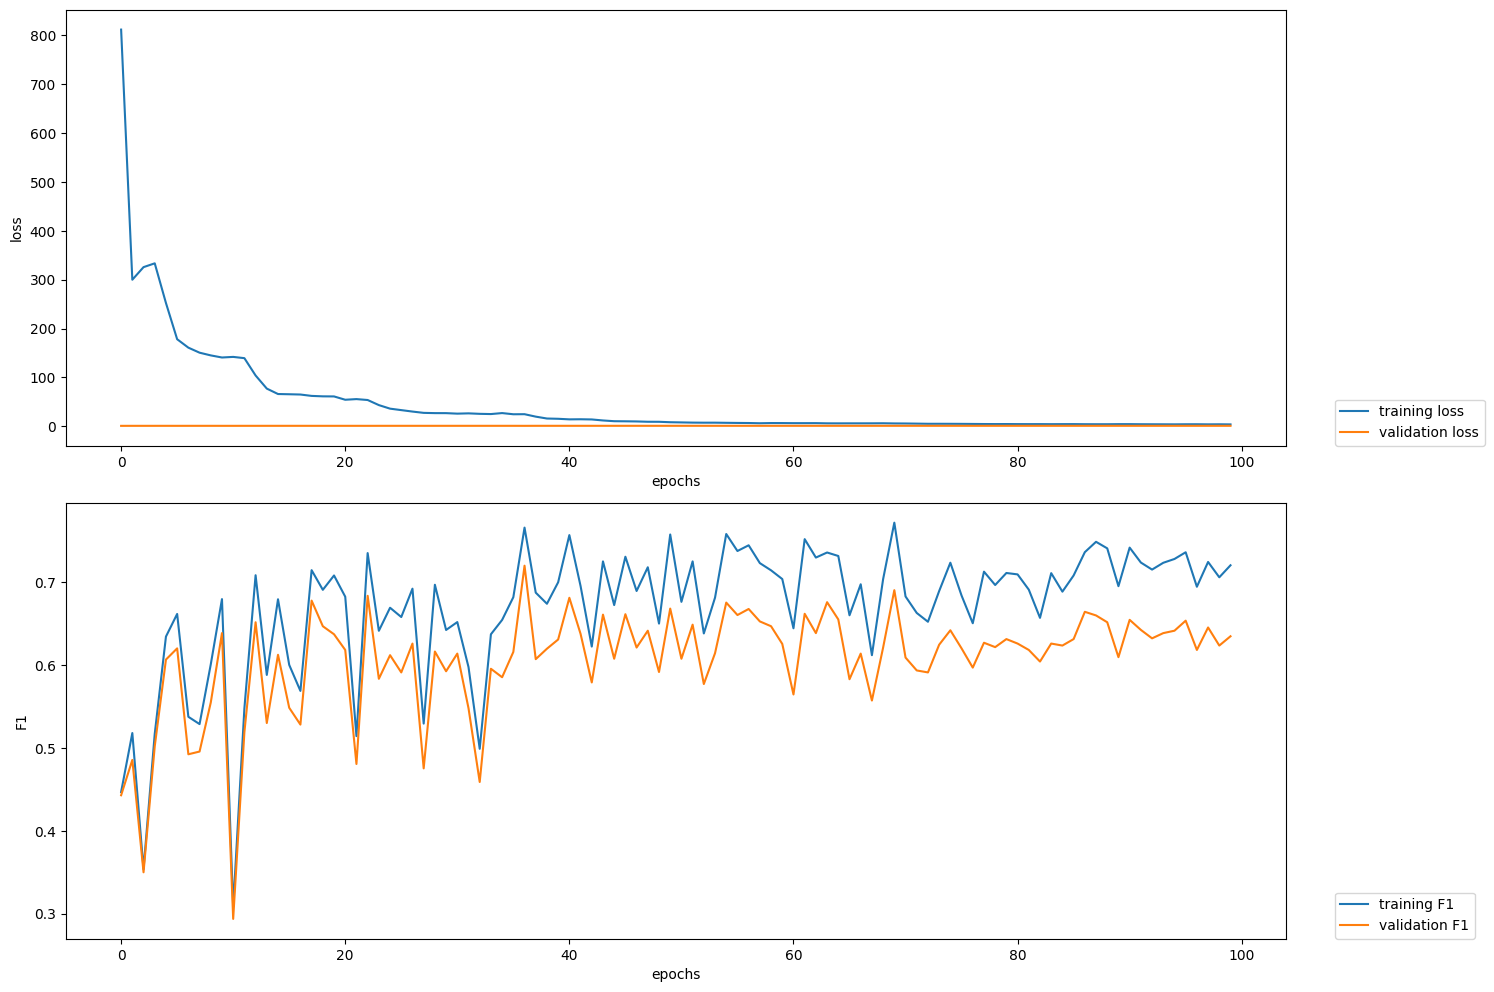

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 07:46:41,563 Evaluating as a multi-label problem: True



100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

2023-04-21 07:46:46,058 Evaluating as a multi-label problem: False



100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

2023-04-21 07:46:50,554 Evaluating as a multi-label problem: True


,split,index,I-ADR,B-ADR,B-Drug,B-Finding,I-Finding,B-Disease,B-Symptom,I-Drug,I-Disease,I-Symptom,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.774902,0.800216,0.990014,0.840426,0.837037,0.961290,0.879518,0.985185,0.981308,1.000000,0.813162,0.904990,0.815970,0.119954
1,train,recall,0.692569,0.787139,0.994269,0.511327,0.323782,0.645022,0.328829,0.826087,0.621302,0.146789,0.723155,0.587711,0.723155,0.119917
2,train,f1-score,0.731426,0.793624,0.992137,0.635815,0.466942,0.772021,0.478689,0.898649,0.760870,0.256000,0.765522,0.678617,0.757934,0.119929
3,train,support,7953.000000,4712.000000,1396.000000,309.000000,349.000000,231.000000,222.000000,161.000000,169.000000,218.000000,15720.000000,15720.000000,15720.000000,15720.000000
4,dev,precision,0.667027,0.732224,0.956044,0.444444,0.636364,0.500000,0.333333,0.636364,0.384615,0.000000,0.711435,0.529042,0.683219,NaN
5,dev,recall,0.638716,0.743472,0.945652,0.125000,0.129630,0.258065,0.080000,0.518519,0.178571,0.000000,0.638432,0.361762,0.638432,NaN
6,dev,f1-score,0.652565,0.737805,0.950820,0.195122,0.215385,0.340426,0.129032,0.571429,0.243902,0.000000,0.672959,0.403648,0.651401,NaN
7,dev,support,966.000000,651.000000,184.000000,64.000000,54.000000,31.000000,25.000000,27.000000,28.000000,36.000000,2066.000000,2066.000000,2066.000000,NaN
8,test,precision,0.730958,0.739206,0.941441,0.476190,0.400000,0.461538,1.000000,0.814815,0.500000,0.000000,0.755621,0.606415,0.732809,0.107909
9,test,recall,0.615305,0.743056,0.954338,0.192308,0.111111,0.300000,0.090909,0.423077,0.083333,0.000000,0.642031,0.351344,0.642031,0.107825


In [17]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [18]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.